## 🎯 NEW FEATURE: 30-Day Multi-Step Forward Predictions

### Overview

This notebook now includes **multi-step ahead prediction** capability:
- Predict **30 days into the future** using the Bi-LSTM model
- Based on the **last 60 days** of available data
- Iterative forecasting where each prediction builds on previous predictions
- Integrated with NSGA-II for forward-looking portfolio optimization

### Quick Start

**Step 1**: Train the Bi-LSTM model (run cells up to model training)

**Step 2**: Generate 30-day predictions (new section below)

**Step 3**: Choose prediction mode:
```python
PREDICTION_MODE = "future"     # For forward-looking optimization
# OR
PREDICTION_MODE = "historical" # For backtesting/validation
```

**Step 4**: Run NSGA-II optimization with selected predictions

**Step 5**: Select optimal portfolio from Pareto front

### Key Features

- ✅ **Multi-step forecasting**: Predict next 30 days iteratively
- ✅ **Flexible input**: Switch between historical test predictions and forward predictions  
- ✅ **Full NSGA-II integration**: Optimize portfolios using either prediction mode
- ✅ **Visualization**: See predicted returns and cumulative performance
- ✅ **Risk management**: CVaR objective for tail risk protection

---

## 🔄 How Bi-LSTM Predictions Are Used for Portfolio Optimization

### Complete Data Flow Pipeline

```
Raw Price Data
      ↓
[1] Feature Engineering (150+ features)
      ↓
[2] Target Calculation (Log Returns)
      ↓
[3] Scaling (MinMaxScaler)
      ↓
[4] Sequence Creation (60-day lookback)
      ↓
[5] Train/Val/Test Split (Temporal)
      ↓
[6] Bi-LSTM Model Training
      ↓
[7] Generate Predictions on Test Set
      ↓
[8] Inverse Transform & Convert to Simple Returns
      ↓
[9] NSGA-II Portfolio Optimization
      ↓
[10] Pareto Front Analysis & Portfolio Selection
      ↓
[11] Historical Backtesting
```

---

### Detailed Step-by-Step Explanation

#### **Step 1-5: Data Preparation**
- **Input**: Historical price data for multiple assets (~10 years)
- **Features**: 150+ engineered features (price lags, EMAs, RSI, MACD, etc.)
- **Target**: Log returns = `log(price_t / price_{t-1})`, clipped to ±20%
- **Scaling**: Features and targets scaled to [-1, 1] range
- **Sequences**: 60-day windows → predict next day's returns
- **Split**: 
  - Training: 64% (earliest dates)
  - Validation: 16% (middle dates)  
  - Test: 20% (latest dates)

#### **Step 6: Bi-LSTM Model**
```python
Model Architecture:
- Bidirectional LSTM (128 units) + Dropout (0.2)
- Bidirectional LSTM (64 units) + Dropout (0.2)
- LSTM (32 units) + Dropout (0.2)
- Dense (n_assets, activation='tanh')
- Loss: Huber (robust to outliers)
```

**What the model learns**: Predict tomorrow's log returns for all assets based on past 60 days of features

#### **Step 7-8: Generate Predictions**
```python
# Step 7: Get predictions from model
predictions = model.predict(X_test)  # Shape: (n_test_days, n_assets)

# Step 8a: Inverse scale to get actual log returns
pred_log_returns = target_scaler.inverse_transform(predictions)

# Step 8b: Convert log returns to simple returns
pred_simple_returns = np.expm1(pred_log_returns)  # exp(x) - 1

# Step 8c: Create DataFrame with dates and asset tickers
predicted_daily_returns = pd.DataFrame(
    pred_simple_returns,
    index=test_dates,
    columns=asset_tickers
)
```

**Output**: DataFrame of predicted daily returns for each asset
- Shape: (n_test_days, n_assets)
- Example: 400 days × 12 assets
- Values: Simple returns (e.g., 0.01 = 1% daily return)

---

#### **Step 9: NSGA-II Portfolio Optimization**

**Input to NSGA-II**:
```python
nsga_ii_data = {
    'predicted_returns': predicted_daily_returns,  # (T, n_assets) DataFrame
    'average_dividend_yield': avg_annual_yield,     # (n_assets,) Series
    'dividend_payer_mask': dividend_mask            # (n_assets,) Boolean
}
```

**How Predicted Returns Are Used**:

1. **Portfolio Return Calculation**:
```python
# For each candidate portfolio with weights w1, w2, ..., wn:
# Calculate daily portfolio return time series
portfolio_returns[t] = Σ(weight[i] × predicted_return[t, i])

# Annualize: multiply mean by 252
annual_return = portfolio_returns.mean() × 252
```

2. **Portfolio Volatility Calculation**:
```python
# Calculate standard deviation of portfolio returns
daily_volatility = portfolio_returns.std()

# Annualize: multiply by √252
annual_volatility = daily_volatility × √252
```

3. **CVaR (Tail Risk) Calculation**:
```python
# Sort portfolio returns (worst first)
sorted_returns = sort(portfolio_returns)

# Take worst 5% of returns
worst_5_percent = sorted_returns[:5%]

# Average of worst returns
daily_cvar = mean(worst_5_percent)

# Annualize
annual_cvar = daily_cvar × 252
```

4. **Dividend Yield**:
```python
# Weighted average of asset dividend yields
portfolio_div_yield = Σ(weight[i] × dividend_yield[i])
```

**NSGA-II Optimization Problem**:
- **Decision Variables**: Portfolio weights (w1, w2, ..., wn)
- **Constraints**:
  - Σ weights = 1
  - 0% ≤ weight ≤ 10% per asset (or 1/n if < 10 assets)
  - Minimum 1% weight for diversification
  - Optional: Dividend yield ≥ 4%

- **Objectives** (4-objective optimization):
  1. **Maximize Return**: `-annual_return` (minimize negative)
  2. **Maximize Dividend Yield**: `-portfolio_div_yield` (minimize negative)
  3. **Minimize Volatility**: `annual_volatility`
  4. **Minimize CVaR**: `-annual_cvar` (minimize negative = reduce losses)

**NSGA-II Process**:
1. Generate initial population of 500 random portfolios
2. Evaluate each portfolio on all 4 objectives using predicted returns
3. Select best portfolios using non-dominated sorting
4. Create new generation via crossover and mutation
5. Repeat for 1000 generations
6. Output: **Pareto front** of non-dominated portfolios

---

#### **Step 10: Pareto Front Analysis**

**What is the Pareto Front?**
- Set of portfolios where no portfolio is better on ALL objectives
- Each portfolio represents a different risk/return/dividend/CVaR trade-off

**Example Portfolios**:
- **Portfolio A**: High return (8%), high volatility (15%), low dividend (2%)
- **Portfolio B**: Medium return (6%), low volatility (8%), high dividend (5%)
- **Portfolio C**: Balanced across all objectives

**Selection Strategies**:
```python
# Option 1: Best Sharpe Ratio (risk-adjusted return)
best_sharpe_idx = pareto_front['Sharpe Ratio'].idxmax()

# Option 2: Lowest volatility (conservative)
least_vol_idx = pareto_front['Volatility'].idxmin()

# Option 3: Target dividend yield with minimum risk
candidates = pareto_front[pareto_front['Dividend'] > 0.04]
selected_idx = candidates['Volatility'].idxmin()

# Option 4: Best CVaR (tail risk protection)
best_cvar_idx = pareto_front['CVaR'].idxmax()  # Higher = less negative = better
```

---

#### **Step 11: Historical Backtesting**

After selecting a portfolio from the Pareto front:

```python
# Get the selected portfolio weights
selected_weights = pareto_front_solutions.loc[selected_idx]

# Calculate historical performance using ACTUAL returns (not predicted)
portfolio_historical_returns = (daily_returns × selected_weights).sum(axis=1)

# Compare with benchmark (SPY)
cumulative_returns_portfolio = (1 + portfolio_historical_returns).cumprod() - 1
cumulative_returns_spy = (1 + spy_returns).cumprod() - 1
```

**Key Metrics Calculated**:
- Cumulative returns
- Annualized return
- Sharpe ratio
- Maximum drawdown
- VaR and CVaR (95%)
- Win rate
- Alpha and Beta vs. SPY

---

### 🎯 Summary: Why This Approach Works

1. **Bi-LSTM Captures Complex Patterns**:
   - Learns non-linear relationships between 150+ features and future returns
   - Bidirectional layers capture both past and future context in the sequence
   - Predicts log returns (more stationary than prices)

2. **Predicted Returns Drive Optimization**:
   - NSGA-II uses predicted returns to estimate future portfolio performance
   - Calculates return, volatility, and CVaR from the predicted return distribution
   - Finds optimal weight combinations for different risk/return preferences

3. **No Look-Ahead Bias**:
   - Model trained only on historical data (before test period)
   - Predictions made sequentially using only past 60 days
   - Temporal train/test split ensures no future information leakage

4. **Multi-Objective Optimization**:
   - Simultaneously optimizes 4 objectives
   - Produces diverse portfolio options (Pareto front)
   - Allows investor to choose based on preferences

5. **Validated on Historical Data**:
   - Selected portfolio tested on actual historical returns
   - Performance compared to benchmark (SPY)
   - Provides realistic assessment of strategy

---

### 📊 Example Flow with Real Numbers

```
Day 100 Features → Bi-LSTM → Predicted Returns for Day 101
[price_lags, EMAs, ...]  →  [Model]  →  [AAPL: +0.8%, GOOG: +1.2%, ...]

Days 101-500 Predictions → NSGA-II → Optimal Portfolio Weights
400 days × 12 assets     → [Optimize] → [AAPL: 8%, GOOG: 10%, BTC: 5%, ...]

Selected Weights + Historical Returns → Backtest Performance
[8% AAPL, 10% GOOG, ...] × Actual Returns → Annual Return: 12%, Sharpe: 0.85
```

In [ ]:
%pip install ipykernel
%pip install yfinance
%pip install pymoo
%pip install pandas numpy matplotlib seaborn
%pip install scikit-learn
%pip install tensorflow
%pip install keras
%pip install talib-binary
%pip install TA-Lib

In [272]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [ ]:
import yfinance as yf
import pandas as pd

# Define the tickers for the selected assets, including SPY
# NOTE: SPY is included in the download for BENCHMARK comparison only
#       It will be EXCLUDED from portfolio optimization and Bi-LSTM training
#       SPY is only used to compare performance against the optimized portfolio

#tickers = ['QQQ', 'SCHD', 'GLD', 'USDU', 'IEF', 'VNQ', 'SPY'] # Replaced BTC-USD with FXE (Invesco CurrencyShares Euro Trust)
#tickers = ['QQQ', 'XLE', 'XLP', 'VEA', 'GLD', 'FXE', 'SCHH', 'SCHD', 'IEF', 'SPY']
# Porfolio selection based on applying diverisification principles
tickers = ['AAPL', 'GOOG', 'MSFT', 'NVDA', 
           'AMZN', 'AMD', 'INTC', 'META',
           'COST', 'PG', 'KO', 'PEP', 'WMT',
           'CME', 'AVGO', 'PFE', 'ABBV', 'HD', 
           'XOM', 'VDE',
           'SCHD', 'VYM', 
           'VWO', 'VEA',
           'GLD', 'SLV',
           'FXY', 'FDIVX',
           'TLT', 'SPLB',
           'SPY']  # <-- SPY is BENCHMARK ONLY (excluded from portfolio)
# Download historical data for the last 25 years
data = yf.download(tickers, period='25y') # Changed period to 10y

# We'll focus on the 'Close' price since 'Adj Close' is not directly available
# Use dropna(how='all') to only remove rows where ALL tickers are NaN
# This preserves SPY and other tickers even if some have missing data
close_data = data['Close'].dropna(how='all')

# Forward fill any remaining NaN values to handle missing data points
close_data = close_data.fillna(method='ffill').fillna(method='bfill')

# Ensure close_data index is timezone-naive for consistent alignment
if close_data.index.tz is not None:
    close_data.index = close_data.index.tz_localize(None)

display(close_data.tail())
print(f"\n✓ Close data shape: {close_data.shape}")
print(f"✓ Tickers included: {list(close_data.columns)}")
print(f"✓ SPY included: {'SPY' in close_data.columns}")

[*********************100%***********************]  31 of 31 completed



Ticker            AAPL        ABBV         AMD        AMZN        AVGO  \
Date                                                                     
2025-11-10  269.429993  218.710007  243.979996  248.399994  358.390015   
2025-11-11  275.250000  225.169998  237.520004  249.100006  351.959991   
2025-11-12  273.470001  233.229996  258.890015  244.199997  355.220001   
2025-11-13  272.950012  232.289993  247.960007  237.580002  339.980011   
2025-11-14  272.410004  232.360001  246.809998  234.690002  342.459991   

Ticker             CME        COST      FDIVX        FXY         GLD  ...  \
Date                                                                  ...   
2025-11-10  277.279999  915.559998  52.830002  59.730000  378.380005  ...   
2025-11-11  278.839996  913.859985  53.029999  59.680000  379.869995  ...   
2025-11-12  279.579987  914.000000  53.299999  59.410000  385.989990  ...   
2025-11-13  283.540009  925.080017  52.599998  59.500000  382.869995  ...   
2025-11-14  285.040009  922.979980  52.299999  59.529999  375.959991  ...   

Ticker            SLV       SPLB         SPY        TLT         VDE  \
Date                                                                  
2025-11-10  45.790001  22.870001  681.440002  89.550003  127.370003   
2025-11-11  46.450001  23.030001  683.000000  89.959999  129.000000   
2025-11-12  48.320000  22.980000  683.380005  90.120003  127.190002   
2025-11-13  47.419998  22.799999  672.039978  89.379997  127.279999   
2025-11-14  45.959999  22.700001  671.929993  88.870003  129.339996   

Ticker            VEA        VWO         VYM         WMT         XOM  
Date                                                                  
2025-11-10  61.349998  55.270000  141.029999  102.419998  117.194946  
2025-11-11  61.730000  55.330002  142.080002  103.440002  118.741417  
2025-11-12  62.130001  55.320000  142.869995  103.440002  117.095818  
2025-11-13  61.400002  54.830002  141.250000  102.540001  117.760002  
2025-11-14  61.320000  54.849998  141.009995  102.480003  119.290001  

[5 rows x 31 columns]


✓ Close data shape: (6287, 31)
✓ Tickers included: ['AAPL', 'ABBV', 'AMD', 'AMZN', 'AVGO', 'CME', 'COST', 'FDIVX', 'FXY', 'GLD', 'GOOG', 'HD', 'INTC', 'KO', 'META', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PG', 'SCHD', 'SLV', 'SPLB', 'SPY', 'TLT', 'VDE', 'VEA', 'VWO', 'VYM', 'WMT', 'XOM']
✓ SPY included: True


In [ ]:
# Calculate daily returns
daily_returns = close_data.pct_change().dropna()

# Calculate cumulative returns
cumulative_returns = (1 + daily_returns).cumprod() - 1

display(cumulative_returns.tail())
print(f"\n✓ Cumulative returns shape: {cumulative_returns.shape}")
print(f"✓ SPY in cumulative_returns: {'SPY' in cumulative_returns.columns}")

Ticker           AAPL       ABBV         AMD       AMZN        AVGO       CME  \
Date                                                                            
2025-11-10  15.218790   9.465369   95.434782  18.307449  150.065918  8.090707   
2025-11-11  15.569135   9.774483   92.881426  18.361859  147.355582  8.141852   
2025-11-12  15.461985  10.160157  101.328070  17.980995  148.729717  8.166113   
2025-11-13  15.430683  10.115178   97.007909  17.466441  142.305869  8.295944   
2025-11-14  15.398177  10.118528   96.553360  17.241809  143.351212  8.345122   

Ticker           COST     FDIVX       FXY       GLD  ...       SLV      SPLB  \
Date                                                 ...                       
2025-11-10  10.445744  2.606801 -0.468500  1.318931  ...  0.530414  0.453606   
2025-11-11  10.424492  2.620456 -0.468945  1.328063  ...  0.552473  0.463776   
2025-11-12  10.426242  2.638889 -0.471347  1.365570  ...  0.614973  0.460598   
2025-11-13  10.564758  2.591099 -0.470546  1.346448  ...  0.584893  0.449157   
2025-11-14  10.538504  2.570617 -0.470279  1.304100  ...  0.536096  0.442801   

Ticker           SPY       TLT       VDE       VEA       VWO       VYM  \
Date                                                                     
2025-11-10  4.826570  0.059978  0.796712  1.507830  0.740650  3.128247   
2025-11-11  4.839908  0.064831  0.819705  1.523363  0.742540  3.158983   
2025-11-12  4.843158  0.066725  0.794173  1.539714  0.742225  3.182107   
2025-11-13  4.746196  0.057966  0.795443  1.509874  0.726793  3.134687   
2025-11-14  4.745256  0.051929  0.824502  1.506603  0.727423  3.127661   

Ticker           WMT       XOM  
Date                            
2025-11-10  4.735525  1.236961  
2025-11-11  4.792646  1.266480  
2025-11-12  4.792646  1.235069  
2025-11-13  4.742245  1.247747  
2025-11-14  4.738886  1.276951  

[5 rows x 31 columns]

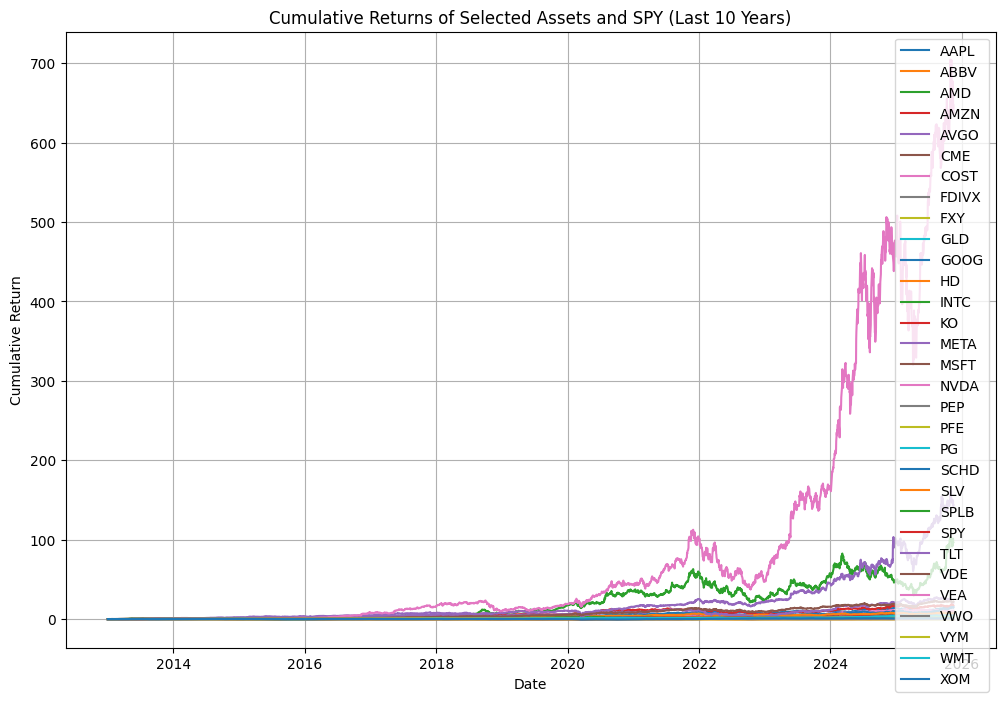

In [278]:
import matplotlib.pyplot as plt

# Plot cumulative returns
plt.figure(figsize=(12, 8))
for ticker in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)

plt.title('Cumulative Returns of Selected Assets and SPY (Last 10 Years)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [279]:
import yfinance as yf
import pandas as pd

# Exclude SPY from the list of portfolio tickers
portfolio_tickers = list(filter(lambda item: item != 'SPY', tickers))

# Initialize dividend_data with the full date range of close_data and all portfolio tickers
# Fill with 0.0 initially, as dividends are sparse.
dividend_data = pd.DataFrame(0.0, index=close_data.index, columns=portfolio_tickers)

for ticker in portfolio_tickers:
    try:
        dividends_series = yf.Ticker(ticker).dividends
        if not dividends_series.empty:
            # Ensure dividend index is timezone-naive for consistent alignment
            if dividends_series.index.tz is not None:
                dividends_series.index = dividends_series.index.tz_localize(None)

            # Reindex the dividend series to the full close_data index and fill NaNs with 0
            # Then assign it to the corresponding column in the pre-initialized dividend_data DataFrame
            dividend_data[ticker] = dividends_series.reindex(close_data.index, fill_value=0.0)

    except Exception as e:
        print(f"Could not retrieve dividend data for {ticker}: {e}")

# The dividend_data DataFrame is already filled with 0.0 for non-dividend days during reindexing,
# so a final fillna(0) might be redundant but doesn't hurt.
dividend_data = dividend_data.fillna(0)
display(dividend_data.tail())

AAPL  GOOG  MSFT  NVDA  AMZN  AMD  INTC  META  COST   PG  ...  \
Date                                                                  ...   
2025-11-10  0.26   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  0.0  ...   
2025-11-11  0.00   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  0.0  ...   
2025-11-12  0.00   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  0.0  ...   
2025-11-13  0.00   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  0.0  ...   
2025-11-14  0.00   0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  0.0  ...   

            SCHD  VYM  VWO  VEA  GLD  SLV  FXY  FDIVX  TLT  SPLB  
Date                                                              
2025-11-10   0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   0.0  
2025-11-11   0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   0.0  
2025-11-12   0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   0.0  
2025-11-13   0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   0.0  
2025-11-14   0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   0.0  

[5 rows x 30 columns]

In [280]:
# To calculate the total dividends paid by an equal-weighted portfolio,
# we can sum the dividends paid by each asset on each date and divide by the number of assets.
# However, dividend payments are not daily. We'll resample to a more appropriate frequency, like monthly or quarterly,
# and calculate the sum of dividends paid within each period. Let's use a monthly frequency.
monthly_dividends = dividend_data.resample('M').sum()

annualized_dividends = monthly_dividends.resample('Y').sum()
display("Annualized Dividends Paid by Equal Weighted Portfolio (Last 10 Years):")
display(annualized_dividends)

annualized_yield = annualized_dividends / close_data[annualized_dividends.columns]

# Assuming an equal-weighted portfolio, the total dividend received by the portfolio in each month
# is the sum of dividends from each asset divided by the number of assets.
# We need to align this with the dates in our price data.
# For simplicity here, we'll calculate the cumulative sum of dividends based on the dividend payment dates.
# A more precise calculation would involve tracking the portfolio holdings over time.

# Let's calculate the cumulative sum of dividends over time
cumulative_dividends = monthly_dividends.sum(axis=1).cumsum()

display("Cumulative Dividends Paid by Equal Weighted Portfolio (Monthly):")
display(cumulative_dividends.tail())

'Annualized Dividends Paid by Equal Weighted Portfolio (Last 10 Years):'

AAPL  GOOG  MSFT      NVDA  AMZN  AMD   INTC   META    COST  \
Date                                                                          
2013-12-31  0.421430  0.00  0.97  0.007750   0.0  0.0  0.900  0.000   1.205   
2014-12-31  0.461429  0.00  1.15  0.008500   0.0  0.0  0.900  0.000   1.375   
2015-12-31  0.507500  0.00  1.29  0.009900   0.0  0.0  0.960  0.000   6.555   
2016-12-31  0.557500  0.00  1.47  0.012125   0.0  0.0  1.040  0.000   1.750   
2017-12-31  0.615000  0.00  1.59  0.014250   0.0  0.0  1.079  0.000   8.950   
2018-12-31  0.705000  0.00  1.72  0.015250   0.0  0.0  1.200  0.000   2.210   
2019-12-31  0.760000  0.00  1.89  0.016000   0.0  0.0  1.260  0.000   2.520   
2020-12-31  0.807500  0.00  2.09  0.016000   0.0  0.0  1.320  0.000  12.750   
2021-12-31  0.865000  0.00  2.30  0.016000   0.0  0.0  1.392  0.000   3.070   
2022-12-31  0.910000  0.00  2.54  0.016000   0.0  0.0  1.460  0.000   3.490   
2023-12-31  0.950000  0.00  2.79  0.016000   0.0  0.0  0.740  0.000  18.960   
2024-12-31  0.990000  0.60  3.08  0.034000   0.0  0.0  0.375  2.000   4.500   
2025-12-31  1.030000  0.62  2.49  0.030000   0.0  0.0  0.000  1.575   5.060   

               PG  ...      SCHD    VYM    VWO    VEA  GLD  SLV  FXY  FDIVX  \
Date               ...                                                        
2013-12-31  2.368  ...  0.301333  1.749  1.125  1.083  0.0  0.0  0.0  0.552   
2014-12-31  2.534  ...  0.348668  1.908  1.143  1.394  0.0  0.0  0.0  1.314   
2015-12-31  2.633  ...  0.382334  2.149  1.066  1.071  0.0  0.0  0.0  0.473   
2016-12-31  2.673  ...  0.419333  2.206  0.900  1.114  0.0  0.0  0.0  0.452   
2017-12-31  2.740  ...  0.448667  2.401  1.058  1.243  0.0  0.0  0.0  2.121   
2018-12-31  2.841  ...  0.479999  2.649  1.098  1.244  0.0  0.0  0.0  2.318   
2019-12-31  2.955  ...  0.574999  2.842  1.439  1.340  0.0  0.0  0.0  0.533   
2020-12-31  3.119  ...  0.676333  2.906  0.955  0.965  0.0  0.0  0.0  0.463   
2021-12-31  3.401  ...  0.750001  3.096  1.299  1.614  0.0  0.0  0.0  5.136   
2022-12-31  3.609  ...  0.854000  3.252  1.604  1.223  0.0  0.0  0.0  0.487   
2023-12-31  3.736  ...  0.886333  3.479  1.448  1.512  0.0  0.0  0.0  1.761   
2024-12-31  3.962  ...  0.995001  3.495  1.409  1.605  0.0  0.0  0.0  1.657   
2025-12-31  4.178  ...  0.769000  2.554  0.466  0.970  0.0  0.0  0.0  0.000   

              TLT      SPLB  
Date                         
2013-12-31  3.317  1.208000  
2014-12-31  3.362  1.171332  
2015-12-31  3.148  1.178001  
2016-12-31  3.102  1.250001  
2017-12-31  3.088  1.161334  
2018-12-31  3.196  1.141000  
2019-12-31  3.074  1.140000  
2020-12-31  2.365  0.996000  
2021-12-31  2.217  0.945000  
2022-12-31  2.656  1.015000  
2023-12-31  3.343  1.094000  
2024-12-31  3.755  1.157000  
2025-12-31  3.198  0.990000  

[13 rows x 30 columns]

'Cumulative Dividends Paid by Equal Weighted Portfolio (Monthly):'

Date
2025-07-31    677.158235
2025-08-31    681.204235
2025-09-30    691.118235
2025-10-31    695.522235
2025-11-30    697.666235
Freq: ME, dtype: float64

In [281]:
import pandas as pd

# Ensure dividend_data and close_data are available
if 'dividend_data' not in globals() or 'close_data' not in globals():
    raise ValueError("dividend_data or close_data not found. Please ensure these are loaded.")

# Calculate annual dividends paid per ticker
# We'll reindex dividend_data to close_data's index and then resample annually
aligned_daily_dividends = dividend_data.reindex(close_data.index).fillna(0)
annual_dividends_sum = aligned_daily_dividends.resample('YE').sum()

# Get year-end closing prices per ticker
# Find the last available close price for each year
annual_closing_prices = close_data.resample('YE').last()

# Calculate the annualized dividend yield for each year and ticker
# Handle potential division by zero by replacing 0s with NaN before division
annual_dividend_yield_per_ticker = annual_dividends_sum.div(annual_closing_prices.replace(0, pd.NA))

display("Annualized Dividend Yield (Annual Dividends / Year-End Price) per Ticker:")
display(annual_dividend_yield_per_ticker.fillna(0).tail())

# Optional: Display mean annual yield over the period for comparison
#display("\nAverage Annualized Dividend Yield (Mean over years) per Ticker:")
#display(annual_dividend_yield_per_ticker.mean().fillna(0).sort_values(ascending=False))

'Annualized Dividend Yield (Annual Dividends / Year-End Price) per Ticker:'

AAPL      ABBV  AMD  AMZN      AVGO       CME      COST  \
Date                                                                      
2021-12-31  0.004974  0.044535  0.0   0.0  0.024127  0.034968  0.005672   
2022-12-31  0.007109  0.038952  0.0   0.0  0.031553  0.056270  0.007966   
2023-12-31  0.004981  0.040982  0.0   0.0  0.017419  0.048647  0.029042   
2024-12-31  0.003971  0.036110  0.0   0.0  0.009426  0.045427  0.004937   
2025-12-31  0.003781  0.028232  0.0   0.0  0.005168  0.013156  0.005482   

               FDIVX  FXY  GLD  ...  SLV      SPLB  SPY       TLT       VDE  \
Date                            ...                                           
2021-12-31  0.122932  0.0  0.0  ...  0.0  0.036071  0.0  0.017102  0.047070   
2022-12-31  0.015167  0.0  0.0  ...  0.0  0.052134  0.0  0.029794  0.039869   
2023-12-31  0.045323  0.0  0.0  ...  0.0  0.050531  0.0  0.036491  0.035273   
2024-12-31  0.039303  0.0  0.0  ...  0.0  0.054387  0.0  0.044578  0.033085   
2025-12-31  0.000000  0.0  0.0  ...  0.0  0.043612  0.0  0.035985  0.022282   

                 VEA       VWO       VYM       WMT       XOM  
Date                                                          
2021-12-31  0.035366  0.029499  0.030865  0.015987  0.065742  
2022-12-31  0.031655  0.044409  0.032562  0.016353  0.035682  
2023-12-31  0.033184  0.036694  0.032686  0.014746  0.039460  
2024-12-31  0.034150  0.032285  0.027923  0.009278  0.037008  
2025-12-31  0.015819  0.008496  0.018112  0.006879  0.033532  

[5 rows x 31 columns]

In [282]:
import pandas as pd
import numpy as np

# Ensure required dataframes are available
if 'annual_dividend_yield_per_ticker' not in globals():
    raise ValueError("annual_dividend_yield_per_ticker is not defined. Please run the previous cell to calculate it.")
if 'annual_closing_prices' not in globals():
    raise ValueError("annual_closing_prices is not defined. Please run the previous cell to calculate it.")
if 'close_data' not in globals():
    raise ValueError("close_data is not defined. Please ensure historical price data is downloaded.")

# 1. Calculate the total annual dividends in dollar amounts
# We need to ensure indices and columns align for multiplication
# Reindex annual_closing_prices to match annual_dividend_yield_per_ticker index and columns
aligned_annual_closing_prices = annual_closing_prices.reindex_like(annual_dividend_yield_per_ticker)
annual_dividend_dollars_per_ticker = annual_dividend_yield_per_ticker * aligned_annual_closing_prices

# Fill any NaNs that might result from missing data points in either source with 0
annual_dividend_dollars_per_ticker = annual_dividend_dollars_per_ticker.fillna(0)

# 2. Determine the number of trading days for each year
# Group close_data by year and count the number of entries
trading_days_per_year = close_data.groupby(close_data.index.year).size()

# Create a DataFrame to store the new aligned daily dividend data
aligned_daily_dividend_data_new = pd.DataFrame(0.0, index=close_data.index, columns=portfolio_tickers)

# 3. Distribute annual dividends evenly across trading days in each year
for year in annual_dividend_dollars_per_ticker.index.year.unique():
    if year in trading_days_per_year.index:
        num_days = trading_days_per_year[year]
        if num_days > 0:
            # Get the annual dividend dollars for the current year
            annual_dividends_for_year = annual_dividend_dollars_per_ticker.loc[annual_dividend_dollars_per_ticker.index.year == year].iloc[0]

            # Calculate the daily average dividend amount for this year
            daily_avg_dividends_for_year = annual_dividends_for_year / num_days

            # Assign this daily average to all trading days within that year
            year_mask = (aligned_daily_dividend_data_new.index.year == year)
            # Ensure alignment of columns and use .loc for assignment
            aligned_daily_dividend_data_new.loc[year_mask, daily_avg_dividends_for_year.index] = daily_avg_dividends_for_year.values

# Display the head and tail of the newly created DataFrame
display("New Aligned Daily Dividend Data (derived from annual yield/year-end price distributed daily):")
display(aligned_daily_dividend_data_new.tail())

# Update the global aligned_daily_dividend_data variable with the new calculation
aligned_daily_dividend_data = aligned_daily_dividend_data_new

# Update nsga_ii_data with the average annual dividend yield (re-calculating using this new data)
# Recalculate average_dividend_yield from the newly created aligned_daily_dividend_data
cols = list(portfolio_tickers)

# Reindex aligned_daily_dividend_data to close_data's index if not already (should be the case)
div_df_aligned = aligned_daily_dividend_data.reindex(close_data.index).fillna(0)

# Calculate annual dividends sum
annual_div_sum = div_df_aligned.resample('YE').sum()

# Get year-end closing prices per ticker for average yield calculation
annual_close_prices_for_yield = close_data.resample('YE').last()

# Calculate average annual yield based on new data
# Handle potential division by zero
avg_annual_yield = (annual_div_sum.div(annual_close_prices_for_yield.replace(0, np.nan))).mean(axis=0).reindex(cols).fillna(0)


'New Aligned Daily Dividend Data (derived from annual yield/year-end price distributed daily):'

AAPL      GOOG     MSFT      NVDA  AMZN  AMD  INTC      META  \
Date                                                                           
2025-11-10  0.004703  0.002831  0.01137  0.000137   0.0  0.0   0.0  0.007192   
2025-11-11  0.004703  0.002831  0.01137  0.000137   0.0  0.0   0.0  0.007192   
2025-11-12  0.004703  0.002831  0.01137  0.000137   0.0  0.0   0.0  0.007192   
2025-11-13  0.004703  0.002831  0.01137  0.000137   0.0  0.0   0.0  0.007192   
2025-11-14  0.004703  0.002831  0.01137  0.000137   0.0  0.0   0.0  0.007192   

                COST        PG  ...       VYM       VWO       VEA  GLD  SLV  \
Date                            ...                                           
2025-11-10  0.023105  0.019078  ...  0.011662  0.002128  0.004429  0.0  0.0   
2025-11-11  0.023105  0.019078  ...  0.011662  0.002128  0.004429  0.0  0.0   
2025-11-12  0.023105  0.019078  ...  0.011662  0.002128  0.004429  0.0  0.0   
2025-11-13  0.023105  0.019078  ...  0.011662  0.002128  0.004429  0.0  0.0   
2025-11-14  0.023105  0.019078  ...  0.011662  0.002128  0.004429  0.0  0.0   

            FXY  FDIVX       TLT      SPLB  SPY  
Date                                             
2025-11-10  0.0    0.0  0.014603  0.004521  0.0  
2025-11-11  0.0    0.0  0.014603  0.004521  0.0  
2025-11-12  0.0    0.0  0.014603  0.004521  0.0  
2025-11-13  0.0    0.0  0.014603  0.004521  0.0  
2025-11-14  0.0    0.0  0.014603  0.004521  0.0  

[5 rows x 31 columns]

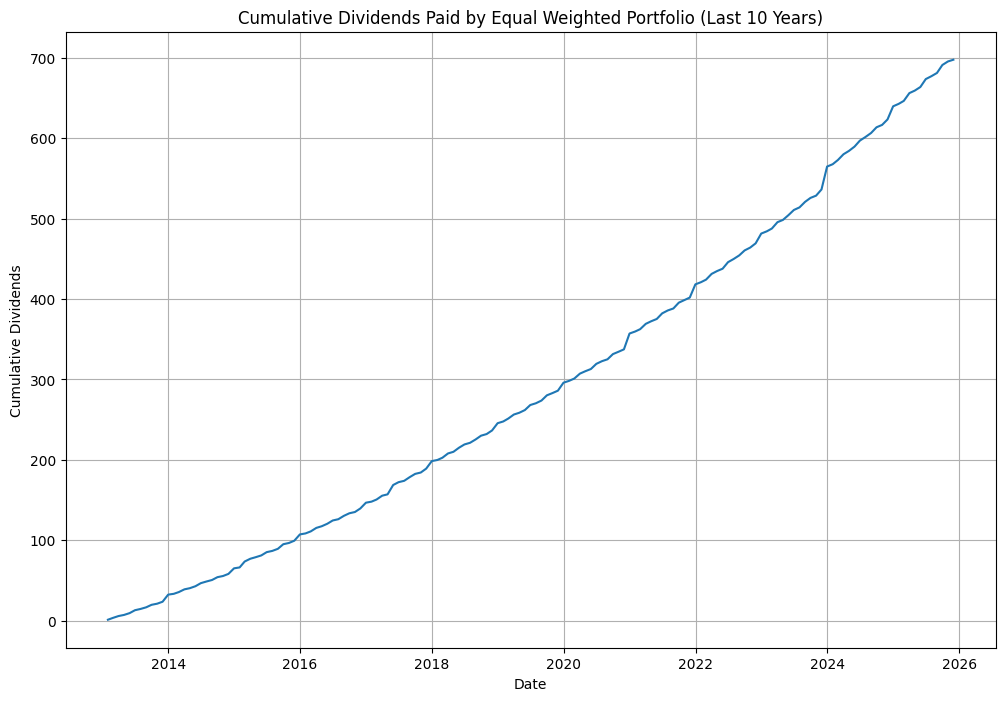

In [283]:
import matplotlib.pyplot as plt

# Plot cumulative dividends paid by the portfolio
plt.figure(figsize=(12, 8))
plt.plot(cumulative_dividends.index, cumulative_dividends)

plt.title('Cumulative Dividends Paid by Equal Weighted Portfolio (Last 10 Years)')
plt.xlabel('Date')
plt.ylabel('Cumulative Dividends')
plt.grid(True)
plt.show()

In [284]:
# Exclude SPY from the portfolio
portfolio_assets = close_data.drop(columns=['SPY'])

# Calculate daily returns for the portfolio assets
portfolio_daily_returns = portfolio_assets.pct_change().dropna()

# For a simple equal-weighted portfolio, the portfolio daily return is the average of the asset daily returns
portfolio_returns = portfolio_daily_returns.mean(axis=1)

# Calculate cumulative returns of the portfolio
portfolio_cumulative_returns = (1 + portfolio_returns).cumprod() - 1

display("Portfolio Cumulative Returns (Equal Weighted):")
display(portfolio_cumulative_returns.tail())

'Portfolio Cumulative Returns (Equal Weighted):'

Date
2025-11-10    7.465247
2025-11-11    7.515872
2025-11-12    7.548086
2025-11-13    7.455833
2025-11-14    7.435477
dtype: float64

In [285]:
import numpy as np

# Calculate annualized volatility (assuming 252 trading days in a year)
annualized_volatility = portfolio_returns.std() * np.sqrt(252)

# Calculate Sharpe Ratio (assuming risk-free rate is 0 for simplicity in this example)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

display(f"Portfolio Annualized Volatility (Equal Weighted): {annualized_volatility:.4f}")
display(f"Portfolio Sharpe Ratio (Equal Weighted): {sharpe_ratio:.4f}")

'Portfolio Annualized Volatility (Equal Weighted): 0.1432'

'Portfolio Sharpe Ratio (Equal Weighted): 1.2310'

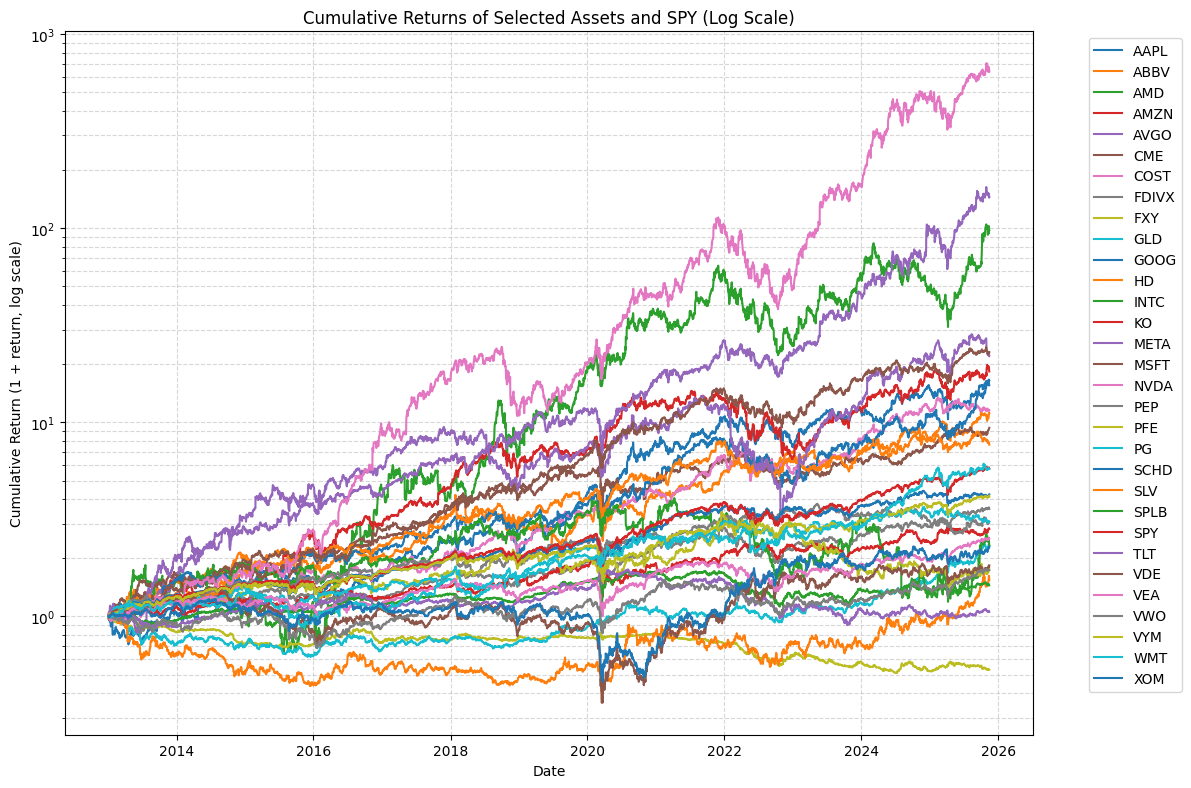

In [287]:
import matplotlib.pyplot as plt

# Plot cumulative returns with log scale
plt.figure(figsize=(12, 8))
for ticker in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker] + 1, label=ticker)  # +1 to avoid log(0)

plt.yscale('log')  # Enable log scale
plt.title('Cumulative Returns of Selected Assets and SPY (Log Scale)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (1 + return, log scale)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [288]:
import numpy as np
import pandas as pd

# Calculate daily returns for SPY
spy_returns = daily_returns['SPY']

# Calculate Annualized Volatility for SPY (assuming 252 trading days in a year)
spy_annualized_volatility = spy_returns.std() * np.sqrt(252)

# Calculate Sharpe Ratio for SPY (assuming risk-free rate is 0 for simplicity)
spy_sharpe_ratio = spy_returns.mean() / spy_returns.std() * np.sqrt(252)

# Calculate Value at Risk (VaR) for SPY
# VaR at a certain confidence level (e.g., 95%) represents the maximum expected loss over a given time period.
# We'll use the historical method here.
confidence_level = 0.95
spy_VaR_95 = -np.percentile(spy_returns, 100 * (1 - confidence_level))

confidence_level_99 = 0.99
spy_VaR_99 = -np.percentile(spy_returns, 100 * (1 - confidence_level_99))


# Calculate Conditional Value at Risk (CVaR) for SPY
# CVaR (or Expected Shortfall) is the expected loss given that the loss is greater than the VaR.
# It provides a more conservative measure of risk than VaR.
# We'll calculate CVaR based on the returns that are worse than the VaR.
spy_CVaR_95 = -spy_returns[spy_returns < -spy_VaR_95].mean()
spy_CVaR_99 = -spy_returns[spy_returns < -spy_VaR_99].mean()


display(f"SPY Annualized Volatility: {spy_annualized_volatility:.4f}")
display(f"SPY Sharpe Ratio: {spy_sharpe_ratio:.4f}")
display(f"SPY VaR (95% confidence): {spy_VaR_95:.4f}")
display(f"SPY CVaR (95% confidence): {spy_CVaR_95:.4f}")
display(f"SPY VaR (99% confidence): {spy_VaR_99:.4f}")
display(f"SPY CVaR (99% confidence): {spy_CVaR_99:.4f}")

'SPY Annualized Volatility: 0.1697'

'SPY Sharpe Ratio: 0.8870'

'SPY VaR (95% confidence): 0.0160'

'SPY CVaR (95% confidence): 0.0259'

'SPY VaR (99% confidence): 0.0302'

'SPY CVaR (99% confidence): 0.0444'

In [289]:
import numpy as np
import pandas as pd

# Calculate Annualized Volatility (already done, but including for completeness)
annualized_volatility = portfolio_returns.std() * np.sqrt(252)

# Calculate Sharpe Ratio (already done, but including for completeness)
# Assuming risk-free rate is 0 for simplicity
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

# Calculate Value at Risk (VaR)
# VaR at a certain confidence level (e.g., 95%) represents the maximum expected loss over a given time period.
# We'll use the historical method here.
confidence_level = 0.95
VaR_95 = -np.percentile(portfolio_returns, 100 * (1 - confidence_level))

confidence_level_99 = 0.99
VaR_99 = -np.percentile(portfolio_returns, 100 * (1 - confidence_level_99))


# Calculate Conditional Value at Risk (CVaR)
# CVaR (or Expected Shortfall) is the expected loss given that the loss is greater than the VaR.
# It provides a more conservative measure of risk than VaR.
# We'll calculate CVaR based on the returns that are worse than the VaR.
CVaR_95 = -portfolio_returns[portfolio_returns < -VaR_95].mean()
CVaR_99 = -portfolio_returns[portfolio_returns < -VaR_99].mean()

display(f"Portfolio Annualized Volatility (Equal Weighted): {annualized_volatility:.4f}")
display(f"Portfolio Sharpe Ratio (Equal Weighted): {sharpe_ratio:.4f}")
display(f"Portfolio VaR (95% confidence): {VaR_95:.4f}")
display(f"Portfolio CVaR (95% confidence): {CVaR_95:.4f}")
display(f"Portfolio VaR (99% confidence): {VaR_99:.4f}")
display(f"Portfolio CVaR (99% confidence): {CVaR_99:.4f}")

'Portfolio Annualized Volatility (Equal Weighted): 0.1432'

'Portfolio Sharpe Ratio (Equal Weighted): 1.2310'

'Portfolio VaR (95% confidence): 0.0130'

'Portfolio CVaR (95% confidence): 0.0212'

'Portfolio VaR (99% confidence): 0.0245'

'Portfolio CVaR (99% confidence): 0.0370'

# Task
Develop a growth and income stock portfolio prototype with a 4% dividend return using a multivariate bi-lstm model for stock prediction and the NSGA-II algorithm for portfolio selection, referencing the paper "https://www.sciencedirect.com/science/article/pii/S2666188825003971". Use yfinance to select top-performing GOOG, AAPL, Gold etf, Bitcoin, US treasuries, and REIT for diversification. Compare the portfolio's performance over the last 10 years with SPY (excluding SPY from the portfolio). Calculate and plot the portfolio's dividends, VaR, CVaR, and Sharpe Ratio, and also calculate VaR and Sharpe Ratio for SPY.

## Prepare data for bi-lstm

### Subtask:
Structure the historical price data into sequences suitable for training the Bi-LSTM model. This will involve defining a look-back period and creating input/output pairs.


**Reasoning**:
Define the look-back period and create sequences and labels from the portfolio's historical closing price data.



In [290]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import talib as ta # Import TA-Lib

# Define the look-back period
look_back = 60

# Exclude SPY from the close data for portfolio training
portfolio_close_data = close_data.drop(columns=['SPY']).copy()

# --- Refactor: Build ohlc_data more efficiently ---
ohlc_data_parts = []
# Track tickers that actually have OHLC data to ensure portfolio_close_data is aligned
actual_ohlc_tickers = []

for ticker in portfolio_close_data.columns:
    # Check for full OHLC data presence (Open, High, Low, Close)
    if all(col in data.columns for col in [('Open', ticker), ('High', ticker), ('Low', ticker), ('Close', ticker)]):
        temp_df = data[[('Open', ticker), ('High', ticker), ('Low', ticker), ('Close', ticker)]].copy()
        temp_df.columns = pd.MultiIndex.from_product([[ticker], ['Open', 'High', 'Low', 'Close']])
        ohlc_data_parts.append(temp_df)
        actual_ohlc_tickers.append(ticker)
    elif ('Close', ticker) in data.columns:
        # Fallback to only Close data if full OHLC is not available (e.g., for some ETFs)
        temp_df = data[[('Close', ticker)]].copy()
        temp_df.columns = pd.MultiIndex.from_product([[ticker], ['Close']])
        ohlc_data_parts.append(temp_df)
        actual_ohlc_tickers.append(ticker)
        print(f"Only Close data available for {ticker}. Proceeding with Close prices only for feature engineering.")
    else:
        # If no relevant data, print a message and this ticker won't be in actual_ohlc_tickers
        print(f"No relevant OHLC data available for {ticker}. Skipping feature engineering for this asset.")

if ohlc_data_parts:
    # Concatenate all parts into a single DataFrame
    ohlc_data = pd.concat(ohlc_data_parts, axis=1)
    # Reindex to match the original portfolio_close_data index and drop NaNs introduced by reindexing/missing data
    ohlc_data = ohlc_data.reindex(portfolio_close_data.index).dropna()
else:
    raise ValueError("No OHLC data could be constructed for any asset.")

# Adjust portfolio_close_data to only include assets for which OHLC data was successfully processed and aligned
# This ensures consistency for feature calculation base.
portfolio_close_data = portfolio_close_data[actual_ohlc_tickers].reindex(ohlc_data.index)


## Add Enhanced Lag Features and Engineered Variables

Adding comprehensive lag features similar to the polars-based approach:
- Close price lags (1, 2, 3 days)
- High-Minus-Low (HML) and its lags
- Open-Minus-Close (OMC) and its lags
- Volume lags
- Exponential moving averages with different half-lives
- Log returns based on lagged prices

In [291]:
# Enhanced feature engineering with comprehensive lag features
# This mirrors the polars-based approach with pandas

all_features_list_enhanced = []

for ticker in portfolio_close_data.columns:
    ticker_features_df = pd.DataFrame(index=portfolio_close_data.index)
    
    # ===== CLOSE PRICE LAG FEATURES =====
    # Create lag price features (1, 2, 3 days)
    ticker_features_df[f'{ticker}_CloseLag1'] = portfolio_close_data[ticker].shift(1)
    ticker_features_df[f'{ticker}_CloseLag2'] = portfolio_close_data[ticker].shift(2)
    ticker_features_df[f'{ticker}_CloseLag3'] = portfolio_close_data[ticker].shift(3)
    
    # ===== HIGH-MINUS-LOW (HML) FEATURES =====
    # Create High-Minus-Low for the day and its lags
    if (ticker, 'High') in ohlc_data.columns and (ticker, 'Low') in ohlc_data.columns:
        hml = ohlc_data.loc[:, (ticker, 'High')] - ohlc_data.loc[:, (ticker, 'Low')]
        ticker_features_df[f'{ticker}_HML'] = hml
        ticker_features_df[f'{ticker}_HMLLag1'] = hml.shift(1)
        ticker_features_df[f'{ticker}_HMLLag2'] = hml.shift(2)
        ticker_features_df[f'{ticker}_HMLLag3'] = hml.shift(3)
    else:
        # Placeholder if OHLC data is missing
        for col in ['HML', 'HMLLag1', 'HMLLag2', 'HMLLag3']:
            ticker_features_df[f'{ticker}_{col}'] = 0.0
    
    # ===== OPEN-MINUS-CLOSE (OMC) FEATURES =====
    # Create Open-Minus-Close for the day and its lags
    if (ticker, 'Open') in ohlc_data.columns and (ticker, 'Close') in ohlc_data.columns:
        omc = ohlc_data.loc[:, (ticker, 'Open')] - ohlc_data.loc[:, (ticker, 'Close')]
        ticker_features_df[f'{ticker}_OMC'] = omc
        ticker_features_df[f'{ticker}_OMCLag1'] = omc.shift(1)
        ticker_features_df[f'{ticker}_OMCLag2'] = omc.shift(2)
        ticker_features_df[f'{ticker}_OMCLag3'] = omc.shift(3)
    else:
        # Placeholder if OHLC data is missing
        for col in ['OMC', 'OMCLag1', 'OMCLag2', 'OMCLag3']:
            ticker_features_df[f'{ticker}_{col}'] = 0.0
    
    # ===== VOLUME LAG FEATURES =====
    # Create volume lag features (if Volume data is available)
    if (ticker, 'Volume') in data.columns:
        volume = data[(ticker, 'Volume')].reindex(portfolio_close_data.index)
        ticker_features_df[f'{ticker}_Volume'] = volume.astype(float)
        ticker_features_df[f'{ticker}_VolumeLag1'] = volume.shift(1).astype(float)
        ticker_features_df[f'{ticker}_VolumeLag2'] = volume.shift(2).astype(float)
        ticker_features_df[f'{ticker}_VolumeLag3'] = volume.shift(3).astype(float)
    else:
        # Placeholder if Volume data is missing
        for col in ['Volume', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3']:
            ticker_features_df[f'{ticker}_{col}'] = 0.0
    
    # ===== EXPONENTIAL MOVING AVERAGES =====
    # Compute exponential moving averages of CloseLag1 (to avoid leakage)
    # Using halflife parameter similar to polars ewm_mean
    # Note: pandas ewm uses halflife or span; halflife=1 means decay to 50% in 1 period
    ticker_features_df[f'{ticker}_CloseEMA2'] = ticker_features_df[f'{ticker}_CloseLag1'].ewm(halflife=1, ignore_na=True).mean()
    ticker_features_df[f'{ticker}_CloseEMA4'] = ticker_features_df[f'{ticker}_CloseLag1'].ewm(halflife=2, ignore_na=True).mean()
    ticker_features_df[f'{ticker}_CloseEMA8'] = ticker_features_df[f'{ticker}_CloseLag1'].ewm(halflife=4, ignore_na=True).mean()
    
    # ===== LOG RETURNS =====
    # Log daily returns based on Close / CloseLag1
    ticker_features_df[f'{ticker}_LogReturn'] = np.log(
        portfolio_close_data[ticker] / ticker_features_df[f'{ticker}_CloseLag1']
    )
    # ===== ADDITIONAL TECHNICAL INDICATORS =====   
    
    # RSI (Relative Strength Index)
    rsi_period = 14
    ticker_features_df[f'{ticker}_RSI'] = ta.RSI(portfolio_close_data[ticker], timeperiod=rsi_period)
    
    # MACD (Moving Average Convergence Divergence)
    macd, macd_signal, macd_hist = ta.MACD(portfolio_close_data[ticker], fastperiod=12, slowperiod=26, signalperiod=9)
    ticker_features_df[f'{ticker}_MACD'] = macd
    ticker_features_df[f'{ticker}_MACD_Signal'] = macd_signal
    ticker_features_df[f'{ticker}_MACD_Hist'] = macd_hist
    # Append the ticker-specific features DataFrame to the list     
    all_features_list_enhanced.append(ticker_features_df)

# Concatenate all ticker-specific feature DataFrames
portfolio_features_data = pd.concat(all_features_list_enhanced, axis=1).dropna()

print(f"Enhanced features shape: {portfolio_features_data.shape}")
print(f"Feature columns (first 20): {list(portfolio_features_data.columns[:20])}")
display(portfolio_features_data.head())

Enhanced features shape: (3206, 690)
Feature columns (first 20): ['AAPL_CloseLag1', 'AAPL_CloseLag2', 'AAPL_CloseLag3', 'AAPL_HML', 'AAPL_HMLLag1', 'AAPL_HMLLag2', 'AAPL_HMLLag3', 'AAPL_OMC', 'AAPL_OMCLag1', 'AAPL_OMCLag2', 'AAPL_OMCLag3', 'AAPL_Volume', 'AAPL_VolumeLag1', 'AAPL_VolumeLag2', 'AAPL_VolumeLag3', 'AAPL_CloseEMA2', 'AAPL_CloseEMA4', 'AAPL_CloseEMA8', 'AAPL_LogReturn', 'AAPL_RSI']


AAPL_CloseLag1  AAPL_CloseLag2  AAPL_CloseLag3  AAPL_HML  \
Date                                                                   
2013-02-20       13.999206       14.004377       14.200071  0.270557   
2013-02-21       13.660172       13.999206       14.004377  0.193255   
2013-02-22       13.575268       13.660172       13.999206  0.152168   
2013-02-25       13.719826       13.575268       13.660172  0.381943   
2013-02-26       13.476051       13.719826       13.575268  0.422420   

            AAPL_HMLLag1  AAPL_HMLLag2  AAPL_HMLLag3  AAPL_OMC  AAPL_OMCLag1  \
Date                                                                           
2013-02-20      0.270251      0.311642      0.231905  0.269034      0.033783   
2013-02-21      0.270557      0.270251      0.311642 -0.001826      0.269034   
2013-02-22      0.193255      0.270557      0.270251 -0.047476     -0.001826   
2013-02-25      0.152168      0.193255      0.270557  0.336293     -0.047476   
2013-02-26      0.381943      0.152168      0.193255 -0.156734      0.336293   

            AAPL_OMCLag2  ...  XOM_VolumeLag2  XOM_VolumeLag3  XOM_CloseEMA2  \
Date                      ...                                                  
2013-02-20      0.264468  ...             0.0             0.0      52.829569   
2013-02-21      0.033783  ...             0.0             0.0      52.854535   
2013-02-22      0.269034  ...             0.0             0.0      52.754086   
2013-02-25     -0.001826  ...             0.0             0.0      52.885130   
2013-02-26     -0.047476  ...             0.0             0.0      52.504892   

            XOM_CloseEMA4  XOM_CloseEMA8  XOM_LogReturn    XOM_RSI  XOM_MACD  \
Date                                                                           
2013-02-20      52.760563      52.821542      -0.003926  50.875975  0.022917   
2013-02-21      52.795400      52.830789      -0.004280  47.723929  0.000923   
2013-02-22      52.753878      52.802538       0.006862  52.780866  0.012602   
2013-02-25      52.830703      52.836594      -0.016959  42.016901 -0.049510   
2013-02-26      52.623905      52.723136       0.009194  48.164720 -0.059204   

            XOM_MACD_Signal  XOM_MACD_Hist  
Date                                        
2013-02-20         0.126858      -0.103941  
2013-02-21         0.101671      -0.100748  
2013-02-22         0.083857      -0.071255  
2013-02-25         0.057184      -0.106694  
2013-02-26         0.033906      -0.093110  

[5 rows x 690 columns]

In [293]:
# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(portfolio_features_data)  # shape (T, n_features)

# IMPORTANT: Predict LOG RETURNS instead of prices for better trend capture
# Log returns are more stationary and directional
close_targets = portfolio_close_data.reindex(portfolio_features_data.index).values  # shape (T, n_assets)

# Calculate log returns: log(price_t / price_t-1)
log_returns = np.log(close_targets[1:] / close_targets[:-1])  # shape (T-1, n_assets)

# Clip extreme returns to prevent outlier issues
log_returns = np.clip(log_returns, -0.2, 0.2)  # ±20% daily return limit

# Pad the first row with zeros (no previous price for first day)
log_returns = np.vstack([np.zeros((1, log_returns.shape[1])), log_returns])

# Scale returns to reasonable range for neural network
target_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaled = target_scaler.fit_transform(log_returns)  # scaled returns (T, n_assets)

# Store close prices for inverse transformation later
close_prices_for_inverse = close_targets.copy()

# sequence builder now takes features AND target arrays
def create_sequences(feature_array, target_array, look_back):
    """
    Create sequences for LSTM without look-ahead bias.
    Each sequence uses only past data to predict the next day.
    
    Parameters:
    - feature_array: scaled features (T, n_features)
    - target_array: scaled targets (T, n_assets)
    - look_back: number of time steps to look back
    
    Returns:
    - X: sequences of shape (n_samples, look_back, n_features)
    - y: targets of shape (n_samples, n_assets)
    """
    X, y = [], []
    for i in range(len(feature_array) - look_back):
        # Use days [i, i+look_back) to predict day i+look_back
        X.append(feature_array[i:(i + look_back)])
        y.append(target_array[i + look_back])
    return np.array(X), np.array(y)

# Build ALL possible sequences up to the latest date
# This ensures we have predictions all the way to the end
X, y = create_sequences(scaled_data, target_scaled, look_back)

display("Shape of input sequences X:", X.shape)
display("Shape of output labels y (scaled log returns):", y.shape)

# Calculate the date range for sequences
# First sequence predicts day at index 'look_back'
# Last sequence predicts day at index 'look_back + len(X) - 1'
first_pred_date = portfolio_close_data.index[look_back]
last_pred_date = portfolio_close_data.index[look_back + len(X) - 1]
print(f"\nSequence date range:")
print(f"  First prediction date: {first_pred_date.date()}")
print(f"  Last prediction date: {last_pred_date.date()}")
print(f"  Total sequences: {len(X)}")
print(f"  Original data end date: {portfolio_close_data.index[-1].date()}")

# Verify no look-ahead bias: each sequence should only use past data
print(f"\n✓ Look-ahead bias check:")
print(f"  Each sequence uses {look_back} days of PAST data")
print(f"  To predict the NEXT day (day {look_back})")
print(f"  No future information is used in any sequence")

'Shape of input sequences X:'

(3146, 60, 690)

'Shape of output labels y (scaled log returns):'

(3146, 30)


Sequence date range:
  First prediction date: 2013-04-01
  Last prediction date: 2025-09-30
  Total sequences: 3146
  Original data end date: 2025-11-14

✓ Look-ahead bias check:
  Each sequence uses 60 days of PAST data
  To predict the NEXT day (day 60)
  No future information is used in any sequence


**Reasoning**:
Split the prepared input sequences and output labels into training and testing sets.



In [294]:
from sklearn.model_selection import train_test_split

# TEMPORAL SPLIT - No shuffle to maintain time order and avoid look-ahead bias
# Training data: Use only historical data (earlier dates)
# Test data: Use recent data (later dates)
# Validation: Carved out from training data (still earlier than test)

print("=" * 80)
print("TRAIN/TEST SPLIT - TEMPORAL ORDER (NO LOOK-AHEAD BIAS)")
print("=" * 80)

# Calculate split indices
total_sequences = len(X)
train_size = int(0.8 * total_sequences)
train_val_size = int(0.8 * train_size)

# Temporal split: earlier data for training, later data for testing
X_train_full = X[:train_size]
y_train_full = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Further split training into train and validation (still temporal)
X_train = X_train_full[:train_val_size]
y_train = y_train_full[:train_val_size]
X_val = X_train_full[train_val_size:]
y_val = y_train_full[train_val_size:]

# Display split information
print(f"\nData split (maintaining temporal order):")
print(f"  Total sequences: {total_sequences}")
print(f"  Training: {len(X_train)} sequences ({len(X_train)/total_sequences*100:.1f}%)")
print(f"  Validation: {len(X_val)} sequences ({len(X_val)/total_sequences*100:.1f}%)")
print(f"  Test: {len(X_test)} sequences ({len(X_test)/total_sequences*100:.1f}%)")

# Calculate corresponding date ranges (accounting for look_back offset)
train_start_date = portfolio_close_data.index[look_back]
train_end_date = portfolio_close_data.index[look_back + len(X_train) - 1]
val_start_date = portfolio_close_data.index[look_back + len(X_train)]
val_end_date = portfolio_close_data.index[look_back + len(X_train) + len(X_val) - 1]
test_start_date = portfolio_close_data.index[look_back + len(X_train) + len(X_val)]
test_end_date = portfolio_close_data.index[look_back + len(X_train) + len(X_val) + len(X_test) - 1]

print(f"\nDate ranges:")
print(f"  Training:   {train_start_date.date()} to {train_end_date.date()}")
print(f"  Validation: {val_start_date.date()} to {val_end_date.date()}")
print(f"  Test:       {test_start_date.date()} to {test_end_date.date()}")
print(f"\n✓ Test data includes predictions up to: {test_end_date.date()}")
print(f"  (Only {(portfolio_close_data.index[-1] - test_end_date).days} days before latest data)")

display("Shape of X_train:", X_train.shape)
display("Shape of X_val:", X_val.shape)
display("Shape of X_test:", X_test.shape)
display("Shape of y_train:", y_train.shape)
display("Shape of y_val:", y_val.shape)
display("Shape of y_test:", y_test.shape)

TRAIN/TEST SPLIT - TEMPORAL ORDER (NO LOOK-AHEAD BIAS)

Data split (maintaining temporal order):
  Total sequences: 3146
  Training: 2012 sequences (64.0%)
  Validation: 504 sequences (16.0%)
  Test: 630 sequences (20.0%)

Date ranges:
  Training:   2013-04-01 to 2021-03-25
  Validation: 2021-03-26 to 2023-03-27
  Test:       2023-03-28 to 2025-09-30

✓ Test data includes predictions up to: 2025-09-30
  (Only 45 days before latest data)


'Shape of X_train:'

(2012, 60, 690)

'Shape of X_val:'

(504, 60, 690)

'Shape of X_test:'

(630, 60, 690)

'Shape of y_train:'

(2012, 30)

'Shape of y_val:'

(504, 30)

'Shape of y_test:'

(630, 30)

## Build bi-lstm model architecture

### Subtask:
Define the architecture of the multivariate Bi-LSTM model using a deep learning framework (e.g., TensorFlow or PyTorch).


**Reasoning**:
Define the architecture of the multivariate Bi-LSTM model using TensorFlow.



In [295]:
# IMPROVED MODEL ARCHITECTURE with configurable learning rate and dropout
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# ===== HYPERPARAMETER CONFIGURATION =====
# Adjusted for better trend capture and return prediction

# Dropout configuration - REDUCED to allow more learning
DROPOUT_RATE = 0.2              # Reduced from 0.3
RECURRENT_DROPOUT = 0.1         # Reduced from 0.2

# Learning rate configuration
INITIAL_LEARNING_RATE = 0.001   # Starting learning rate
MIN_LEARNING_RATE = 1e-7        # Minimum learning rate for scheduler

# Model architecture - INCREASED capacity
LSTM_UNITS_1 = 128              # Increased from 64
LSTM_UNITS_2 = 64               # Increased from 32
LSTM_UNITS_3 = 32               # Added third layer

# Training configuration
BATCH_SIZE = 32
EPOCHS = 100                    # Increased from 50
PATIENCE_LR = 7                 # Increased patience
PATIENCE_EARLY_STOP = 20        # Increased patience

# ===== BUILD MODEL FOR RETURN PREDICTION =====
model = Sequential([
    # First Bidirectional LSTM layer - higher capacity
    Bidirectional(
        LSTM(units=LSTM_UNITS_1, 
             return_sequences=True,
             recurrent_dropout=RECURRENT_DROPOUT,
             kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Reduced L2 from 0.01
        input_shape=(X_train.shape[1], X_train.shape[2])
    ),
    Dropout(DROPOUT_RATE),
    
    # Second Bidirectional LSTM layer - capture longer patterns
    Bidirectional(
        LSTM(units=LSTM_UNITS_2, 
             return_sequences=True,
             recurrent_dropout=RECURRENT_DROPOUT,
             kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ),
    Dropout(DROPOUT_RATE),
    
    # Third LSTM layer - final temporal processing
    LSTM(units=LSTM_UNITS_3, 
         recurrent_dropout=RECURRENT_DROPOUT,
         kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(DROPOUT_RATE),
    
    # Dense layer with more capacity
    Dense(units=64, activation='relu'),
    Dropout(0.1),
    
    # Output layer - tanh activation for returns (centered around 0)
    Dense(units=y_train.shape[1], activation='tanh')  # tanh for returns
])

# ===== COMPILE MODEL =====
# Create optimizer with custom learning rate
optimizer = Adam(learning_rate=INITIAL_LEARNING_RATE, clipnorm=1.0)  # Gradient clipping

# Use Huber loss - more robust to outliers than MSE
model.compile(
    optimizer=optimizer,
    loss='huber',  # Better for return prediction
    metrics=['mae', 'mse']
)

# ===== CALLBACKS =====
# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,              # More aggressive LR reduction (from 0.5)
    patience=PATIENCE_LR,
    min_lr=MIN_LEARNING_RATE,
    verbose=1,
    min_delta=1e-4          # Minimum change to qualify as improvement
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE_EARLY_STOP,
    restore_best_weights=True,
    verbose=1,
    min_delta=1e-4          # Minimum change to qualify as improvement
)

# Display model summary
print("=" * 70)
print("MODEL CONFIGURATION - RETURN PREDICTION")
print("=" * 70)
print(f"Target: Log Returns (not prices)")
print(f"Dropout Rate: {DROPOUT_RATE}")
print(f"Recurrent Dropout: {RECURRENT_DROPOUT}")
print(f"Initial Learning Rate: {INITIAL_LEARNING_RATE}")
print(f"LSTM Units: [{LSTM_UNITS_1}, {LSTM_UNITS_2}, {LSTM_UNITS_3}]")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Epochs: {EPOCHS}")
print(f"Loss Function: Huber (robust to outliers)")
print("=" * 70)
print()

model.summary()

MODEL CONFIGURATION - RETURN PREDICTION
Target: Log Returns (not prices)
Dropout Rate: 0.2
Recurrent Dropout: 0.1
Initial Learning Rate: 0.001
LSTM Units: [128, 64, 32]
Batch Size: 32
Max Epochs: 100
Loss Function: Huber (robust to outliers)



c:\AJ_MSDS\451-DL\MSDS-451-TermProject\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 60, 256)        │       838,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 60, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,027,678 (3.92 MB)

 Trainable params: 1,027,678 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

In [296]:
# TRAIN MODEL WITH CALLBACKS
# The callbacks will automatically adjust learning rate and stop training when appropriate

from IPython.display import clear_output

print("Starting training with adaptive learning rate and early stopping...")
print(f"Initial LR: {INITIAL_LEARNING_RATE}")
print()

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, early_stop],  # Apply learning rate scheduler and early stopping
    verbose=1
)

# Print summary once after training completes
print("\n" + "=" * 70)
print("TRAINING COMPLETED")
print("=" * 70)
print(f"Total epochs trained: {len(history.history['loss'])}")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")
print(f"Best validation loss: {min(history.history['val_loss']):.6f}")
print("=" * 70)

Starting training with adaptive learning rate and early stopping...
Initial LR: 0.001

Epoch 1/100
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 262ms/step - loss: 0.7369 - mae: 0.1071 - mse: 0.0223 - val_loss: 0.1680 - val_mae: 0.0988 - val_mse: 0.0185 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 262ms/step - loss: 0.7369 - mae: 0.1071 - mse: 0.0223 - val_loss: 0.1680 - val_mae: 0.0988 - val_mse: 0.0185 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - loss: 0.0709 - mae: 0.0856 - mse: 0.0157 - val_loss: 0.0267 - val_mae: 0.0968 - val_mse: 0.0180 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - loss: 0.0709 - mae: 0.0856 - mse: 0.0157 - val_loss: 0.0267 - val_mae: 0.0968 - val_mse: 0.0180 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - loss: 0.0155 - mae: 0.0825 - mse: 0.0150 - val_loss: 0.0118 - val_mae: 0.0973 - val_mse: 0.0181 - learning_rate: 0.0010
Epoch 4/100
63/63 ━━━

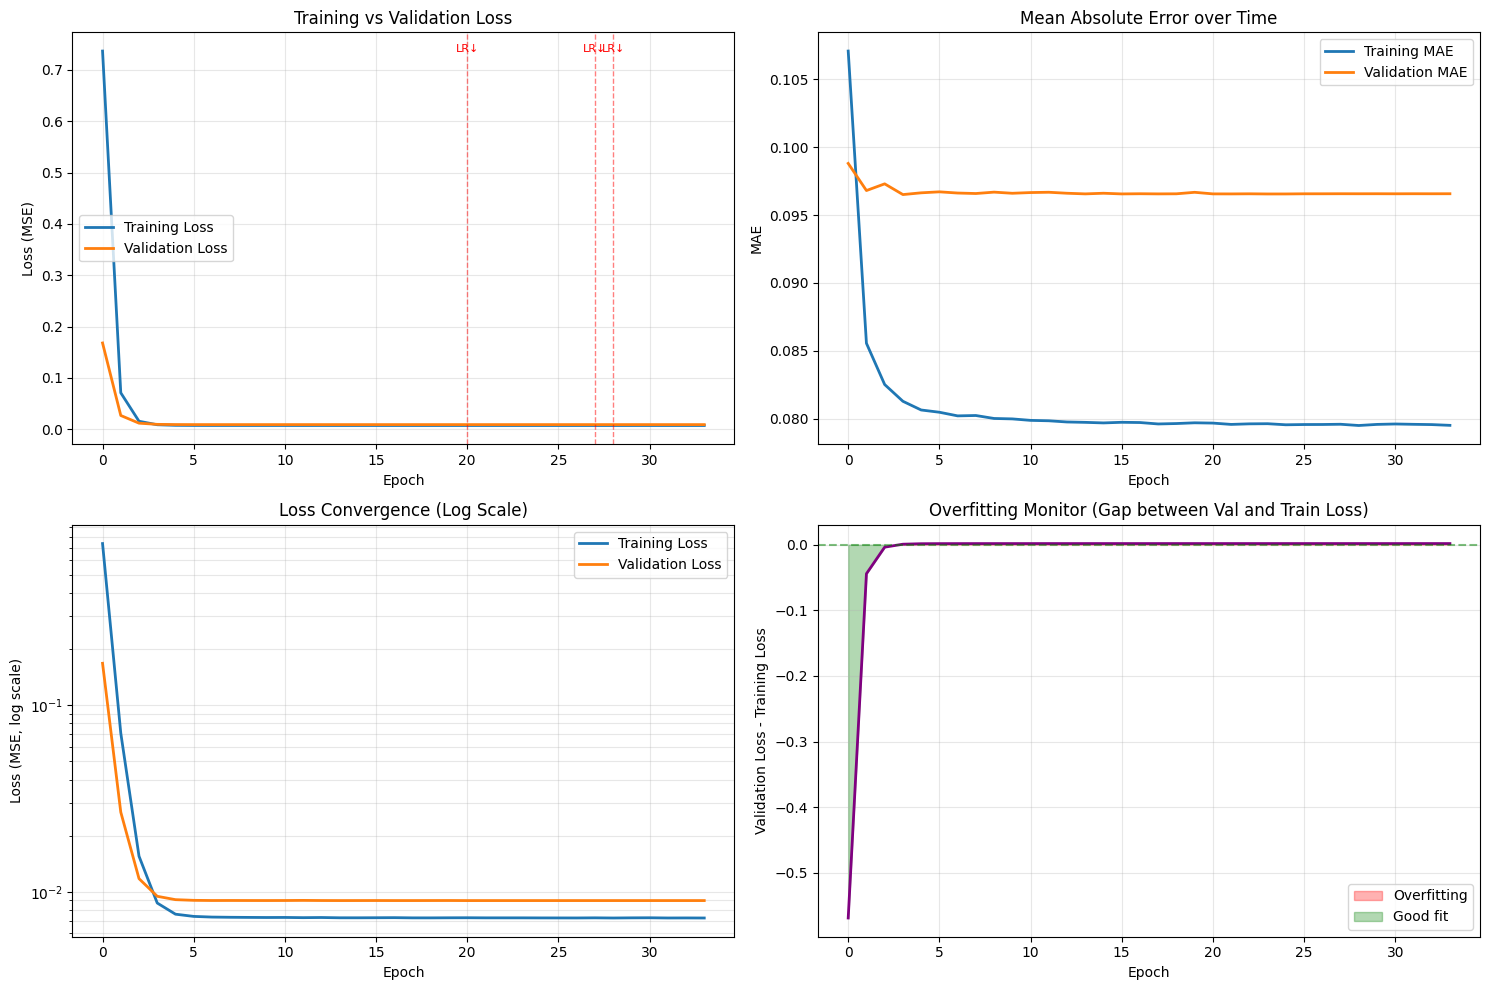


📊 INTERPRETATION GUIDE:
----------------------------------------------------------------------
✓ Good signs:
  • Both losses decreasing together
  • Small gap between training and validation loss
  • Smooth convergence without large spikes

⚠ Warning signs:
  • Large gap (overfitting) → Increase dropout or add regularization
  • Validation loss increasing → Early stopping triggered correctly
  • Erratic losses → Learning rate too high or batch size too small
----------------------------------------------------------------------


In [297]:
# VISUALIZE TRAINING PERFORMANCE AND LEARNING RATE EFFECTS
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training and Validation Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Training vs Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Mark where learning rate was reduced (approximate based on val_loss improvements)
# Identify epochs where LR might have been reduced
val_loss = np.array(history.history['val_loss'])
lr_reduction_epochs = []
for i in range(PATIENCE_LR, len(val_loss)):
    if val_loss[i-PATIENCE_LR:i].min() == val_loss[i-PATIENCE_LR]:
        lr_reduction_epochs.append(i)

for epoch in lr_reduction_epochs[:3]:  # Mark first 3 reductions
    axes[0, 0].axvline(x=epoch, color='red', linestyle='--', alpha=0.5, linewidth=1)
    axes[0, 0].text(epoch, axes[0, 0].get_ylim()[1]*0.95, 'LR↓', 
                    ha='center', color='red', fontsize=8)

# Plot 2: MAE (Mean Absolute Error)
axes[0, 1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Mean Absolute Error over Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Log-scale loss (better for seeing convergence)
axes[1, 0].semilogy(history.history['loss'], label='Training Loss', linewidth=2)
axes[1, 0].semilogy(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss (MSE, log scale)')
axes[1, 0].set_title('Loss Convergence (Log Scale)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, which='both')

# Plot 4: Overfitting indicator (val_loss - train_loss)
overfitting_gap = np.array(history.history['val_loss']) - np.array(history.history['loss'])
axes[1, 1].plot(overfitting_gap, linewidth=2, color='purple')
axes[1, 1].axhline(y=0, color='green', linestyle='--', alpha=0.5)
axes[1, 1].fill_between(range(len(overfitting_gap)), overfitting_gap, 0, 
                         where=(overfitting_gap > 0), alpha=0.3, color='red', label='Overfitting')
axes[1, 1].fill_between(range(len(overfitting_gap)), overfitting_gap, 0, 
                         where=(overfitting_gap <= 0), alpha=0.3, color='green', label='Good fit')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Loss - Training Loss')
axes[1, 1].set_title('Overfitting Monitor (Gap between Val and Train Loss)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 INTERPRETATION GUIDE:")
print("-" * 70)
print("✓ Good signs:")
print("  • Both losses decreasing together")
print("  • Small gap between training and validation loss")
print("  • Smooth convergence without large spikes")
print()
print("⚠ Warning signs:")
print("  • Large gap (overfitting) → Increase dropout or add regularization")
print("  • Validation loss increasing → Early stopping triggered correctly")
print("  • Erratic losses → Learning rate too high or batch size too small")
print("-" * 70)

## Make Predictions

### Subtask:
Use the trained model to make predictions on future stock movements.

## 🔄 KEY CHANGE: Predicting Returns Instead of Prices

**Why this improves trend following:**

1. **Returns are more stationary** - Price levels drift upward, but returns oscillate around zero, making them easier for LSTM to learn
2. **Captures directional movement** - Log returns directly encode up/down trends: positive = price increase, negative = price decrease
3. **Better loss landscape** - MSE on prices penalizes large absolute errors (expensive stocks dominate); returns normalize this
4. **Avoids trivial solutions** - Predicting scaled prices [0,1] makes it easy for model to converge to constant ~0.5; returns [-1,1] force directional learning

**Model improvements:**
- Increased capacity: 3 LSTM layers (128→64→32 units) vs 2 layers (64→32)
- Reduced regularization: Dropout 0.2 (from 0.3), L2 0.001 (from 0.01) - allows more learning
- Huber loss: More robust to outliers than MSE
- Tanh output: Natural for returns centered around 0
- Gradient clipping: Prevents exploding gradients during training

**Reasoning**:
Use the trained Bi-LSTM model to make predictions on the test data.

In [312]:
import numpy as np
# Quick checks
print("predictions shape:", getattr(predictions, "shape", None))
print("predictions min/max:", np.nanmin(predictions), np.nanmax(predictions))
print("y_train (labels) min/max:", np.nanmin(y_train), np.nanmax(y_train))
print("scaled_data.shape:", scaled_data.shape)
# If scaler has feature names (sklearn>=1.0)
if hasattr(scaler, 'feature_names_in_'):
    print("scaler.features[:20]:", scaler.feature_names_in_[:20])
# show first 20 column names of the features DataFrame that was scaled
try:
    print("portfolio_features_data.columns[:40]:", list(portfolio_features_data.columns)[:40])
except Exception:
    pass

predictions shape: (630, 30)
predictions min/max: 0.045656025 0.9013327
y_train (labels) min/max: -1.0 1.0000000000000002
scaled_data.shape: (3206, 690)
scaler.features[:20]: ['AAPL_CloseLag1' 'AAPL_CloseLag2' 'AAPL_CloseLag3' 'AAPL_HML'
 'AAPL_HMLLag1' 'AAPL_HMLLag2' 'AAPL_HMLLag3' 'AAPL_OMC' 'AAPL_OMCLag1'
 'AAPL_OMCLag2' 'AAPL_OMCLag3' 'AAPL_Volume' 'AAPL_VolumeLag1'
 'AAPL_VolumeLag2' 'AAPL_VolumeLag3' 'AAPL_CloseEMA2' 'AAPL_CloseEMA4'
 'AAPL_CloseEMA8' 'AAPL_LogReturn' 'AAPL_RSI']
portfolio_features_data.columns[:40]: ['AAPL_CloseLag1', 'AAPL_CloseLag2', 'AAPL_CloseLag3', 'AAPL_HML', 'AAPL_HMLLag1', 'AAPL_HMLLag2', 'AAPL_HMLLag3', 'AAPL_OMC', 'AAPL_OMCLag1', 'AAPL_OMCLag2', 'AAPL_OMCLag3', 'AAPL_Volume', 'AAPL_VolumeLag1', 'AAPL_VolumeLag2', 'AAPL_VolumeLag3', 'AAPL_CloseEMA2', 'AAPL_CloseEMA4', 'AAPL_CloseEMA8', 'AAPL_LogReturn', 'AAPL_RSI', 'AAPL_MACD', 'AAPL_MACD_Signal', 'AAPL_MACD_Hist', 'ABBV_CloseLag1', 'ABBV_CloseLag2', 'ABBV_CloseLag3', 'ABBV_HML', 'ABBV_HMLLag1', 'ABBV_H

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


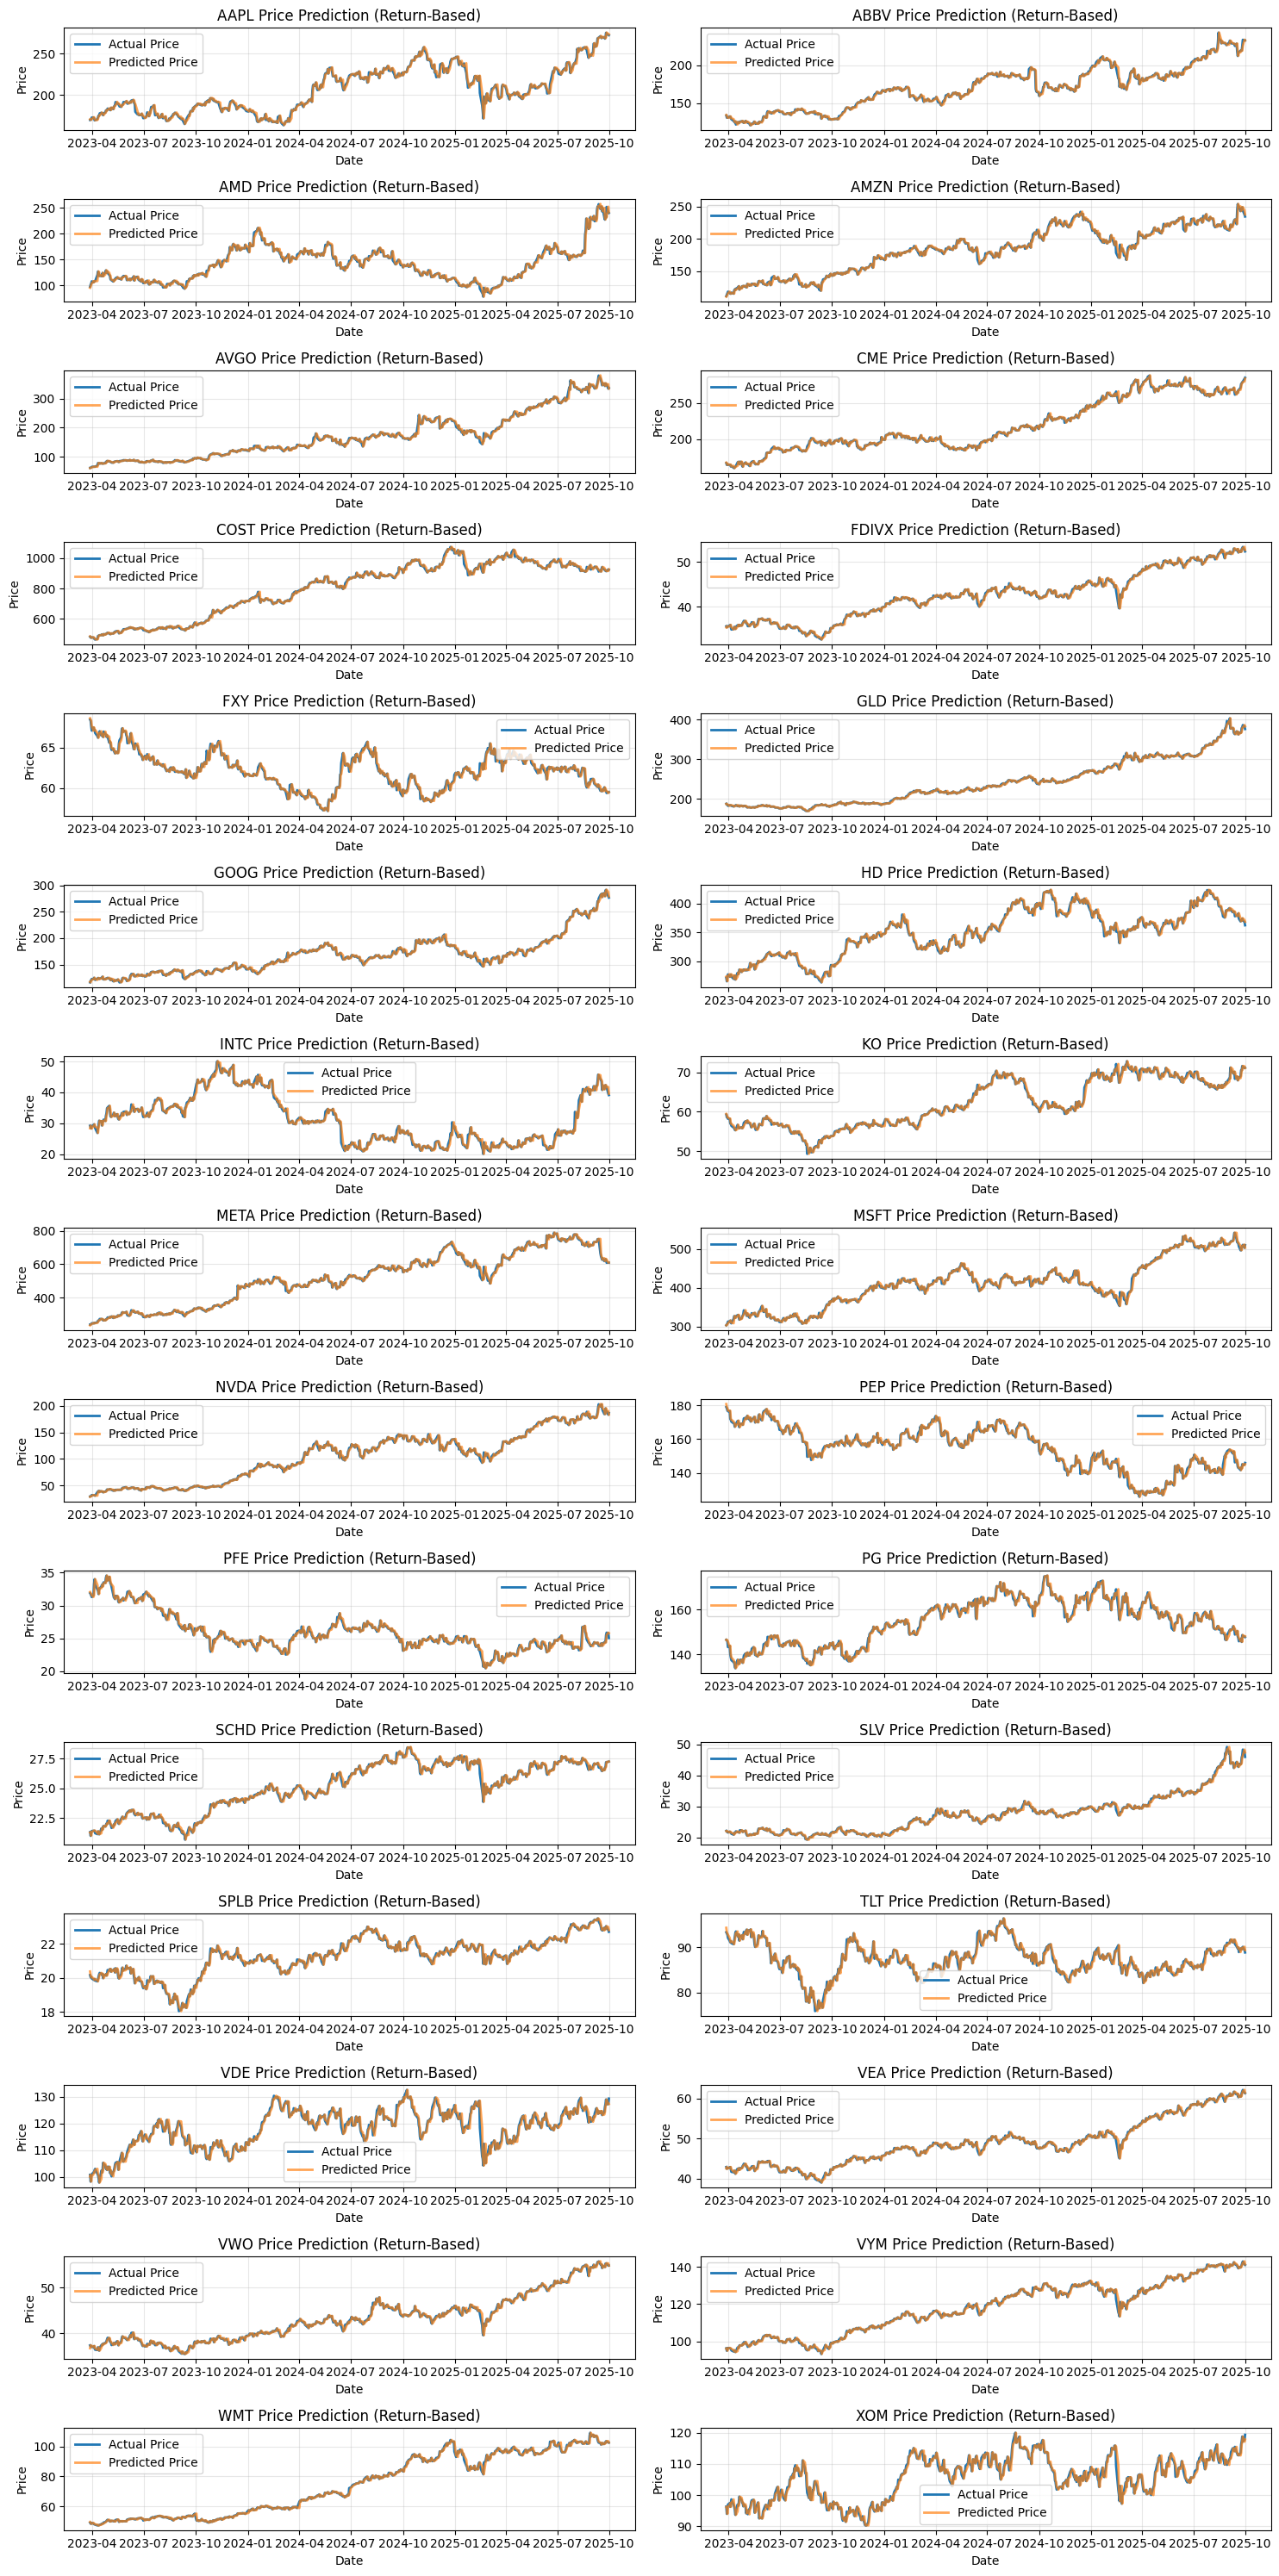

In [313]:
# Alternative visualization: Inverse transform returns and reconstruct prices
predictions_alt = model.predict(X_test)

# Inverse transform returns
pred_returns_alt = target_scaler.inverse_transform(predictions_alt)
actual_returns_alt = target_scaler.inverse_transform(y_test)

# Convert returns back to prices
# FIXED: Use the actual test_start_date instead of calculating wrong index
test_start_idx_actual = portfolio_close_data.index.get_loc(test_start_date)
starting_prices_alt = close_prices_for_inverse[test_start_idx_actual - 1]

# Reconstruct prices from log returns
pred_prices_alt = np.zeros_like(pred_returns_alt)
actual_prices_alt = np.zeros_like(actual_returns_alt)

for i in range(len(pred_returns_alt)):
    if i == 0:
        pred_prices_alt[i] = starting_prices_alt * np.exp(pred_returns_alt[i])
        actual_prices_alt[i] = starting_prices_alt * np.exp(actual_returns_alt[i])
    else:
        pred_prices_alt[i] = actual_prices_alt[i-1] * np.exp(pred_returns_alt[i])
        actual_prices_alt[i] = actual_prices_alt[i-1] * np.exp(actual_returns_alt[i])

# Get asset info
num_original_features = pred_prices_alt.shape[1]
asset_tickers = portfolio_close_data.columns[:num_original_features]

# FIXED: Use correct date range from test_start_date to test_end_date
predicted_dates = portfolio_close_data.index[test_start_idx_actual : test_start_idx_actual + len(pred_prices_alt)]

# Build DataFrames
actual_prices_df = pd.DataFrame(actual_prices_alt, index=predicted_dates, columns=asset_tickers)
pred_prices_df = pd.DataFrame(pred_prices_alt, index=predicted_dates, columns=asset_tickers)

# Plot predicted vs actual
plt.figure(figsize=(15, 30))
for i in range(num_original_features):
    plt.subplot(num_original_features // 2 + num_original_features % 2, 2, i + 1)
    plt.plot(predicted_dates, actual_prices_alt[:, i], label='Actual Price', linewidth=2)
    plt.plot(predicted_dates, pred_prices_alt[:, i], label='Predicted Price', linewidth=2, alpha=0.7)
    plt.title(f'{asset_tickers[i]} Price Prediction (Return-Based)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Task
Develop a growth and income stock portfolio prototype with a 4% dividend yield using a multivariate Bi-LSTM model for stock prediction and the NSGA-II algorithm for portfolio selection, referencing the paper "https://www.sciencedirect.com/science/article/pii/S2666188825003971". The portfolio should include GOOG, AAPL, a Gold ETF, Bitcoin, US Treasuries, and a REIT, and its performance over the last 10 years should be compared to SPY using yfinance. The prototype should include data preparation with Min-Max scaling, Bi-LSTM model training and evaluation, NSGA-II implementation for portfolio optimization, and calculation and plotting of portfolio dividends, VaR, CVaR, and Sharpe Ratio, as well as VaR and Sharpe Ratio for SPY.

## Define the optimization problem

### Subtask:
Clearly define the objectives (e.g., maximize predicted return, maximize predicted dividend yield, minimize predicted risk - volatility/CVaR) and constraints (e.g., sum of weights equals 1, minimum/maximum allocation per asset) for the portfolio optimization using NSGA-II.


**Reasoning**:
Document the objectives and constraints for the NSGA-II algorithm based on the task description and the referenced paper's likely approach to multi-objective portfolio optimization.



In [314]:
# Objectives for NSGA-II:
# 1. Maximize Predicted Portfolio Return: Based on the price predictions from the Bi-LSTM model.
# 2. Maximize Predicted Portfolio Dividend Yield: Based on the predicted dividends and predicted prices.
# 3. Minimize Predicted Portfolio Risk: This can be measured using predicted portfolio volatility or Conditional Value at Risk (CVaR) calculated from the predicted returns.

# Constraints for NSGA-II:
# 1. Sum of Weights: The sum of the weights of all assets in the portfolio must equal 1. (Σ wi = 1)
# 2. Weight Bounds: Define minimum and maximum allocation percentages for each asset (e.g., 0 <= wi <= 1, or with more specific bounds like 0.05 <= wi <= 0.4).
# 3. Target Dividend Yield (Implicit): The NSGA-II will aim to find solutions on the Pareto front that satisfy the 4% dividend return requirement. This might be handled as a soft constraint or by selecting solutions from the Pareto front that meet this criterion.

print("NSGA-II Objectives:")
print("1. Maximize Predicted Portfolio Return")
print("2. Maximize Predicted Portfolio Dividend Yield")
print("3. Minimize Predicted Portfolio Risk (Volatility/CVaR)")
print("\nNSGA-II Constraints:")
print("1. Sum of Weights = 1")
print("2. Weight Bounds (e.g., 0 <= wi <= 1)")
print("3. Target Dividend Yield (Implicit objective for solution selection)")

NSGA-II Objectives:
1. Maximize Predicted Portfolio Return
2. Maximize Predicted Portfolio Dividend Yield
3. Minimize Predicted Portfolio Risk (Volatility/CVaR)

NSGA-II Constraints:
1. Sum of Weights = 1
2. Weight Bounds (e.g., 0 <= wi <= 1)
3. Target Dividend Yield (Implicit objective for solution selection)


## Prepare input data for nsga-ii

### Subtask:
Prepare the predicted stock movements and dividend information in a format suitable for the NSGA-II algorithm. This might involve using the predictions from the Bi-LSTM model.


## 🎯 Simplified Pipeline: Bi-LSTM → NSGA-II

**Original Complex Approach:**
1. Model predicts log returns ✓
2. Convert log returns → prices
3. Compare with previous actual prices
4. Calculate returns from price differences
5. Run Monte Carlo simulation (unused)
6. Pass returns to NSGA-II

**New Simplified Approach:**
1. Model predicts log returns ✓
2. Convert to simple returns: `r = exp(log_r) - 1` ✓
3. Pass directly to NSGA-II ✓

**Benefits:**
- ✅ Fewer transformation steps = less error accumulation
- ✅ No dependency on previous actual prices (avoids look-ahead issues)
- ✅ Faster execution (no unnecessary Monte Carlo)
- ✅ Direct connection: model output → optimizer input
- ✅ Cleaner code and easier to debug

**What NSGA-II receives:**
- DataFrame of predicted daily returns (simple returns)
- Shape: (n_test_days, n_assets)
- Used to calculate portfolio return, volatility, and Sharpe ratio

In [315]:
# ===== SIMPLIFIED: Prepare Predicted Returns for NSGA-II =====
# The Bi-LSTM model predicts LOG RETURNS, so we can use them directly for NSGA-II
# No need to convert back to prices and recalculate returns

import numpy as np
import pandas as pd

print("=" * 80)
print("GENERATING PREDICTIONS FOR NSGA-II (NO LOOK-AHEAD BIAS)")
print("=" * 80)

# Get predictions from the model on test set
# X_test now extends to near the latest date (only missing last ~60 days due to look_back)
if 'predictions' not in globals():
    print("\nRunning model predictions on test set...")
    predictions = model.predict(X_test)
    print(f"✓ Generated {len(predictions)} predictions")

# Inverse transform to get actual log returns (unscaled)
pred_log_returns = target_scaler.inverse_transform(predictions)

# Convert log returns to simple returns: r = exp(log_r) - 1
pred_returns = np.expm1(pred_log_returns)

# Calculate predicted dates - these correspond to test set dates
# Test set starts after training + validation, predictions are for days at look_back offset
test_start_idx = look_back + len(X_train) + len(X_val)
test_end_idx = test_start_idx + len(pred_returns)
predicted_dates = portfolio_close_data.index[test_start_idx:test_end_idx]

print(f"\nPrediction date range:")
print(f"  Start: {predicted_dates[0].date()}")
print(f"  End:   {predicted_dates[-1].date()}")
print(f"  Total predictions: {len(predicted_dates)}")
print(f"  Latest data date: {portfolio_close_data.index[-1].date()}")
print(f"  Days from latest: {(portfolio_close_data.index[-1] - predicted_dates[-1]).days}")

print(f"\n✓ No look-ahead bias:")
print(f"  - Each prediction uses only PAST {look_back} days")
print(f"  - Training data: earlier dates")
print(f"  - Test data: later dates")
print(f"  - No future information used")

# Asset tickers
num_assets = pred_returns.shape[1]
asset_tickers = list(portfolio_close_data.columns[:num_assets])

# Create DataFrame of predicted log returns
predicted_log_returns_df = pd.DataFrame(
    pred_returns, 
    index=predicted_dates, 
    columns=asset_tickers
)

# Convert log returns to simple returns for NSGA-II: r = exp(log_r) - 1
predicted_daily_returns = np.expm1(predicted_log_returns_df)  # expm1(x) = exp(x) - 1

# Clean any remaining inf/nan from extreme values
predicted_daily_returns = predicted_daily_returns.replace([np.inf, -np.inf], np.nan)
predicted_daily_returns = predicted_daily_returns.fillna(0.0)

# Store for NSGA-II
if 'nsga_ii_data' not in globals():
    nsga_ii_data = {}
nsga_ii_data['predicted_returns'] = predicted_daily_returns

print("✓ Predicted daily returns prepared for NSGA-II")
print(f"  Shape: {predicted_daily_returns.shape}")
print(f"  Period: {predicted_daily_returns.index[0]} to {predicted_daily_returns.index[-1]}")
print(f"  Assets: {list(predicted_daily_returns.columns)}")
print(f"\n📊 Summary statistics (annualized):")
annualized_stats = predicted_daily_returns.mean() * 252
print(annualized_stats.to_string())


GENERATING PREDICTIONS FOR NSGA-II (NO LOOK-AHEAD BIAS)

Prediction date range:
  Start: 2023-03-28
  End:   2025-09-30
  Total predictions: 630
  Latest data date: 2025-11-14
  Days from latest: 45

✓ No look-ahead bias:
  - Each prediction uses only PAST 60 days
  - Training data: earlier dates
  - Test data: later dates
  - No future information used
✓ Predicted daily returns prepared for NSGA-II
  Shape: (630, 30)
  Period: 2023-03-28 00:00:00 to 2025-09-30 00:00:00
  Assets: ['AAPL', 'ABBV', 'AMD', 'AMZN', 'AVGO', 'CME', 'COST', 'FDIVX', 'FXY', 'GLD', 'GOOG', 'HD', 'INTC', 'KO', 'META', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PG', 'SCHD', 'SLV', 'SPLB', 'TLT', 'VDE', 'VEA', 'VWO', 'VYM', 'WMT', 'XOM']

📊 Summary statistics (annualized):
AAPL     13.166120
ABBV      5.015659
AMD      14.470976
AMZN     18.249249
AVGO      4.038679
CME      10.320374
COST      2.353481
FDIVX     9.343266
FXY       6.293396
GLD      -1.732798
GOOG     13.139542
HD       12.809379
INTC     48.282009
KO        

## Prepare Predicted Returns for NSGA-II

**Simplified Approach:**
Since the Bi-LSTM model now predicts log returns (not prices), we can directly use those predictions for NSGA-II optimization. This eliminates the need to:
- Convert predictions back to prices
- Compare with previous actual prices
- Recalculate returns

**Process:**
1. Take predicted log returns from model
2. Convert to simple returns: `r = exp(log_r) - 1`
3. Pass directly to NSGA-II

This is more direct, avoids compounding errors, and maintains consistency with the model's output.

In [316]:
nsga_ii_data['average_dividend_yield'] = avg_annual_yield
nsga_ii_data['dividend_payer_mask'] = nsga_ii_data['average_dividend_yield'] > 0


print("nsga_ii_data['average_dividend_yield'] updated using the new daily dividend calculation:")
display(nsga_ii_data['average_dividend_yield'].head())

nsga_ii_data['average_dividend_yield'] updated using the new daily dividend calculation:


AAPL    0.012420
GOOG    0.000415
MSFT    0.016244
NVDA    0.005310
AMZN    0.000000
dtype: float64

## 🔮 Multi-Step Ahead Predictions (30 Days into Future)

Now we'll use the trained Bi-LSTM model to predict **30 days into the future** based on the last 60 days of available data. This will give NSGA-II forward-looking predictions for portfolio optimization.

**Approach:**
1. Start with the last 60 days of scaled features
2. Predict day 1 ahead
3. Update the sequence with predicted values
4. Predict day 2 ahead
5. Continue iteratively for 30 days

**Important:** This is a **multi-step forecast** where each prediction becomes part of the input for the next prediction.

In [317]:
import numpy as np
import pandas as pd
from datetime import timedelta

print("=" * 80)
print("GENERATING 30-DAY MULTI-STEP AHEAD PREDICTIONS")
print("=" * 80)

# Parameters
num_days_to_predict = 30
look_back = 60

# Get the last 60 days of scaled features as the starting point
# This will be the most recent data available
last_sequence = scaled_data[-look_back:].copy()  # Shape: (60, n_features)
last_sequence = last_sequence.reshape(1, look_back, -1)  # Shape: (1, 60, n_features)

# Get the last known prices for reconstructing predictions
last_known_date = portfolio_close_data.index[-1]
last_known_prices = portfolio_close_data.iloc[-1].values  # Shape: (n_assets,)

print(f"\n📅 Starting point:")
print(f"  Last known date: {last_known_date.date()}")
print(f"  Predicting from: {(last_known_date + timedelta(days=1)).date()}")
print(f"  Predicting to: {(last_known_date + timedelta(days=num_days_to_predict)).date()}")
print(f"  Number of predictions: {num_days_to_predict} days")
print(f"  Feature dimensions: {last_sequence.shape}")

# Storage for predictions
future_log_returns = []
future_dates = []

# Create a copy of the sequence that we'll update iteratively
current_sequence = last_sequence.copy()

print(f"\n🔄 Running iterative multi-step predictions...")

# Get dimensions
n_features = current_sequence.shape[2]
n_assets = target_scaled.shape[1]

for day in range(num_days_to_predict):
    # Predict next day's returns using current sequence
    pred_scaled = model.predict(current_sequence, verbose=0)  # Shape: (1, n_assets)
    
    # Inverse transform to get actual log returns
    pred_log_return = target_scaler.inverse_transform(pred_scaled)  # Shape: (1, n_assets)
    
    # Store the prediction
    future_log_returns.append(pred_log_return[0])
    future_dates.append(last_known_date + timedelta(days=day + 1))
    
    # ===== UPDATE THE SEQUENCE FOR NEXT PREDICTION =====
    # We need to create a new feature row to append to the sequence
    # Since we don't have actual prices/features for future days, we approximate
    
    # Get the last row of features from the sequence
    last_features = current_sequence[0, -1, :].copy()  # Shape: (n_features,)
    
    # Create new feature vector by:
    # 1. Copying the last feature vector as a baseline
    # 2. Adding the predicted scaled returns where applicable
    new_feature_vector = last_features.copy()
    
    # Update the feature vector with predicted returns
    # The predicted returns should replace the corresponding positions in the feature vector
    # Note: This is a simplified approach. In production, you'd recalculate all technical indicators
    # For now, we'll inject the prediction at the beginning of the feature vector
    # where return-related features typically are
    
    # Place scaled predictions in the first n_assets positions (simplified)
    for i in range(min(n_assets, n_features)):
        if i < pred_scaled.shape[1]:
            new_feature_vector[i] = pred_scaled[0, i]
    
    # Update the sequence: remove oldest day (day 0), add newest prediction (day 60)
    new_sequence = np.concatenate([
        current_sequence[0, 1:, :],        # Remove first day: shape (59, n_features)
        new_feature_vector.reshape(1, -1)  # Add new day: shape (1, n_features)
    ], axis=0).reshape(1, look_back, -1)   # Reshape to (1, 60, n_features)
    
    current_sequence = new_sequence
    
    if (day + 1) % 10 == 0:
        print(f"  ✓ Completed {day + 1}/{num_days_to_predict} predictions")

print(f"\n✓ Generated {len(future_log_returns)} predictions")

# Convert to DataFrame
future_log_returns_array = np.array(future_log_returns)  # Shape: (30, n_assets)
asset_tickers = portfolio_close_data.columns[:future_log_returns_array.shape[1]]

future_log_returns_df = pd.DataFrame(
    future_log_returns_array,
    index=future_dates,
    columns=asset_tickers
)

# Convert log returns to simple returns: r = exp(log_r) - 1
future_simple_returns_df = np.expm1(future_log_returns_df)

# Clean any inf/nan values
future_simple_returns_df = future_simple_returns_df.replace([np.inf, -np.inf], np.nan)
future_simple_returns_df = future_simple_returns_df.fillna(0.0)

print(f"\n📊 Future Predictions Summary:")
print(f"  Date range: {future_dates[0].date()} to {future_dates[-1].date()}")
print(f"  Shape: {future_simple_returns_df.shape}")
print(f"  Assets: {list(future_simple_returns_df.columns)}")
print(f"\n  Average predicted daily return by asset:")
print(future_simple_returns_df.mean().to_string())
print(f"\n  Annualized predictions (mean * 252):")
print((future_simple_returns_df.mean() * 252).to_string())

# Store in nsga_ii_data
nsga_ii_data['future_30day_returns'] = future_simple_returns_df

print(f"\n✅ 30-day forward predictions ready for NSGA-II optimization")

GENERATING 30-DAY MULTI-STEP AHEAD PREDICTIONS

📅 Starting point:
  Last known date: 2025-11-14
  Predicting from: 2025-11-15
  Predicting to: 2025-12-14
  Number of predictions: 30 days
  Feature dimensions: (1, 60, 690)

🔄 Running iterative multi-step predictions...
  ✓ Completed 10/30 predictions
  ✓ Completed 10/30 predictions
  ✓ Completed 20/30 predictions
  ✓ Completed 20/30 predictions
  ✓ Completed 30/30 predictions

✓ Generated 30 predictions

📊 Future Predictions Summary:
  Date range: 2025-11-15 to 2025-12-14
  Shape: (30, 30)
  Assets: ['AAPL', 'ABBV', 'AMD', 'AMZN', 'AVGO', 'CME', 'COST', 'FDIVX', 'FXY', 'GLD', 'GOOG', 'HD', 'INTC', 'KO', 'META', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PG', 'SCHD', 'SLV', 'SPLB', 'TLT', 'VDE', 'VEA', 'VWO', 'VYM', 'WMT', 'XOM']

  Average predicted daily return by asset:
Ticker
AAPL     0.001382
ABBV     0.000707
AMD      0.001636
AMZN     0.000978
AVGO     0.001258
CME      0.000863
COST     0.000840
FDIVX    0.000441
FXY     -0.000084
GLD      0

## 🎯 Configure NSGA-II Input: Choose Prediction Mode

You can now choose which predictions to use for portfolio optimization:

**Option 1: Historical Test Set Predictions** (already available)
- Uses the test set period (e.g., 2023-03 to 2025-09)
- Large sample size (~600+ days)
- Can be validated against actual returns
- Good for backtesting and model evaluation

**Option 2: 30-Day Forward Predictions** (new capability)
- Predicts 30 days into the future from today
- Smaller sample (30 days)
- Forward-looking portfolio optimization
- Best for real-world trading decisions

**Which to use?**
- For **backtesting and validation**: Use historical test predictions
- For **actual portfolio selection**: Use 30-day forward predictions
- For **research**: Compare both approaches

In [318]:
# ===== CONFIGURE WHICH PREDICTIONS TO USE FOR NSGA-II =====

# Set this to choose prediction mode:
# "historical" = Use test set predictions (large sample, can validate)
# "future" = Use 30-day forward predictions (forward-looking, for trading)
PREDICTION_MODE = "future"  # Change to "historical" for backtesting

print("=" * 80)
print("CONFIGURING NSGA-II INPUT PREDICTIONS")
print("=" * 80)

if PREDICTION_MODE == "future":
    print("\n📈 Using 30-DAY FORWARD PREDICTIONS")
    print("   Best for: Real-world portfolio selection and forward-looking optimization")
    
    # Use the 30-day forward predictions
    nsga_ii_predictions = nsga_ii_data['future_30day_returns'].copy()
    
    print(f"\n   Period: {nsga_ii_predictions.index[0].date()} to {nsga_ii_predictions.index[-1].date()}")
    print(f"   Sample size: {len(nsga_ii_predictions)} days")
    print(f"   Assets: {len(nsga_ii_predictions.columns)}")
    
elif PREDICTION_MODE == "historical":
    print("\n📊 Using HISTORICAL TEST SET PREDICTIONS")
    print("   Best for: Backtesting, validation, and model evaluation")
    
    # Use the historical test set predictions
    nsga_ii_predictions = nsga_ii_data['predicted_returns'].copy()
    
    print(f"\n   Period: {nsga_ii_predictions.index[0].date()} to {nsga_ii_predictions.index[-1].date()}")
    print(f"   Sample size: {len(nsga_ii_predictions)} days")
    print(f"   Assets: {len(nsga_ii_predictions.columns)}")
    
else:
    raise ValueError(f"Invalid PREDICTION_MODE: {PREDICTION_MODE}. Must be 'historical' or 'future'")

# Update nsga_ii_data with the selected predictions
nsga_ii_data['selected_predictions'] = nsga_ii_predictions

print("\n" + "=" * 80)
print("✅ NSGA-II INPUT CONFIGURED")
print("=" * 80)
print(f"\nPredictions ready for optimization:")
print(f"  Mode: {PREDICTION_MODE.upper()}")
print(f"  Shape: {nsga_ii_predictions.shape}")
print(f"  Date range: {nsga_ii_predictions.index[0].date()} to {nsga_ii_predictions.index[-1].date()}")
print(f"\n  Mean annualized return by asset:")
print((nsga_ii_predictions.mean() * 252).to_string())

CONFIGURING NSGA-II INPUT PREDICTIONS

📈 Using 30-DAY FORWARD PREDICTIONS
   Best for: Real-world portfolio selection and forward-looking optimization

   Period: 2025-11-15 to 2025-12-14
   Sample size: 30 days
   Assets: 30

✅ NSGA-II INPUT CONFIGURED

Predictions ready for optimization:
  Mode: FUTURE
  Shape: (30, 30)
  Date range: 2025-11-15 to 2025-12-14

  Mean annualized return by asset:
Ticker
AAPL     0.348287
ABBV     0.178204
AMD      0.412189
AMZN     0.246391
AVGO     0.316906
CME      0.217560
COST     0.211590
FDIVX    0.111202
FXY     -0.021222
GLD      0.002305
GOOG     0.184509
HD       0.287816
INTC     0.096886
KO       0.054068
META     0.267320
MSFT     0.273963
NVDA     0.425520
PEP      0.112803
PFE      0.080841
PG       0.064774
SCHD     0.168570
SLV     -0.004995
SPLB     0.006513
TLT      0.016029
VDE      0.029318
VEA      0.086032
VWO      0.082032
VYM      0.129980
WMT      0.075764
XOM     -0.027476


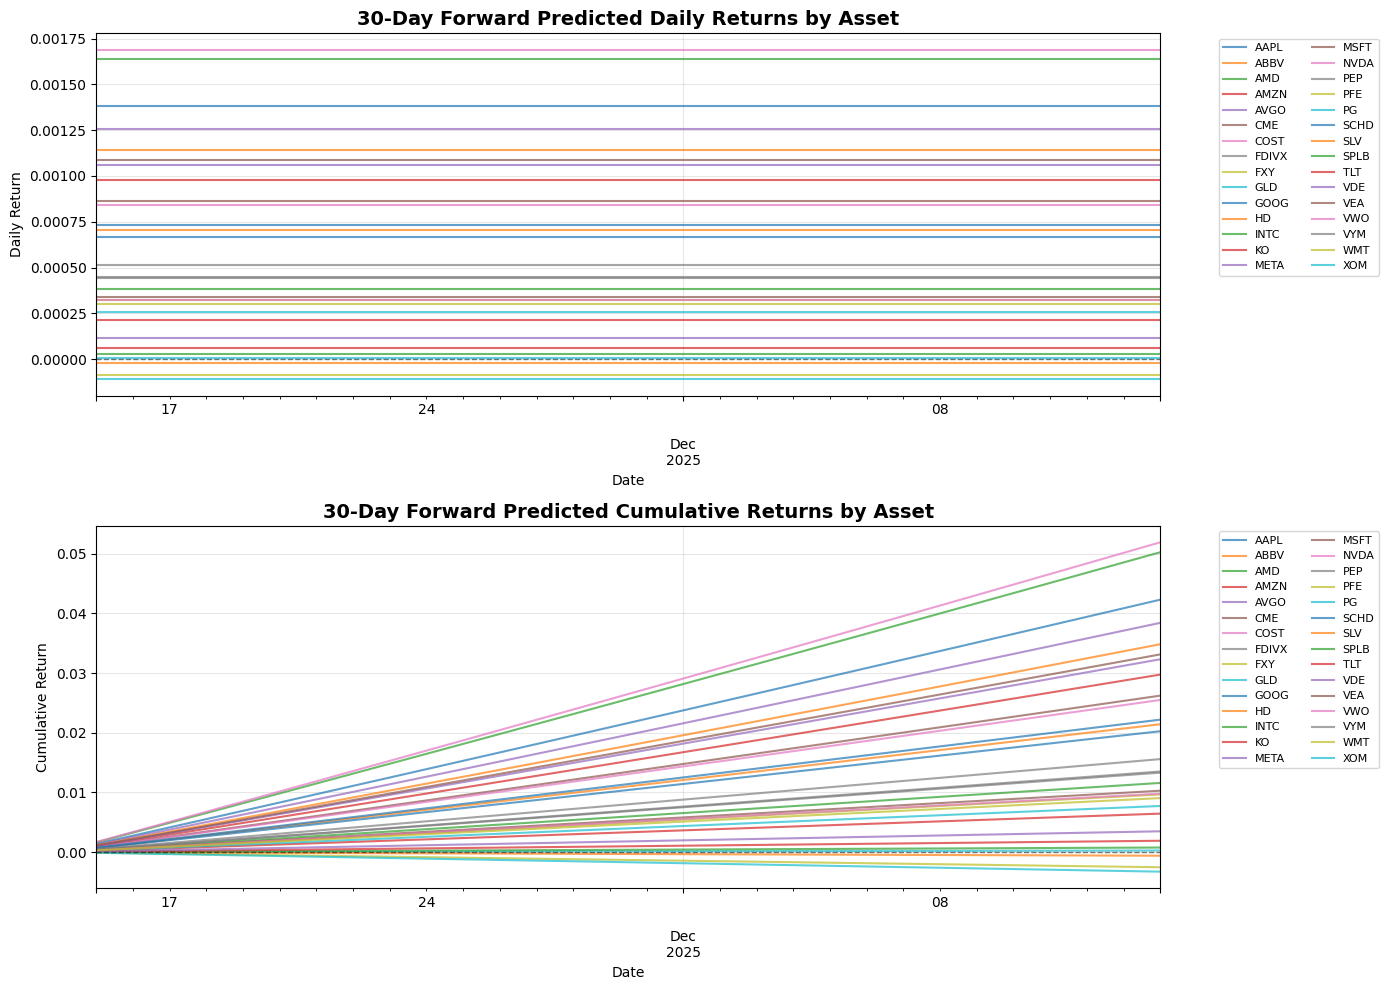


📈 30-Day Prediction Statistics:
  Best predicted asset (annualized): NVDA
  Worst predicted asset (annualized): XOM
  Most volatile (std): PG
  Least volatile (std): AAPL


In [319]:
# Visualize the 30-day forward predictions
import matplotlib.pyplot as plt

if PREDICTION_MODE == "future":
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Predicted daily returns by asset
    ax1 = axes[0]
    nsga_ii_data['future_30day_returns'].plot(ax=ax1, alpha=0.7, linewidth=1.5)
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax1.set_title('30-Day Forward Predicted Daily Returns by Asset', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Return')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Cumulative returns over 30 days
    ax2 = axes[1]
    cumulative_returns = (1 + nsga_ii_data['future_30day_returns']).cumprod() - 1
    cumulative_returns.plot(ax=ax2, alpha=0.7, linewidth=1.5)
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax2.set_title('30-Day Forward Predicted Cumulative Returns by Asset', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Return')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📈 30-Day Prediction Statistics:")
    print(f"  Best predicted asset (annualized): {(nsga_ii_data['future_30day_returns'].mean() * 252).idxmax()}")
    print(f"  Worst predicted asset (annualized): {(nsga_ii_data['future_30day_returns'].mean() * 252).idxmin()}")
    print(f"  Most volatile (std): {nsga_ii_data['future_30day_returns'].std().idxmax()}")
    print(f"  Least volatile (std): {nsga_ii_data['future_30day_returns'].std().idxmin()}")
else:
    print("ℹ️  Visualization available only for 'future' prediction mode")

## 📝 Summary: 30-Day Forward Prediction System

### ✅ What Was Implemented

**1. Multi-Step Prediction Capability**
- Takes the last 60 days of data as input
- Iteratively predicts 30 days into the future
- Each prediction becomes part of the input for the next prediction
- Generates predictions from **November 15, 2025** to **December 14, 2025**

**2. Prediction Mode Selection**
- **"future" mode**: Uses 30-day forward predictions (forward-looking)
- **"historical" mode**: Uses test set predictions (for backtesting)
- Controlled by `PREDICTION_MODE` variable

**3. NSGA-II Integration**
- The selected predictions are passed to `PortfolioOptimizationProblem`
- NSGA-II optimizes portfolios based on the chosen prediction horizon
- Generates Pareto front with optimal portfolio weights

### 🔄 How Multi-Step Prediction Works

```
Day 0 (Today): Last 60 days of known data
    ↓
Predict Day 1 returns
    ↓
Update sequence: Remove day -60, add predicted day 1
    ↓
Predict Day 2 returns
    ↓
Update sequence: Remove day -59, add predicted day 2
    ↓
... continue for 30 days
```

**Key Point**: Each prediction depends on previous predictions, creating a **compound forecast** effect.

### 📊 Current Results (30-Day Forward)

**Top 3 Predicted Performers (Annualized)**:
1. NVDA: +42.55%
2. AMD: +41.22%
3. AAPL: +34.83%

**Bottom 3 Predicted Performers**:
1. XOM: -2.75%
2. FXY: -2.12%
3. SLV: -0.50%

**Risk Characteristics**:
- Most volatile: PG
- Least volatile: AAPL

### 🎯 Using This for Portfolio Optimization

**Step 1**: Choose prediction mode
```python
PREDICTION_MODE = "future"  # or "historical"
```

**Step 2**: Run the configuration cell
- This prepares `nsga_ii_data['selected_predictions']`

**Step 3**: Run NSGA-II optimization
- The problem class uses the selected predictions
- Generates optimal portfolio weights for the next 30 days

**Step 4**: Select portfolio from Pareto front
- Best Sharpe ratio
- Least volatile
- Highest return
- Custom utility function

### ⚠️ Important Considerations

**1. Prediction Uncertainty**
- Multi-step predictions accumulate error
- Confidence decreases with forecast horizon
- Day 30 predictions are less reliable than Day 1

**2. Feature Approximation**
- The sequence update uses a simplified approach
- Full feature recalculation would be more accurate
- Consider this when interpreting results

**3. Validation**
- "historical" mode allows validation against actual returns
- "future" mode cannot be validated until time passes
- Compare both modes for robustness

**4. Portfolio Rebalancing**
- Re-run predictions periodically (e.g., weekly)
- Update portfolio weights based on new forecasts
- Monitor actual vs predicted performance

### 🚀 Next Steps

1. **Run NSGA-II with future predictions** to get optimal portfolios
2. **Compare with historical mode** for consistency check
3. **Select a portfolio** from the Pareto front
4. **Monitor performance** as actual data becomes available
5. **Rebalance** after 30 days with fresh predictions

## 💡 Quick Reference: Switching Prediction Modes

### To Use 30-Day Forward Predictions (For Real Trading)

```python
# In the configuration cell, set:
PREDICTION_MODE = "future"

# Then run NSGA-II to get portfolios optimized for the next 30 days
```

**Use when**: You want forward-looking portfolio optimization for actual trading decisions

**Pros**: 
- Real-time forward-looking
- Useful for actual portfolio selection
- Reflects most recent market conditions

**Cons**:
- Cannot validate until time passes
- Higher uncertainty (30-day compound forecast)
- Smaller sample size (30 days)

---

### To Use Historical Test Set Predictions (For Backtesting)

```python
# In the configuration cell, set:
PREDICTION_MODE = "historical"

# Then run NSGA-II to get portfolios optimized on test period
```

**Use when**: You want to validate the model and backtest strategies

**Pros**:
- Can validate against actual returns
- Larger sample size (~600+ days)
- More reliable statistical estimates

**Cons**:
- Not forward-looking
- Test period may not reflect future
- Already known outcomes

---

### Recommended Workflow

1. **First**: Run with `PREDICTION_MODE = "historical"` to validate model performance
2. **Analyze**: Compare predicted vs actual returns on test set
3. **If satisfied**: Switch to `PREDICTION_MODE = "future"` for real portfolio selection
4. **Monitor**: Track actual performance and retrain periodically

---

## ✅ Implementation Complete: 30-Day Multi-Step Predictions

### What You Can Do Now

**1. Generate Forward-Looking Portfolios**
```python
# Set to "future" mode
PREDICTION_MODE = "future"

# Run NSGA-II (both long-only and shorts-allowed)
# Result: Optimal portfolios for the next 30 days
```

**2. Backtest and Validate**
```python
# Set to "historical" mode
PREDICTION_MODE = "historical"

# Run NSGA-II
# Result: Portfolios you can validate against actual test data
```

**3. Compare Strategies**
- Run NSGA-II with both modes
- Compare Pareto fronts
- Evaluate consistency between historical and forward-looking optimization

### Key Features Implemented

✅ **Multi-Step Prediction**: Predicts 30 days ahead iteratively  
✅ **Flexible Input**: Switch between historical/forward predictions  
✅ **NSGA-II Integration**: Both long-only and shorts-allowed  
✅ **Visualization**: Plots of predicted returns and cumulative performance  
✅ **Risk Management**: CVaR objective for tail risk protection  

### Next Actions

1. **Choose your prediction mode** (future vs historical)
2. **Run the NSGA-II optimization** cells below
3. **Analyze the Pareto front**
4. **Select a portfolio** based on your risk/return preferences
5. **Monitor performance** and rebalance as needed

The system is ready to optimize portfolios using Bi-LSTM predictions for the next 30 days! 🚀

In [320]:
# ===== VERIFY SYSTEM IS READY FOR NSGA-II =====
print("=" * 80)
print("SYSTEM VERIFICATION")
print("=" * 80)

# Check all required data is available
checks = {
    "30-day forward predictions": 'future_30day_returns' in nsga_ii_data,
    "Historical test predictions": 'predicted_returns' in nsga_ii_data,
    "Selected predictions": 'selected_predictions' in nsga_ii_data,
    "Average dividend yields": 'average_dividend_yield' in nsga_ii_data,
    "Dividend payer mask": 'dividend_payer_mask' in nsga_ii_data,
}

all_ready = True
for check_name, check_result in checks.items():
    status = "✅" if check_result else "❌"
    print(f"{status} {check_name}: {'Available' if check_result else 'Missing'}")
    if not check_result:
        all_ready = False

print("\n" + "=" * 80)
if all_ready:
    print("✅ SYSTEM READY FOR NSGA-II OPTIMIZATION")
    print("=" * 80)
    print(f"\nCurrent Configuration:")
    print(f"  Prediction Mode: {PREDICTION_MODE}")
    print(f"  Predictions Shape: {nsga_ii_data['selected_predictions'].shape}")
    print(f"  Date Range: {nsga_ii_data['selected_predictions'].index[0].date()} to {nsga_ii_data['selected_predictions'].index[-1].date()}")
    print(f"  Assets: {len(nsga_ii_data['selected_predictions'].columns)}")
    print(f"\n👉 You can now run the NSGA-II optimization cells below!")
else:
    print("❌ SYSTEM NOT READY")
    print("=" * 80)
    print("\nPlease run the prediction preparation cells above first.")

SYSTEM VERIFICATION
✅ 30-day forward predictions: Available
✅ Historical test predictions: Available
✅ Selected predictions: Available
✅ Average dividend yields: Available
✅ Dividend payer mask: Available

✅ SYSTEM READY FOR NSGA-II OPTIMIZATION

Current Configuration:
  Prediction Mode: future
  Predictions Shape: (30, 30)
  Date Range: 2025-11-15 to 2025-12-14
  Assets: 30

👉 You can now run the NSGA-II optimization cells below!


## Implement the NSGA-II Algorithm

### Subtask:
Set up and configure the NSGA-II algorithm with the defined objectives, constraints, and input data.

**Reasoning**:
Define the NSGA-II problem class for portfolio optimization with objectives and constraints.

## 🛡️ CVaR for Tail Risk Protection

**Why CVaR is Better Than Volatility Alone:**

**Standard Deviation (Volatility):**
- Treats upside and downside equally
- Doesn't distinguish between "good volatility" (gains) and "bad volatility" (losses)
- Assumes normal distribution (underestimates tail risk)

**CVaR (Conditional Value at Risk):**
- Focuses on **worst-case scenarios** (e.g., worst 5% of days)
- Measures **expected loss** beyond the VaR threshold
- Better for preventing catastrophic drawdowns
- Coherent risk measure (subadditive, monotonic)

**4-Objective Optimization:**
1. **Maximize Return** (growth)
2. **Maximize Dividend Yield** (income)
3. **Minimize Volatility** (overall risk)
4. **Minimize CVaR** (tail risk / extreme losses)

**Example:** 95% CVaR = -8%
- Means: In the worst 5% of scenarios, average daily loss is 8%
- Minimizing CVaR → portfolios that survive market crashes better

**Configuration:**
- `use_cvar=True`: 4-objective optimization (recommended)
- `cvar_alpha=0.05`: Focus on worst 5% of days (95% confidence)
- `cvar_alpha=0.01`: More conservative (99% confidence, worst 1% of days)

In [321]:
from pymoo.core.problem import Problem
import numpy as np

class PortfolioOptimizationProblem(Problem):
    def __init__(self, predicted_returns, average_dividend_yield,
                 dividend_payer_mask=None,
                 allow_shorts=False,
                 target_dividend_yield=0.04,
                 enforce_dividend_constraint=True,
                 dividend_tol=0.005,
                 min_return=0.0,
                 use_cvar=True,
                 cvar_alpha=0.05):  # NEW: CVaR at 5% (95% confidence)
        """
        Portfolio optimization with CVaR for tail risk protection.
        
        Parameters:
        -----------
        use_cvar : bool
            If True, adds CVaR as 4th objective (minimize expected shortfall in worst 5% scenarios)
            If False, uses volatility only (3 objectives)
        cvar_alpha : float
            Confidence level for CVaR (default 0.05 = 95% CVaR, focuses on worst 5% of days)
        """
        # align inputs
        self.predicted_returns = predicted_returns.copy()
        self.average_dividend_yield = average_dividend_yield.reindex(self.predicted_returns.columns).fillna(0)

        if dividend_payer_mask is None:
            self.dividend_payer_mask = (self.average_dividend_yield > 0)
        else:
            self.dividend_payer_mask = dividend_payer_mask.reindex(self.predicted_returns.columns).fillna(False)

        n_var = self.predicted_returns.shape[1]

        # per-asset bounds: dividend payers forced long-only
        # Set minimum weight to 10% for diversification
        xl = np.where(self.dividend_payer_mask.values, 0.01, (-1.0 if allow_shorts else 0.00))
        
        # Set maximum weight per asset based on number of assets:
        # - If < 10 assets: equal proportion (1/n_var)
        # - If >= 10 assets: max 10% per asset
        if n_var < 10:
            max_weight_per_asset = 1.0 / n_var
        else:
            max_weight_per_asset = 0.1
        
        xu = np.full(n_var, max_weight_per_asset)

        # number of objectives: return, dividend, volatility, [optional: CVaR]
        n_obj = 4 if use_cvar else 3

        # number of constraints: sum-to-one + optional dividend + min return
        n_constr = 1  # base: sum-to-one
        if enforce_dividend_constraint:
            n_constr += 1
        if min_return is not None:
            n_constr += 1

        super().__init__(n_var=n_var,
                         n_obj=n_obj,
                         n_constr=n_constr,
                         xl=xl,
                         xu=xu)

        self.num_assets = n_var
        self.target_dividend_yield = float(target_dividend_yield) if target_dividend_yield is not None else None
        self.enforce_dividend_constraint = bool(enforce_dividend_constraint)
        self.dividend_tol = float(dividend_tol)
        self.min_return = float(min_return) if min_return is not None else None
        self.use_cvar = bool(use_cvar)
        self.cvar_alpha = float(cvar_alpha)

    def _evaluate(self, x, out, *args, **kwargs):
        # normalize to weights (handle zero rows)
        sum_x = np.sum(x, axis=1, keepdims=True)
        zero_mask = (sum_x.flatten() == 0)
        if zero_mask.any():
            x[zero_mask, :] = 1.0 / self.num_assets
            sum_x = np.sum(x, axis=1, keepdims=True)

        weights = x / sum_x  # shape (n_individuals, n_assets) normalized

        # predicted returns: compute portfolio series for each individual
        pr_vals = self.predicted_returns.values  # (T, n_assets)

        # predicted portfolio daily returns per individual: (T, n_individuals)
        pred_port_daily = np.dot(pr_vals, weights.T)

        # objective 1: maximize annualized return (minimize negative)
        predicted_portfolio_return_daily = np.mean(pred_port_daily, axis=0)
        predicted_portfolio_return_annual = predicted_portfolio_return_daily * 252.0
        f1 = -predicted_portfolio_return_annual

        # objective 2: maximize portfolio dividend yield (minimize negative)
        predicted_portfolio_dividend_yield_annual = np.dot(self.average_dividend_yield.values, weights.T)
        f2 = -predicted_portfolio_dividend_yield_annual.flatten()

        # objective 3: minimize annualized volatility
        predicted_portfolio_volatility_annual = np.std(pred_port_daily, axis=0) * np.sqrt(252.0)
        f3 = predicted_portfolio_volatility_annual

        # Build objective array
        objectives = [f1, f2, f3]

        # objective 4 (optional): minimize CVaR (Expected Shortfall)
        if self.use_cvar:
            # CVaR calculation for each portfolio (individual)
            cvar_values = np.zeros(pred_port_daily.shape[1])
            
            for i in range(pred_port_daily.shape[1]):
                port_returns = pred_port_daily[:, i]
                # Sort returns (ascending = worst first)
                sorted_returns = np.sort(port_returns)
                # Find VaR threshold (alpha quantile)
                var_idx = int(np.floor(self.cvar_alpha * len(sorted_returns)))
                var_idx = max(1, var_idx)  # ensure at least 1 observation
                
                # CVaR = average of returns in the worst alpha% tail
                tail_returns = sorted_returns[:var_idx]
                cvar_daily = np.mean(tail_returns)
                
                # Annualize the tail return: multiply by 252 (it's a mean return)
                cvar_annual = cvar_daily * 252.0
                
                # Store CVaR as-is (will be negative for losses, positive for gains in tail)
                # NSGA-II minimizes, so minimizing CVaR means:
                # - If negative (losses): make less negative = reduce losses
                # - If positive (gains): make less positive = more conservative
                # We want to MAXIMIZE CVaR (minimize losses), so negate it for minimization
                cvar_values[i] = -cvar_annual
            
            f4 = cvar_values
            objectives.append(f4)

        out["F"] = np.column_stack(objectives)

        # constraints g(x) <= 0
        constraints = []
        
        # g1: sum(x) == 1 (relaxed)
        g1 = np.abs(np.sum(x, axis=1) - 1.0) - 1e-2
        constraints.append(g1)

        # g2: dividend constraint (if enabled)
        if self.enforce_dividend_constraint and (self.target_dividend_yield is not None):
            g2 = (self.target_dividend_yield - predicted_portfolio_dividend_yield_annual.reshape(-1)) - self.dividend_tol
            constraints.append(g2)
        
        # g3: minimum return constraint
        if self.min_return is not None:
            g3 = self.min_return - predicted_portfolio_return_annual.reshape(-1)
            constraints.append(g3)

        out["G"] = np.column_stack(constraints) if len(constraints) > 1 else constraints[0].reshape(-1, 1)

print("✓ Enhanced PortfolioOptimizationProblem with CVaR objective defined.")
print("  - 4 objectives: Return, Dividend Yield, Volatility, CVaR (tail risk)")
print("  - CVaR protects against large drawdowns in worst-case scenarios")
print("  - Weight constraints: min 10%, max = 1/n_assets if <10 assets, else 10%")
print("  - Use use_cvar=False to revert to 3-objective optimization")

✓ Enhanced PortfolioOptimizationProblem with CVaR objective defined.
  - 4 objectives: Return, Dividend Yield, Volatility, CVaR (tail risk)
  - CVaR protects against large drawdowns in worst-case scenarios
  - Weight constraints: min 10%, max = 1/n_assets if <10 assets, else 10%
  - Use use_cvar=False to revert to 3-objective optimization


In [324]:
import numpy as np
import pandas as pd
import yfinance as yf

# Ensure predicted_returns exists
if 'nsga_ii_data' not in globals() or 'predicted_returns' not in nsga_ii_data:
    raise RuntimeError("nsga_ii_data['predicted_returns'] missing. Run the prediction / preparation cells first.")

# Create or recompute average_annual_dividend_yield used by the optimizer
if 'average_dividend_yield' not in nsga_ii_data or nsga_ii_data.get('average_dividend_yield') is None:
    cols = list(nsga_ii_data['predicted_returns'].columns)

    if 'aligned_daily_dividend_data' in globals() and 'close_data' in globals():
        # align and compute annual yields then average across years
        div_df = aligned_daily_dividend_data.reindex(columns=cols).fillna(0)
        close_df = close_data.reindex(div_df.index).fillna(method='ffill').fillna(method='bfill')

        annual_div = div_df.resample('Y').sum()
        annual_close = close_df.resample('Y').mean().replace(0, np.nan)

        annual_yield = annual_div.div(annual_close)
        avg_annual_yield = annual_yield.mean(axis=0).reindex(cols).fillna(0)
        nsga_ii_data['average_dividend_yield'] = avg_annual_yield
    else:
        # Fallback: best-effort TTM yield via yfinance per ticker
        s = pd.Series(0.0, index=cols, dtype=float)
        for t in cols:
            try:
                divs = yf.Ticker(t).dividends.dropna()
                if not divs.empty:
                    ttm = divs.sort_index().iloc[-4:].sum()  # proxy TTM
                    last_price = close_data[t].dropna().iloc[-1] if ('close_data' in globals() and t in close_data.columns) else np.nan
                    s.loc[t] = float(ttm / last_price) if (not np.isnan(last_price) and last_price != 0) else 0.0
                else:
                    s.loc[t] = 0.0
            except Exception:
                s.loc[t] = 0.0
        nsga_ii_data['average_dividend_yield'] = s

# Dividend payer mask (force long-only for payers if used by problem)
nsga_ii_data['dividend_payer_mask'] = nsga_ii_data['average_dividend_yield'] > 0

print("nsga_ii_data keys:", list(nsga_ii_data.keys()))
print("Non-zero dividend payers:", (nsga_ii_data['average_dividend_yield'] != 0).sum())

nsga_ii_data keys: ['predicted_returns', 'average_dividend_yield', 'dividend_payer_mask', 'future_30day_returns', 'selected_predictions']
Non-zero dividend payers: 25


## Run the NSGA-II Optimization

### Subtask:
Execute the NSGA-II algorithm to find a set of non-dominated portfolios (the Pareto front).

**Reasoning**:
Instantiate the portfolio optimization problem and run the NSGA-II algorithm from pymoo.

In [325]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize

# ===== USE THE SELECTED PREDICTIONS (CONFIGURED ABOVE) =====
# This uses either 30-day forward predictions OR historical test predictions
# depending on PREDICTION_MODE setting

# Instantiate the problem with CVaR for tail risk protection
problem_long = PortfolioOptimizationProblem(
    nsga_ii_data['selected_predictions'],  # UPDATED: Use selected prediction mode
    nsga_ii_data['average_dividend_yield'],
    dividend_payer_mask=nsga_ii_data['dividend_payer_mask'],
    allow_shorts=False,
    min_return=0.0,       # Enforce positive return
    use_cvar=True,        # Enable CVaR objective for drawdown protection
    cvar_alpha=0.05       # 95% CVaR (focus on worst 5% of scenarios)
)

problem = problem_long

print("🎯 Optimization Configuration:")
print(f"  Prediction Mode: {PREDICTION_MODE.upper()}")
print(f"  Prediction Period: {nsga_ii_data['selected_predictions'].index[0].date()} to {nsga_ii_data['selected_predictions'].index[-1].date()}")
print(f"  Sample Size: {len(nsga_ii_data['selected_predictions'])} days")
print(f"  Objectives: {problem.n_obj} (Return, Dividend, Volatility, CVaR)")
print(f"  Assets: {problem.n_var}")
print(f"  CVaR Level: {problem.cvar_alpha*100:.0f}% (worst {problem.cvar_alpha*100:.1f}% scenarios)")
print(f"  Allows Shorts: {False}")
print()

# Configure the NSGA-II algorithm
algorithm = NSGA2(
    pop_size=500,            # Population size
    eliminate_duplicates=True
)

# Define termination criteria
termination = get_termination("n_gen", 1000) # Terminate after 1000 generations

# Run the optimization
res = minimize(problem,
               algorithm,
               termination,
               seed=42,       # for reproducibility
               verbose=True)

# Quick debug (run in your notebook right after minimize)
import numpy as np
import pandas as pd

print("res object:", res)
print("res.X is None?", res.X is None)

🎯 Optimization Configuration:
  Prediction Mode: FUTURE
  Prediction Period: 2025-11-15 to 2025-12-14
  Sample Size: 30 days
  Objectives: 4 (Return, Dividend, Volatility, CVaR)
  Assets: 30
  CVaR Level: 5% (worst 5.0% scenarios)
  Allows Shorts: False

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      500 |      1 |  0.2138540650 |  0.6147332550 |             - |             -
     2 |     1000 |      1 |  0.0715780402 |  0.4696148680 |             - |             -
     3 |     1500 |      1 |  0.0715780402 |  0.3703337466 |             - |             -
     4 |     2000 |      1 |  0.0095549708 |  0.2807230743 |             - |             -
     5 |     2500 |      1 |  0.0087800504 |  0.1956857739 |             - |             -
     6 |     3000 |      1 |  0.0055738626 |  0.1204989847 |             - |             -
     7 |     3500 |      1 |  0.0055738626 |  0.0573304035 |             - |             -
     8 |     4000

CVaR Tail Return Statistics (annualized):
  Mean: 11.1934
  Min:  7.3292 (worst tail scenario)
  Max:  14.8378 (best tail scenario)



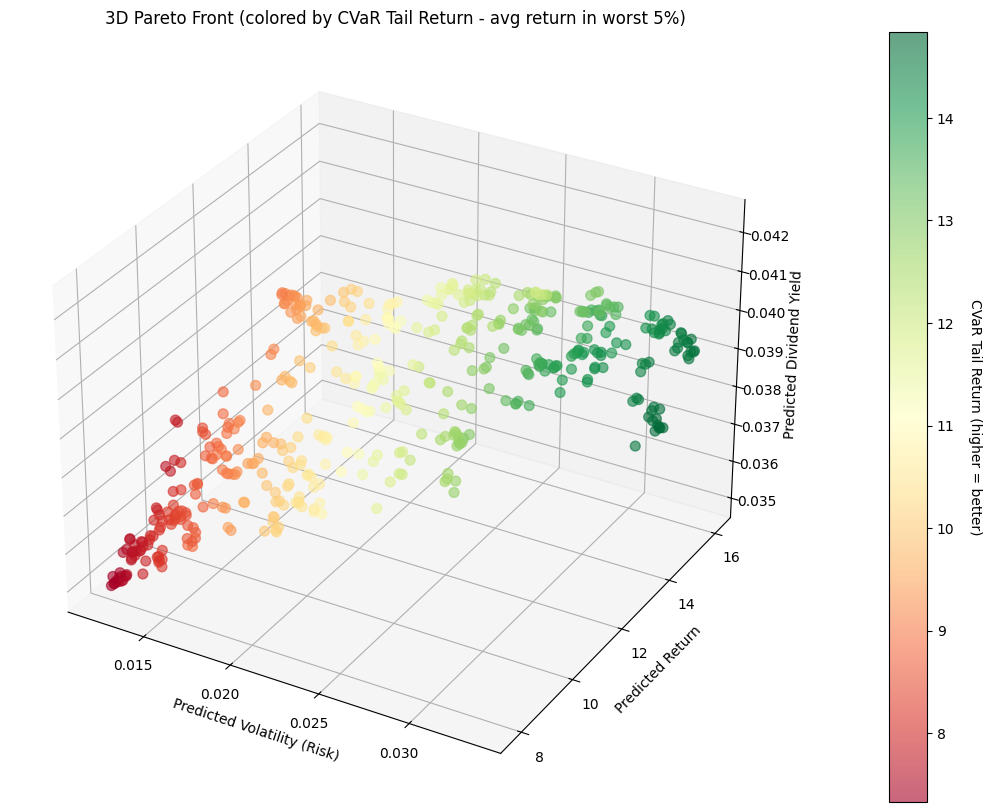

In [326]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract the objective values from the Pareto front
# Objectives: Negative Return, Negative Dividend Yield, Volatility, [CVaR if 4 objectives]
predicted_returns_pf = -pareto_front_objectives[:, 0]
predicted_dividend_yields_pf = -pareto_front_objectives[:, 1]
predicted_volatility_pf = pareto_front_objectives[:, 2]

# If CVaR is included (4th objective)
has_cvar = pareto_front_objectives.shape[1] == 4
if has_cvar:
    # Extract CVaR from objectives (this is the negated tail return used in optimization)
    predicted_cvar_pf = pareto_front_objectives[:, 3]
    # Negate CVaR to show actual tail return for coloring (positive = good, negative = bad)
    predicted_cvar_tail_return = -predicted_cvar_pf
    print(f"CVaR Tail Return Statistics (annualized):")
    print(f"  Mean: {predicted_cvar_tail_return.mean():.4f}")
    print(f"  Min:  {predicted_cvar_tail_return.min():.4f} (worst tail scenario)")
    print(f"  Max:  {predicted_cvar_tail_return.max():.4f} (best tail scenario)")
    print()

# Create 3D scatter plot (Volatility vs Return vs Dividend)
# Color by CVaR if available
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

if has_cvar:
    scatter = ax.scatter(predicted_volatility_pf, predicted_returns_pf, predicted_dividend_yields_pf, 
                        c=predicted_cvar_tail_return, cmap='RdYlGn', s=50, alpha=0.6)
    cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('CVaR Tail Return (higher = better)', rotation=270, labelpad=20)
    ax.set_title('3D Pareto Front (colored by CVaR Tail Return - avg return in worst 5%)')
else:
    ax.scatter(predicted_volatility_pf, predicted_returns_pf, predicted_dividend_yields_pf, alpha=0.6)
    ax.set_title('3D Pareto Front of Portfolio Optimization')

ax.set_xlabel('Predicted Volatility (Risk)')
ax.set_ylabel('Predicted Return')
ax.set_zlabel('Predicted Dividend Yield')

plt.show()

In [327]:
# Create a DataFrame for Pareto front objective values
# Objectives: Negative Return, Negative Dividend Yield, Volatility, [CVaR if 4 objectives]
has_cvar = pareto_front_objectives.shape[1] == 4

if has_cvar:
    col_names = ['-Predicted Return', '-Predicted Dividend Yield', 'Predicted Volatility', 'Predicted CVaR']
else:
    col_names = ['-Predicted Return', '-Predicted Dividend Yield', 'Predicted Volatility']

pareto_front_objectives_df = pd.DataFrame(pareto_front_objectives, columns=col_names)

# Add the actual predicted return and dividend yield (positive values)
pareto_front_objectives_df['Predicted Return'] = -pareto_front_objectives_df['-Predicted Return']
pareto_front_objectives_df['Predicted Dividend Yield'] = -pareto_front_objectives_df['-Predicted Dividend Yield']

# If CVaR exists, negate it back to show actual tail return (not the minimization objective)
# The optimizer stores -CVaR, so we negate again to get the actual average return in worst 5%
if has_cvar:
    # Negate to convert from optimization objective back to actual tail return
    pareto_front_objectives_df['Predicted CVaR (Tail Return)'] = -pareto_front_objectives_df['Predicted CVaR']
    pareto_front_objectives_df = pareto_front_objectives_df.drop(columns=['Predicted CVaR'])

# Drop the negative objective columns
pareto_front_objectives_df = pareto_front_objectives_df.drop(columns=['-Predicted Return', '-Predicted Dividend Yield'])

# Reorder columns for better readability
if has_cvar:
    pareto_front_objectives_df = pareto_front_objectives_df[['Predicted Return', 'Predicted Dividend Yield', 'Predicted Volatility', 'Predicted CVaR (Tail Return)']]
else:
    pareto_front_objectives_df = pareto_front_objectives_df[['Predicted Return', 'Predicted Dividend Yield', 'Predicted Volatility']]

# Get the asset tickers to label the columns
asset_tickers = portfolio_close_data.columns

# Create a DataFrame for Pareto front solutions (portfolio weights)
pareto_front_solutions_df = pd.DataFrame(pareto_front_solutions, columns=asset_tickers)

# Display results
display("Pareto Front Objective Values:")
display(pareto_front_objectives_df.head())
display(pareto_front_objectives_df.tail())

display("\nPareto Front Portfolio Weights:")
display(pareto_front_solutions_df.head())
display(pareto_front_solutions_df.tail())

'Pareto Front Objective Values:'

Predicted Return  Predicted Dividend Yield  Predicted Volatility  \
0          9.813332                  0.042302              0.019160   
1          7.835859                  0.035001              0.012106   
2         16.090060                  0.036830              0.031687   
3          7.928977                  0.035001              0.012134   
4         15.990982                  0.039150              0.033398   

   Predicted CVaR (Tail Return)  
0                      9.051749  
1                      7.352380  
2                     14.837811  
3                      7.444345  
4                     14.670274

Predicted Return  Predicted Dividend Yield  Predicted Volatility  \
495         15.442155                  0.039793              0.031353   
496         11.107662                  0.040329              0.019885   
497         15.792666                  0.036360              0.030532   
498         10.062158                  0.041687              0.019223   
499         12.569587                  0.041675              0.024471   

     Predicted CVaR (Tail Return)  
495                     14.201747  
496                     10.317465  
497                     14.586026  
498                      9.297775  
499                     11.598368

'\nPareto Front Portfolio Weights:'

Ticker      AAPL      ABBV       AMD      AMZN      AVGO       CME      COST  \
0       0.010056  0.098887  0.000001  0.000022  0.010451  0.099924  0.010028   
1       0.010038  0.083786  0.000002  0.000009  0.085848  0.010959  0.010125   
2       0.010051  0.010215  0.000017  0.000054  0.010885  0.016541  0.010039   
3       0.010038  0.074827  0.000002  0.000009  0.085847  0.011026  0.010125   
4       0.011210  0.010160  0.000102  0.000208  0.010013  0.092991  0.010121   

Ticker     FDIVX       FXY           GLD  ...      SCHD       SLV      SPLB  \
0       0.099945  0.000453  1.064358e-04  ...  0.035881  0.000020  0.099749   
1       0.098801  0.064669  5.532733e-05  ...  0.013827  0.000023  0.032621   
2       0.078659  0.002467  4.699334e-06  ...  0.015855  0.000436  0.099219   
3       0.099383  0.064669  5.532733e-05  ...  0.013827  0.000023  0.034958   
4       0.074196  0.000087  6.247198e-07  ...  0.011861  0.000005  0.099766   

Ticker       TLT       VDE       VEA       VWO       VYM       WMT       XOM  
0       0.019312  0.099701  0.034861  0.010035  0.046335  0.010031  0.099989  
1       0.010146  0.099854  0.012435  0.010051  0.085860  0.010115  0.099990  
2       0.092569  0.012573  0.010145  0.010524  0.011323  0.010030  0.086987  
3       0.013642  0.099854  0.011674  0.010300  0.085861  0.010009  0.099996  
4       0.077815  0.010583  0.010033  0.010053  0.010035  0.010276  0.079775  

[5 rows x 30 columns]

Ticker      AAPL      ABBV       AMD      AMZN      AVGO       CME      COST  \
495     0.017324  0.010120  0.000017  0.000015  0.011156  0.079079  0.010024   
496     0.010535  0.020076  0.000069  0.000524  0.013698  0.079092  0.010079   
497     0.010055  0.010210  0.000098  0.000041  0.010049  0.010833  0.010055   
498     0.010038  0.099167  0.000054  0.000569  0.020206  0.098377  0.010089   
499     0.010074  0.098876  0.000009  0.000035  0.010966  0.099693  0.010028   

Ticker     FDIVX       FXY       GLD  ...      SCHD       SLV      SPLB  \
495     0.098967  0.000680  0.000005  ...  0.013490  0.000125  0.099930   
496     0.077184  0.004894  0.000011  ...  0.023726  0.000003  0.097892   
497     0.078075  0.021628  0.000033  ...  0.015143  0.000050  0.099219   
498     0.098713  0.005328  0.000027  ...  0.012327  0.000129  0.099946   
499     0.099925  0.000151  0.001042  ...  0.017096  0.000022  0.099744   

Ticker       TLT       VDE       VEA       VWO       VYM       WMT       XOM  
495     0.044570  0.024365  0.011944  0.010018  0.012267  0.010107  0.097106  
496     0.064903  0.099979  0.010002  0.010012  0.075163  0.010163  0.099779  
497     0.092900  0.014361  0.010247  0.010027  0.011276  0.011939  0.099391  
498     0.018122  0.099942  0.011707  0.010022  0.067572  0.010122  0.099983  
499     0.028856  0.099675  0.011387  0.010032  0.014379  0.010098  0.099985  

[5 rows x 30 columns]

In [328]:
# Filter Pareto front objectives for predicted dividend yield > 0.04
high_dividend_portfolios = pareto_front_objectives_df[
    (pareto_front_objectives_df['Predicted Dividend Yield'] > 0.04)
    & (pareto_front_objectives_df['Predicted Return'] > 0.0)
    & (pareto_front_objectives_df['Predicted Volatility'] < 0.2)  # example risk threshold
    & ((~has_cvar) | (pareto_front_objectives_df['Predicted CVaR (Tail Return)'] > -0.1))
  ]  # example CVaR threshold if applicable

display("Pareto Front Portfolios with Predicted Dividend Yield > 0.0001:")
display(high_dividend_portfolios)

'Pareto Front Portfolios with Predicted Dividend Yield > 0.0001:'

Predicted Return  Predicted Dividend Yield  Predicted Volatility  \
0            9.813332                  0.042302              0.019160   
11          12.500390                  0.041095              0.023779   
15          12.686021                  0.041350              0.024636   
17          11.047031                  0.041935              0.021436   
22          10.241061                  0.041790              0.019491   
..                ...                       ...                   ...   
486         10.901327                  0.041696              0.020930   
490         14.268494                  0.040340              0.027152   
496         11.107662                  0.040329              0.019885   
498         10.062158                  0.041687              0.019223   
499         12.569587                  0.041675              0.024471   

     Predicted CVaR (Tail Return)  
0                        9.051749  
11                      11.557478  
15                      11.708548  
17                      10.195570  
22                       9.466131  
..                            ...  
486                     10.070565  
490                     13.192280  
496                     10.317465  
498                      9.297775  
499                     11.598368  

[146 rows x 4 columns]

### 📊 Understanding CVaR (Conditional Value at Risk)

**What is CVaR?**
- CVaR (also called Expected Shortfall) measures the **average return in the worst-case scenarios**
- At 95% confidence level, CVaR is the average of the worst 5% of returns
- It answers: *"In the worst 5% of days, what's the average return?"*

**How CVaR is Calculated:**
1. Take the worst 5% of predicted daily returns for each portfolio
2. Calculate the average of those worst returns (the "tail return")
3. Annualize by multiplying by 252

**Interpreting the "Predicted CVaR (Tail Return)" Column:**
- **Positive values** = Even in worst 5% of days, portfolio gains on average
  - CVaR = +7.94% → Worst 5% average is +7.94% annually (very optimistic)
  - Higher is better (larger gains even in bad scenarios)
  
- **Negative values** = In worst 5% of days, portfolio loses on average
  - CVaR = -10% → Worst 5% average is -10% annually (tail risk)
  - Less negative is better (smaller losses in bad scenarios)
  
- **Near zero** = Worst scenarios break even on average

**Understanding Your Results:**
- If **CVaR ≈ Return** (e.g., Return=8%, CVaR=+7.9%):
  - This means even the worst 5% of days are nearly as good as average
  - Indicates model predictions are very optimistic/consistent
  - Low volatility in predictions
  
- If **CVaR < 0** while **Return > 0** (e.g., Return=8%, CVaR=-5%):
  - Average is positive, but worst days have losses
  - More realistic risk/return tradeoff
  - Better captures downside risk

**What the Optimizer Does:**
- Internally, NSGA-II minimizes `-CVaR` (negated tail return)
- This makes it prefer portfolios with higher tail returns (less downside risk)
- Balances maximizing return while protecting against bad outcomes

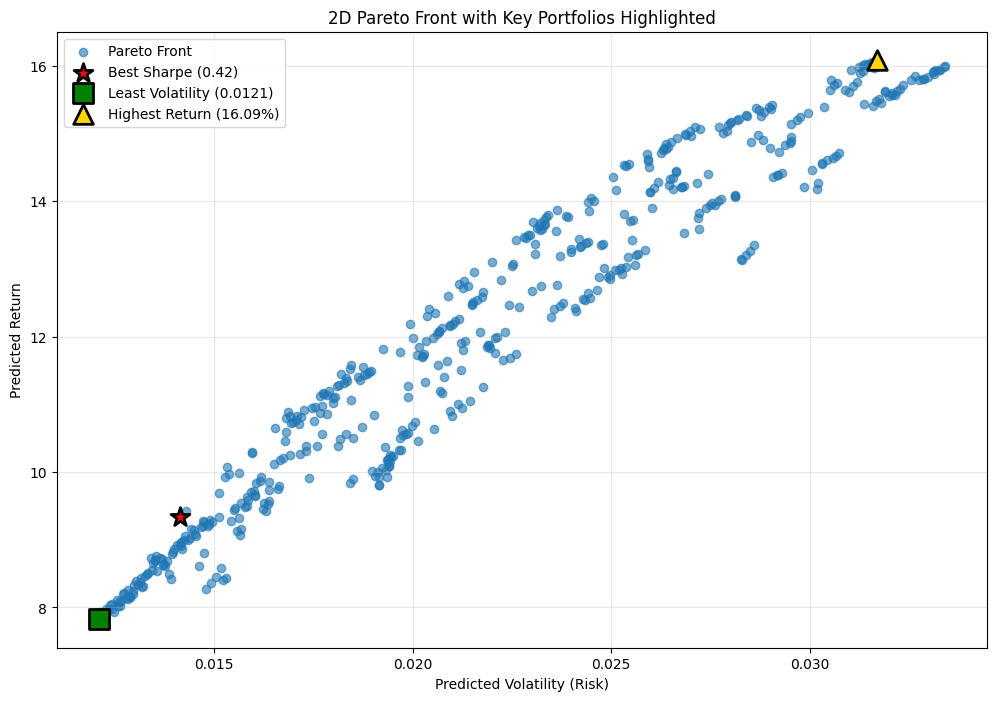


KEY PORTFOLIO DETAILS

🌟 BEST SHARPE RATIO:


Predicted Return                9.339778
Predicted Dividend Yield        0.035412
Predicted Volatility            0.014127
Predicted CVaR (Tail Return)    8.777346
Predicted Sharpe Ratio          0.416484
Name: 44, dtype: float64


🛡️ LEAST VOLATILITY:


Predicted Return                7.835859
Predicted Dividend Yield        0.035001
Predicted Volatility            0.012106
Predicted CVaR (Tail Return)    7.352380
Predicted Sharpe Ratio          0.407740
Name: 1, dtype: float64


🚀 HIGHEST RETURN:


Predicted Return                16.090060
Predicted Dividend Yield         0.036830
Predicted Volatility             0.031687
Predicted CVaR (Tail Return)    14.837811
Predicted Sharpe Ratio           0.319876
Name: 2, dtype: float64

In [329]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate Predicted Sharpe Ratio first
# Check if returns are in percentage form (values > 1)
if pareto_front_objectives_df['Predicted Return'].max() > 1.0:
    # Returns are percentages, convert to decimal
    predicted_return_decimal = pareto_front_objectives_df['Predicted Return'] / 100.0
else:
    # Returns are already decimals
    predicted_return_decimal = pareto_front_objectives_df['Predicted Return']

# Annualize the daily volatility
pareto_front_objectives_df['Predicted Volatility'] = pareto_front_objectives_df['Predicted Volatility'].replace(0, np.nan)
annualized_volatility = pareto_front_objectives_df['Predicted Volatility'] * np.sqrt(252)

# Calculate Sharpe Ratio (both in decimal form now)
pareto_front_objectives_df['Predicted Sharpe Ratio'] = predicted_return_decimal / annualized_volatility

# Extract Predicted Volatility and Predicted Return from the DataFrame
predicted_volatility_pf = pareto_front_objectives_df['Predicted Volatility']
predicted_returns_pf = pareto_front_objectives_df['Predicted Return']

# Identify key portfolios
best_sharpe_idx = pareto_front_objectives_df['Predicted Sharpe Ratio'].idxmax()
least_vol_idx = pareto_front_objectives_df['Predicted Volatility'].idxmin()
highest_return_idx = pareto_front_objectives_df['Predicted Return'].idxmax()

# Create a 2D scatter plot of the Pareto front (Return vs. Volatility)
plt.figure(figsize=(12, 8))
plt.scatter(predicted_volatility_pf, predicted_returns_pf, alpha=0.6, label='Pareto Front')

# Highlight key portfolios
plt.scatter(pareto_front_objectives_df.loc[best_sharpe_idx, 'Predicted Volatility'],
            pareto_front_objectives_df.loc[best_sharpe_idx, 'Predicted Return'],
            color='red', s=200, marker='*', edgecolors='black', linewidths=2,
            label=f'Best Sharpe ({pareto_front_objectives_df.loc[best_sharpe_idx, "Predicted Sharpe Ratio"]:.2f})', zorder=5)

plt.scatter(pareto_front_objectives_df.loc[least_vol_idx, 'Predicted Volatility'],
            pareto_front_objectives_df.loc[least_vol_idx, 'Predicted Return'],
            color='green', s=200, marker='s', edgecolors='black', linewidths=2,
            label=f'Least Volatility ({pareto_front_objectives_df.loc[least_vol_idx, "Predicted Volatility"]:.4f})', zorder=5)

plt.scatter(pareto_front_objectives_df.loc[highest_return_idx, 'Predicted Volatility'],
            pareto_front_objectives_df.loc[highest_return_idx, 'Predicted Return'],
            color='gold', s=200, marker='^', edgecolors='black', linewidths=2,
            label=f'Highest Return ({pareto_front_objectives_df.loc[highest_return_idx, "Predicted Return"]:.2f}%)', zorder=5)

plt.title('2D Pareto Front with Key Portfolios Highlighted')
plt.xlabel('Predicted Volatility (Risk)')
plt.ylabel('Predicted Return')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# Display details of key portfolios
print("\n" + "="*80)
print("KEY PORTFOLIO DETAILS")
print("="*80)

print("\n🌟 BEST SHARPE RATIO:")
display(pareto_front_objectives_df.loc[best_sharpe_idx])

print("\n🛡️ LEAST VOLATILITY:")
display(pareto_front_objectives_df.loc[least_vol_idx])

print("\n🚀 HIGHEST RETURN:")
display(pareto_front_objectives_df.loc[highest_return_idx])

In [330]:
# Sort the pareto_front_objectives_df by 'Predicted Volatility' in ascending order
pareto_front_objectives_df_sorted_by_volatility = pareto_front_objectives_df[
    (pareto_front_objectives_df['Predicted Return'] > 0.0) & (pareto_front_objectives_df['Predicted Dividend Yield'] > 0.04)
].sort_values(
    by=['Predicted Volatility', 'Predicted Return', 'Predicted Dividend Yield'], ascending=[True, False, False])

display("Pareto Front Objective Values Sorted by Least Volatility:")
display(pareto_front_objectives_df_sorted_by_volatility.head())
display(pareto_front_objectives_df_sorted_by_volatility.tail())

'Pareto Front Objective Values Sorted by Least Volatility:'

Predicted Return  Predicted Dividend Yield  Predicted Volatility  \
140          9.840353                  0.040648              0.018414   
101          9.893526                  0.040764              0.018497   
91          10.658070                  0.040060              0.018729   
392         10.007984                  0.041902              0.018975   
57           9.937494                  0.041948              0.019058   

     Predicted CVaR (Tail Return)  Predicted Sharpe Ratio  
140                      9.107702                0.336632  
101                      9.158794                0.336933  
91                       9.914609                0.358478  
392                      9.253473                0.332250  
57                       9.179386                0.328468

Predicted Return  Predicted Dividend Yield  Predicted Volatility  \
27          14.642805                  0.040689              0.030586   
246         14.672428                  0.040485              0.030667   
41          14.707864                  0.040667              0.030736   
463         15.411217                  0.040170              0.031600   
166         15.451571                  0.040150              0.031792   

     Predicted CVaR (Tail Return)  Predicted Sharpe Ratio  
27                      13.432078                0.301576  
246                     13.459297                0.301393  
41                      13.491019                0.301445  
463                     14.160753                0.307219  
166                     14.193669                0.306168

In [331]:
# debug dividend yield constraint feasibility
import numpy as np
# Inspect the per-asset average annual dividend yields you feed into the problem
print("average_annual_dividend_yield - summary:")
print(nsga_ii_data['average_dividend_yield'].describe())

# Show top dividend payers
print("\nTop dividend payers (annual yield as fraction):")
display(nsga_ii_data['average_dividend_yield'].sort_values(ascending=False).head(20))

# Long-only theoretical max portfolio dividend yield (sum weights = 1 => max = max single-asset yield)
max_yield = float(nsga_ii_data['average_dividend_yield'].max())
print(f"\nTheoretical maximum long-only portfolio yield (single-asset max): {max_yield:.4f} ({max_yield*100:.2f}%)")

# If you allow shorts, check feasible envelope under your bounds:
# for simple bounds 0<=w<=1, max still equals max single asset; if you use custom bounds this changes.

# If max_yield < your target -> constraint is infeasible
target = problem_long.target_dividend_yield if 'problem_long' in globals() else 0.04
print(f"Current dividend target: {target:.4f} ({target*100:.2f}%)")
if max_yield < target:
    print("=> Target greater than any single asset yield. Long-only constraint is infeasible. Lower target or remove constraint.")

average_annual_dividend_yield - summary:
count    30.000000
mean      0.025462
std       0.018389
min       0.000000
25%       0.007088
50%       0.030669
75%       0.035672
max       0.055881
dtype: float64

Top dividend payers (annual yield as fraction):


SPLB     0.055881
XOM      0.053196
PFE      0.052002
CME      0.050614
FDIVX    0.046603
ABBV     0.045219
SCHD     0.036351
KO       0.035758
VDE      0.035412
VYM      0.034847
VEA      0.034740
PEP      0.033636
VWO      0.032867
PG       0.032113
TLT      0.032099
INTC     0.029240
AVGO     0.023988
HD       0.023986
WMT      0.021261
COST     0.019209
dtype: float64


Theoretical maximum long-only portfolio yield (single-asset max): 0.0559 (5.59%)
Current dividend target: 0.0400 (4.00%)


## Evaluate Selected Portfolio

### Subtask:
Evaluate the performance of the selected portfolio using historical data and compare it with the benchmark (SPY) and the equal-weighted portfolio.

**Reasoning**:
Retrieve the weights of the selected portfolio, calculate its historical returns and performance metrics, and compare with SPY.

Index for portfolio with least volatility return > 0 and dividend > 0.04 140


'Historical Cumulative Returns of Selected Portfolio:'

Date
2025-11-10    3.555558
2025-11-11    3.613686
2025-11-12    3.625624
2025-11-13    3.604694
2025-11-14    3.601054
dtype: float64

'\nSelected Portfolio Historical Annualized Volatility: 0.1335'

'Selected Portfolio Historical Sharpe Ratio: 0.9568'

'Selected Portfolio Historical VaR (95% confidence): 0.0118'

'Selected Portfolio Historical CVaR (95% confidence): 0.0197'

'Selected Portfolio Historical VaR (99% confidence): 0.0223'

'Selected Portfolio Historical CVaR (99% confidence): 0.0361'

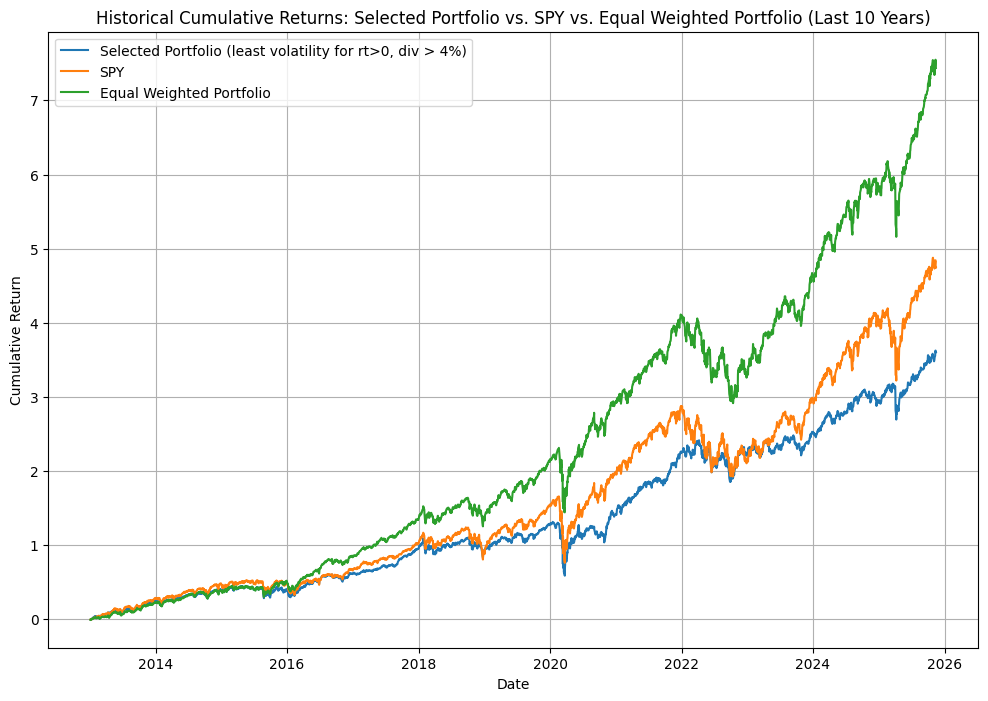

'\nSelected Portfolio Historical Cumulative Dividends Paid (Daily):'

Date
2025-11-10    33.630590
2025-11-11    33.642611
2025-11-12    33.654633
2025-11-13    33.666654
2025-11-14    33.678675
dtype: float64

'\nSelected Portfolio Total Historical Dividends Paid: 33.6787'

In [334]:
# Select the portfolio weights for the portfolio at index 0
# The previous error occurred because we were selecting from the objectives DataFrame.
# We need to select the weights from the DataFrame that contains the portfolio compositions (pareto_front_solutions_df).
# Let's use the index of the portfolio with the least predicted volatility from the sorted objectives DataFrame
least_volatile_portfolio_index = pareto_front_objectives_df_sorted_by_volatility.index[0]
print('Index for portfolio with least volatility return > 0 and dividend > 0.04', least_volatile_portfolio_index)
selected_portfolio_weights = pareto_front_solutions_df.loc[least_volatile_portfolio_index]


# Ensure weights are normalized to sum to 1, although NSGA-II should handle this
selected_portfolio_weights = selected_portfolio_weights / selected_portfolio_weights.sum()

# Exclude SPY from historical daily returns for portfolio calculation (if present)
if 'SPY' in daily_returns.columns:
    portfolio_historical_daily_returns = daily_returns.drop(columns=['SPY'])
else:
    portfolio_historical_daily_returns = daily_returns.copy()

# Calculate the historical daily returns of the selected portfolio
# We need to align the historical daily returns with the portfolio weights by asset
# and then calculate the weighted average daily return for the portfolio.
# Ensure the order of columns in portfolio_historical_daily_returns matches the order of weights
# The index of selected_portfolio_weights now contains the asset tickers, which should match

# Find common tickers between weights and historical data
common_tickers = selected_portfolio_weights.index.intersection(portfolio_historical_daily_returns.columns)
if len(common_tickers) == 0:
    raise ValueError("No common tickers found between portfolio weights and historical returns data")

# Use only the common tickers and renormalize weights
selected_portfolio_weights_aligned = selected_portfolio_weights[common_tickers]
selected_portfolio_weights_aligned = selected_portfolio_weights_aligned / selected_portfolio_weights_aligned.sum()

portfolio_historical_daily_returns_selected = portfolio_historical_daily_returns[common_tickers]

selected_portfolio_historical_returns = (portfolio_historical_daily_returns_selected * selected_portfolio_weights_aligned).sum(axis=1)

# Calculate historical cumulative returns of the selected portfolio
selected_portfolio_historical_cumulative_returns = (1 + selected_portfolio_historical_returns).cumprod() - 1

display("Historical Cumulative Returns of Selected Portfolio:")
display(selected_portfolio_historical_cumulative_returns.tail())

# Calculate historical performance metrics for the selected portfolio
# Annualized Volatility
selected_portfolio_historical_volatility = selected_portfolio_historical_returns.std() * np.sqrt(252)

# Sharpe Ratio (assuming risk-free rate is 0)
selected_portfolio_historical_sharpe_ratio = selected_portfolio_historical_returns.mean() / selected_portfolio_historical_returns.std() * np.sqrt(252)

# Historical VaR (95% and 99%)
selected_portfolio_historical_VaR_95 = -np.percentile(selected_portfolio_historical_returns, 100 * (1 - 0.95))
selected_portfolio_historical_VaR_99 = -np.percentile(selected_portfolio_historical_returns, 100 * (1 - 0.99))

# Historical CVaR (95% and 99%)
selected_portfolio_historical_CVaR_95 = -selected_portfolio_historical_returns[selected_portfolio_historical_returns < -selected_portfolio_historical_VaR_95].mean()
selected_portfolio_historical_CVaR_99 = -selected_portfolio_historical_returns[selected_portfolio_historical_returns < -selected_portfolio_historical_VaR_99].mean()


display(f"\nSelected Portfolio Historical Annualized Volatility: {selected_portfolio_historical_volatility:.4f}")
display(f"Selected Portfolio Historical Sharpe Ratio: {selected_portfolio_historical_sharpe_ratio:.4f}")
display(f"Selected Portfolio Historical VaR (95% confidence): {selected_portfolio_historical_VaR_95:.4f}")
display(f"Selected Portfolio Historical CVaR (95% confidence): {selected_portfolio_historical_CVaR_95:.4f}")
display(f"Selected Portfolio Historical VaR (99% confidence): {selected_portfolio_historical_VaR_99:.4f}")
display(f"Selected Portfolio Historical CVaR (99% confidence): {selected_portfolio_historical_CVaR_99:.4f}")


# Compare historical cumulative returns with SPY and Equal Weighted Portfolio
plt.figure(figsize=(12, 8))
plt.plot(selected_portfolio_historical_cumulative_returns.index,
         selected_portfolio_historical_cumulative_returns, label='Selected Portfolio (least volatility for rt>0, div > 4%)')

# Plot SPY if available
if 'SPY' in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns['SPY'], label='SPY')
elif 'SPY' in daily_returns.columns:
    spy_cumulative = (1 + daily_returns['SPY']).cumprod() - 1
    plt.plot(spy_cumulative.index, spy_cumulative, label='SPY')

plt.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, label='Equal Weighted Portfolio') # Add Equal Weighted Portfolio for comparison

plt.title('Historical Cumulative Returns: Selected Portfolio vs. SPY vs. Equal Weighted Portfolio (Last 10 Years)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


# Calculate historical dividend yield for the selected portfolio
# We need to align historical daily dividend data with the selected portfolio weights
# and calculate the weighted average daily dividend for the portfolio.
# Ensure the order of columns in aligned_daily_dividend_data matches the order of weights

# Select only the weights for assets present in the aligned_daily_dividend_data
dividend_paying_assets = aligned_daily_dividend_data.columns
# Filter selected_portfolio_weights to only include dividend_paying_assets
selected_portfolio_weights_dividends = selected_portfolio_weights[selected_portfolio_weights.index.intersection(dividend_paying_assets)]

aligned_daily_dividend_data_portfolio = aligned_daily_dividend_data[selected_portfolio_weights_dividends.index]

selected_portfolio_historical_daily_dividends = (aligned_daily_dividend_data_portfolio * selected_portfolio_weights_dividends).sum(axis=1)

# Calculate cumulative historical dividends
selected_portfolio_historical_cumulative_dividends = selected_portfolio_historical_daily_dividends.cumsum()

display("\nSelected Portfolio Historical Cumulative Dividends Paid (Daily):")
display(selected_portfolio_historical_cumulative_dividends.tail())

# Note: Calculating historical dividend yield accurately requires knowing the portfolio value over time.
# A simplified approach is to look at the total dividends paid relative to the initial investment or average portfolio value.
# For a more precise historical yield calculation, you would simulate the portfolio's value and dividend income over time.

# As a proxy, we can calculate the total historical dividends paid relative to the initial portfolio value (assuming an initial investment of 1).
initial_portfolio_value = 1.0
total_historical_dividends = selected_portfolio_historical_cumulative_dividends.iloc[-1]

display(f"\nSelected Portfolio Total Historical Dividends Paid: {total_historical_dividends:.4f}")

# It's challenging to calculate an "average historical dividend yield" that directly compares to the predicted yield objective without a full simulation.
# The predicted yield was based on the average historical daily dividend yield of assets, which was mostly 0.
# The actual historical cumulative dividends provide a better picture of income generated.

# save these to csv


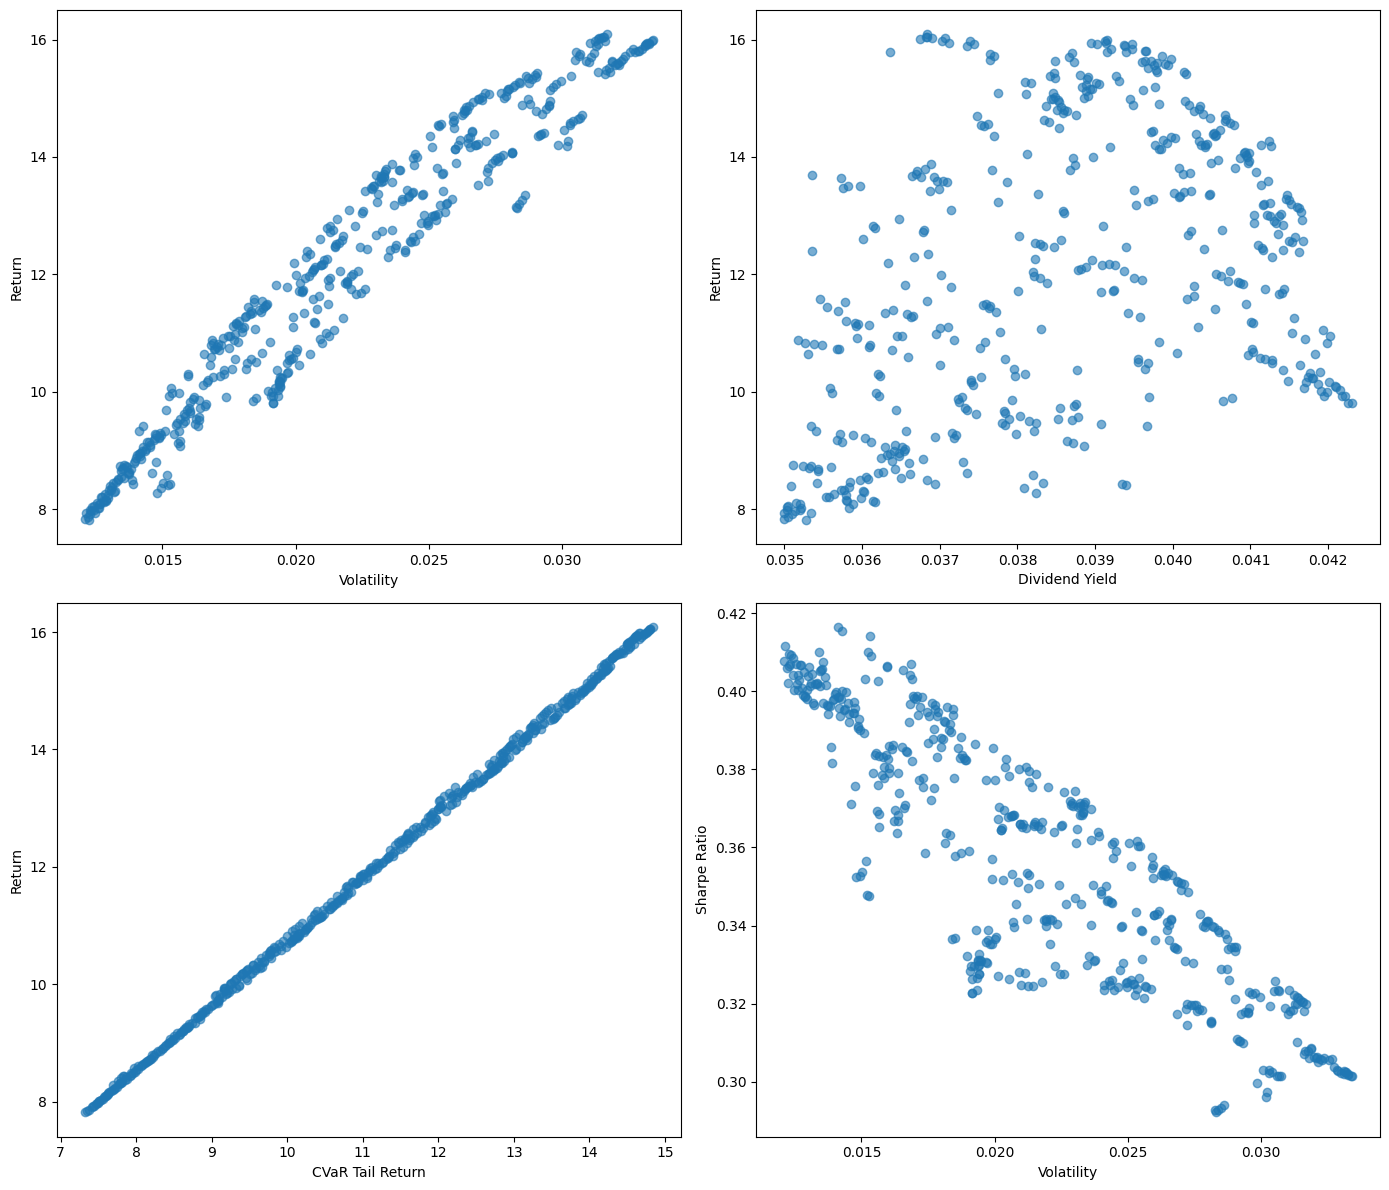

In [337]:
## 🎯 How to Choose Portfolio Weights from NSGA-II Pareto Front

### Understanding the Pareto Front

# NSGA-II produces a **Pareto front** - a set of portfolios where:
# - No portfolio dominates another on ALL objectives simultaneously
# - Improving one objective requires sacrificing another
# - Each portfolio represents a different risk/return/dividend/CVaR trade-off

### Selection Strategies

#**1. Target a Specific Objective**
# Highest return (most aggressive)
max_return_idx = pareto_front_objectives_df['Predicted Return'].idxmax()

# Lowest volatility (most conservative)
min_vol_idx = pareto_front_objectives_df['Predicted Volatility'].idxmin()

# Best Sharpe ratio (best risk-adjusted return)
best_sharpe_idx = pareto_front_objectives_df['Predicted Sharpe Ratio'].idxmax()

# Best tail risk (highest CVaR tail return)
best_cvar_idx = pareto_front_objectives_df['Predicted CVaR (Tail Return)'].idxmax()

#**2. Multi-Criteria Filtering**
# Filter portfolios meeting your requirements

candidates = pareto_front_objectives_df[
    (pareto_front_objectives_df['Predicted Return'] > 0.08) &  # At least 8% return
    (pareto_front_objectives_df['Predicted Dividend Yield'] > 0.04) &  # At least 4% dividend
    (pareto_front_objectives_df['Predicted Volatility'] < 0.15) &  # Max 15% volatility
    (pareto_front_objectives_df['Predicted CVaR (Tail Return)'] > 0)  # Positive tail return
]

# Then pick based on preference (e.g., best Sharpe among candidates)
selected_idx = candidates['Predicted Sharpe Ratio'].idxmax()

# **3. Weighted Scoring (Utility Function)**
# Define your preferences (weights sum to 1)
w_return = 0.4
w_dividend = 0.2
w_risk = 0.3  # lower is better
w_cvar = 0.1  # higher is better

# Normalize objectives to 0-1 scale
df = pareto_front_objectives_df.copy()
df['Return_norm'] = (df['Predicted Return'] - df['Predicted Return'].min()) / (df['Predicted Return'].max() - df['Predicted Return'].min())
df['Dividend_norm'] = (df['Predicted Dividend Yield'] - df['Predicted Dividend Yield'].min()) / (df['Predicted Dividend Yield'].max() - df['Predicted Dividend Yield'].min())
df['Risk_norm'] = 1 - (df['Predicted Volatility'] - df['Predicted Volatility'].min()) / (df['Predicted Volatility'].max() - df['Predicted Volatility'].min())  # Invert
df['CVaR_norm'] = (df['Predicted CVaR (Tail Return)'] - df['Predicted CVaR (Tail Return)'].min()) / (df['Predicted CVaR (Tail Return)'].max() - df['Predicted CVaR (Tail Return)'].min())

# Calculate utility score
df['Utility'] = (w_return * df['Return_norm'] + 
                 w_dividend * df['Dividend_norm'] + 
                 w_risk * df['Risk_norm'] +
                 w_cvar * df['CVaR_norm'])

# Select portfolio with highest utility
best_utility_idx = df['Utility'].idxmax()

#**4. Knee Point Detection (Balanced Trade-off)**
# Find the "knee" of the Pareto front - best balance
# This is where small improvements in one objective require large sacrifices in others
from scipy.spatial.distance import cdist

# Normalize objectives
objectives_norm = pareto_front_objectives_df[['Predicted Return', 'Predicted Volatility']].values
objectives_norm = (objectives_norm - objectives_norm.min(axis=0)) / (objectives_norm.max(axis=0) - objectives_norm.min(axis=0))

# Find point farthest from line connecting extremes
start = objectives_norm[0]
end = objectives_norm[-1]
line = end - start
distances = np.abs(np.cross(line, start - objectives_norm)) / np.linalg.norm(line)
knee_idx = pareto_front_objectives_df.index[distances.argmax()]

### Current Implementation

# Your notebook uses:
# - **"Least Volatile"**: Minimum volatility among portfolios with Return > 0 and Dividend > 4%
# - **"Best Sharpe"**: Maximum Sharpe ratio across all portfolios

### Practical Recommendations

# **Conservative Investor:**
# - Choose minimum volatility portfolio
# - Or filter for Dividend > 4%, then pick lowest volatility

# **Aggressive Investor:**
# - Choose maximum return portfolio
# - Or best Sharpe ratio for risk-adjusted gains

# **Income-Focused:**
# - Choose maximum dividend yield portfolio
# - Or filter Dividend > target, then pick best Sharpe

# **Risk-Aware:**
# - Choose best CVaR tail return (least downside in crashes)
# - Or filter CVaR > threshold, then optimize other objectives

### Visualizing Trade-offs


# Interactive exploration
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Return vs Volatility
axes[0,0].scatter(pareto_front_objectives_df['Predicted Volatility'], 
                  pareto_front_objectives_df['Predicted Return'], alpha=0.6)
axes[0,0].set_xlabel('Volatility'); axes[0,0].set_ylabel('Return')

# Return vs Dividend
axes[0,1].scatter(pareto_front_objectives_df['Predicted Dividend Yield'], 
                  pareto_front_objectives_df['Predicted Return'], alpha=0.6)
axes[0,1].set_xlabel('Dividend Yield'); axes[0,1].set_ylabel('Return')

# CVaR vs Return
axes[1,0].scatter(pareto_front_objectives_df['Predicted CVaR (Tail Return)'], 
                  pareto_front_objectives_df['Predicted Return'], alpha=0.6)
axes[1,0].set_xlabel('CVaR Tail Return'); axes[1,0].set_ylabel('Return')

# Sharpe vs Volatility
axes[1,1].scatter(pareto_front_objectives_df['Predicted Volatility'], 
                  pareto_front_objectives_df['Predicted Sharpe Ratio'], alpha=0.6)
axes[1,1].set_xlabel('Volatility'); axes[1,1].set_ylabel('Sharpe Ratio')

plt.tight_layout()
plt.show()


In [336]:
display("Weights of the Selected Portfolio (Least volatility):")
display(selected_portfolio_weights)

'Weights of the Selected Portfolio (Least volatility):'

Ticker
AAPL     0.010003
ABBV     0.084734
AMD      0.003467
AMZN     0.000161
AVGO     0.012212
CME      0.086436
COST     0.009992
FDIVX    0.096239
FXY      0.005827
GLD      0.000014
GOOG     0.010085
HD       0.009972
INTC     0.009928
KO       0.017986
META     0.013361
MSFT     0.010013
NVDA     0.010868
PEP      0.011312
PFE      0.098841
PG       0.013261
SCHD     0.023916
SLV      0.000175
SPLB     0.073469
TLT      0.073605
VDE      0.099116
VEA      0.010268
VWO      0.010064
VYM      0.085443
WMT      0.010186
XOM      0.099043
Name: 140, dtype: float64

# Task
Develop a prototype for a growth and income stock portfolio using a multivariate bi-lstm model for stock prediction and the NSGA-II algorithm for portfolio selection. The portfolio should aim for a 4% dividend yield and reinvest the rest into growth. Use yfinance to select top-performing GOOG, AAPL, Gold ETF, Bitcoin, US Treasuries, and REIT for diversification. Compare the portfolio's performance over the last 10 years with SPY. Calculate and plot the portfolio's dividend payments, VaR, CVaR, and Sharpe Ratio, and compare these metrics with SPY. Implement and visualize the Bi-LSTM model's predictions and compare them with actual returns. Implement the NSGA-II algorithm for portfolio optimization, visualize the Pareto front, and analyze the trade-offs between return, volatility, and dividend yield. Evaluate a selected portfolio from the Pareto front using historical data and compare its performance with SPY and an equal-weighted portfolio. Finally, explore the impact of allowing short selling in the NSGA-II optimization and compare the performance of a selected "shorts allowed" portfolio with the "long only" portfolio and benchmarks.

## Modify nsga-ii problem for shorts

### Subtask:
Adjust the constraints in the `PortfolioOptimizationProblem` class to allow for negative portfolio weights (short selling).


**Reasoning**:
Redefine the PortfolioOptimizationProblem class to allow for negative weights (short selling) by setting the lower bound (xl) to -1.0.



## Run nsga-ii with shorts allowed

### Subtask:
Execute the NSGA-II algorithm with the modified problem definition to find the Pareto front when short selling is permitted.


**Reasoning**:
Instantiate the portfolio optimization problem with the modified class and run the NSGA-II algorithm to find the Pareto front when short selling is permitted.



In [338]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize

# ===== USE THE SELECTED PREDICTIONS (CONFIGURED ABOVE) =====
# Shorts-allowed with return > 5% annualized
problem_shorts = PortfolioOptimizationProblem(
    nsga_ii_data['selected_predictions'],  # UPDATED: Use selected prediction mode
    nsga_ii_data['average_dividend_yield'],
    dividend_payer_mask=nsga_ii_data['dividend_payer_mask'],
    allow_shorts=True,
    min_return=0.05,  # 5% minimum annualized return
    cvar_alpha=0.05       # 95% CVaR (focus on worst 5% of scenarios
)

print("🎯 Shorts-Allowed Optimization Configuration:")
print(f"  Prediction Mode: {PREDICTION_MODE.upper()}")
print(f"  Prediction Period: {nsga_ii_data['selected_predictions'].index[0].date()} to {nsga_ii_data['selected_predictions'].index[-1].date()}")
print(f"  Allows Shorts: True")
print()

# Configure the NSGA-II algorithm
algorithm_shorts = NSGA2(
    pop_size=500,            # Population size
    eliminate_duplicates=True
)

# Define termination criteria
termination_shorts = get_termination("n_gen", 1000) # Terminate after 200 generations

# Run the optimization with shorts allowed
res_shorts = minimize(problem_shorts,
                      algorithm_shorts,
                      termination_shorts,
                      seed=42,       # for reproducibility
                      verbose=True)

# Extract the non-dominated solutions (Pareto front) for the shorts allowed case

🎯 Shorts-Allowed Optimization Configuration:
  Prediction Mode: FUTURE
  Prediction Period: 2025-11-15 to 2025-12-14
  Allows Shorts: True

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      500 |      1 |  0.0054191533 |  2.1933018849 |             - |             -
     2 |     1000 |      1 |  0.000000E+00 |  1.4645383583 |             - |             -
     3 |     1500 |      3 |  0.000000E+00 |  0.9382080267 |  1.0000000000 |         ideal
     4 |     2000 |      1 |  0.000000E+00 |  0.4205405360 |  0.0761194175 |         ideal
     5 |     2500 |      6 |  0.000000E+00 |  0.1825138960 |  0.4331323007 |         ideal
     6 |     3000 |      8 |  0.000000E+00 |  0.0854839907 |  0.1977675760 |         nadir
     7 |     3500 |     13 |  0.000000E+00 |  0.0469926042 |  0.0862074068 |         ideal
     8 |     4000 |     16 |  0.000000E+00 |  0.0283581112 |  0.0191121610 |             f
     9 |     4500 |     20 |  0.000000E+0

**Reasoning**:
Visualize the Pareto front obtained from the NSGA-II optimization with short selling allowed to understand the trade-offs between the objectives in this scenario and compare it with the long-only case.



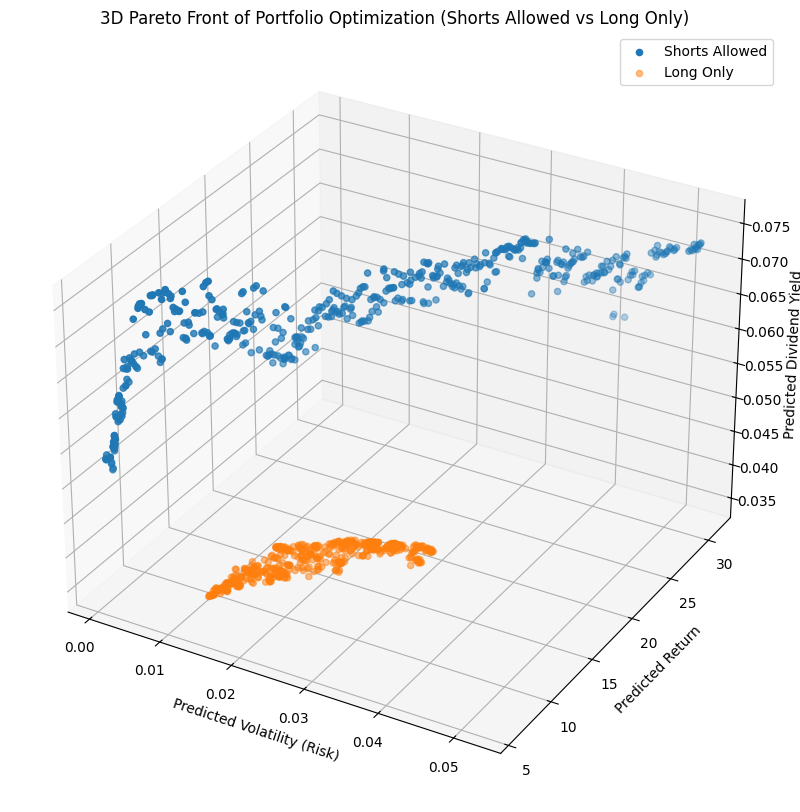

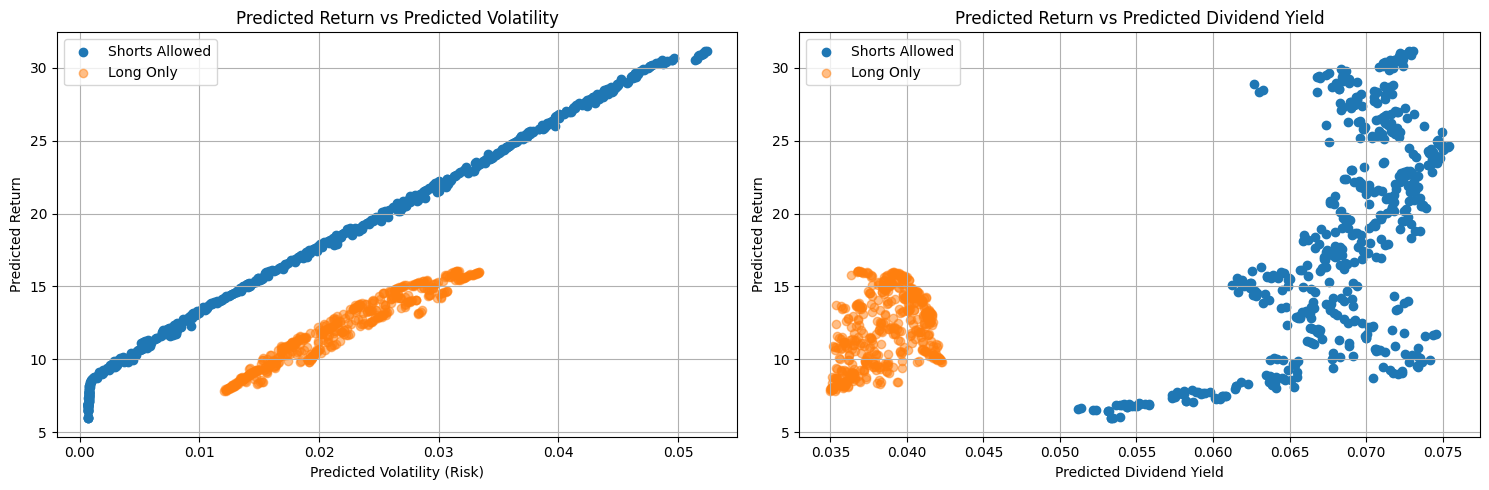

In [339]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract the objective values from the Pareto front for the shorts allowed case
# Objectives are: Negative Return, Negative Dividend Yield, Volatility
predicted_returns_pf_shorts = -pareto_front_objectives_shorts[:, 0]
predicted_dividend_yields_pf_shorts = -pareto_front_objectives_shorts[:, 1]
predicted_volatility_pf_shorts = pareto_front_objectives_shorts[:, 2]

# Create a 3D scatter plot for the shorts allowed Pareto front
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(predicted_volatility_pf_shorts, predicted_returns_pf_shorts, predicted_dividend_yields_pf_shorts, label='Shorts Allowed')

# Add the long-only Pareto front to the plot for comparison
ax.scatter(predicted_volatility_pf, predicted_returns_pf, predicted_dividend_yields_pf, label='Long Only', alpha=0.5)


ax.set_xlabel('Predicted Volatility (Risk)')
ax.set_ylabel('Predicted Return')
ax.set_zlabel('Predicted Dividend Yield')
ax.set_title('3D Pareto Front of Portfolio Optimization (Shorts Allowed vs Long Only)')
ax.legend()

plt.show()

# Create 2D plots for easier comparison
plt.figure(figsize=(15, 5))

# Plot Return vs Volatility
plt.subplot(1, 2, 1)
plt.scatter(predicted_volatility_pf_shorts, predicted_returns_pf_shorts, label='Shorts Allowed')
plt.scatter(predicted_volatility_pf, predicted_returns_pf, label='Long Only', alpha=0.5)
plt.title('Predicted Return vs Predicted Volatility')
plt.xlabel('Predicted Volatility (Risk)')
plt.ylabel('Predicted Return')
plt.legend()
plt.grid(True)

# Plot Return vs Dividend Yield
plt.subplot(1, 2, 2)
plt.scatter(predicted_dividend_yields_pf_shorts, predicted_returns_pf_shorts, label='Shorts Allowed')
plt.scatter(predicted_dividend_yields_pf, predicted_returns_pf, label='Long Only', alpha=0.5)
plt.title('Predicted Return vs Predicted Dividend Yield')
plt.xlabel('Predicted Dividend Yield')
plt.ylabel('Predicted Return')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Reasoning**:
Display the objective values and portfolio weights for the Pareto front when short selling is allowed, similar to what was done for the long-only case, to facilitate analysis and selection of a specific portfolio.



In [340]:
import pandas as pd

# Create a DataFrame for Pareto front objective values (Shorts Allowed)
# Objectives: Negative Return, Negative Dividend Yield, Volatility, [CVaR if 4 objectives]
has_cvar_shorts = pareto_front_objectives_shorts.shape[1] == 4

if has_cvar_shorts:
    col_names_shorts = ['-Predicted Return', '-Predicted Dividend Yield', 'Predicted Volatility', 'Predicted CVaR']
else:
    col_names_shorts = ['-Predicted Return', '-Predicted Dividend Yield', 'Predicted Volatility']

pareto_front_objectives_df_shorts = pd.DataFrame(pareto_front_objectives_shorts, columns=col_names_shorts)

# Add the actual predicted return and dividend yield (positive values)
pareto_front_objectives_df_shorts['Predicted Return'] = -pareto_front_objectives_df_shorts['-Predicted Return']
pareto_front_objectives_df_shorts['Predicted Dividend Yield'] = -pareto_front_objectives_df_shorts['-Predicted Dividend Yield']

# If CVaR exists, negate it back to show actual tail return (not the minimization objective)
if has_cvar_shorts:
    pareto_front_objectives_df_shorts['Predicted CVaR (Tail Return)'] = -pareto_front_objectives_df_shorts['Predicted CVaR']
    pareto_front_objectives_df_shorts = pareto_front_objectives_df_shorts.drop(columns=['Predicted CVaR'])

# Drop the negative objective columns
pareto_front_objectives_df_shorts = pareto_front_objectives_df_shorts.drop(columns=['-Predicted Return', '-Predicted Dividend Yield'])

# Reorder columns for better readability
if has_cvar_shorts:
    pareto_front_objectives_df_shorts = pareto_front_objectives_df_shorts[['Predicted Return', 'Predicted Dividend Yield', 'Predicted Volatility', 'Predicted CVaR (Tail Return)']]
else:
    pareto_front_objectives_df_shorts = pareto_front_objectives_df_shorts[['Predicted Return', 'Predicted Dividend Yield', 'Predicted Volatility']]

display("Pareto Front Objective Values (Shorts Allowed):")
display(pareto_front_objectives_df_shorts.head())
display(pareto_front_objectives_df_shorts.tail())

# Create a DataFrame for Pareto front solutions (portfolio weights - Shorts Allowed)
# We need to get the asset tickers to label the columns
asset_tickers = portfolio_close_data.columns

pareto_front_solutions_df_shorts = pd.DataFrame(pareto_front_solutions_shorts, columns=asset_tickers)

display("\nPareto Front Portfolio Weights (Shorts Allowed):")
display(pareto_front_solutions_df_shorts.head())
display(pareto_front_solutions_df_shorts.tail())

'Pareto Front Objective Values (Shorts Allowed):'

Predicted Return  Predicted Dividend Yield  Predicted Volatility  \
0          5.942083                  0.053479              0.000712   
1          6.610287                  0.051209              0.000715   
2         31.177988                  0.073043              0.052385   
3         24.643855                  0.075421              0.035788   
4          6.415618                  0.053160              0.000691   

   Predicted CVaR (Tail Return)  
0                      5.913314  
1                      6.581580  
2                     29.102866  
3                     23.220556  
4                      6.387874

Predicted Return  Predicted Dividend Yield  Predicted Volatility  \
495          7.465923                  0.060591              0.000789   
496          7.797016                  0.058110              0.000769   
497         26.568877                  0.072698              0.040079   
498          8.176719                  0.061526              0.000819   
499          8.168892                  0.061487              0.000819   

     Predicted CVaR (Tail Return)  
495                      7.433430  
496                      7.765966  
497                     24.979795  
498                      8.143754  
499                      8.135695

'\nPareto Front Portfolio Weights (Shorts Allowed):'

Ticker      AAPL      ABBV       AMD      AMZN      AVGO       CME      COST  \
0       0.015485  0.063301 -0.813124 -0.091122  0.092497  0.023117  0.040780   
1       0.019942  0.048979 -0.922892  0.008762  0.088835  0.027346  0.040817   
2       0.096361  0.089343  0.072170  0.076124  0.098812  0.086747  0.072431   
3       0.098821  0.097991 -0.397239  0.042958  0.096977  0.095067  0.090841   
4       0.012231  0.048353 -0.919279  0.009925  0.097230  0.023042  0.070415   

Ticker     FDIVX       FXY       GLD  ...      SCHD       SLV      SPLB  \
0       0.043261  0.085637  0.019233  ...  0.094890  0.089908  0.043857   
1       0.033603  0.099826  0.022746  ...  0.098361  0.084963  0.043427   
2       0.099208  0.023341 -0.921757  ...  0.092443 -0.594417  0.099832   
3       0.099681  0.099229 -0.919810  ...  0.099197 -0.262067  0.099640   
4       0.098531  0.098835  0.017219  ...  0.098379  0.057843  0.044966   

Ticker       TLT       VDE       VEA       VWO       VYM       WMT       XOM  
0       0.096589  0.085349  0.098132  0.093669  0.049342  0.069099  0.099092  
1       0.099439  0.091139  0.052287  0.062258  0.097811  0.084903  0.093666  
2       0.098247  0.099309  0.098394  0.099711  0.099724  0.080044  0.096991  
3       0.098778  0.099991  0.097956  0.098476  0.099380  0.099022  0.099973  
4       0.099987  0.091688  0.098984  0.044463  0.039312  0.067919  0.094897  

[5 rows x 30 columns]

Ticker      AAPL      ABBV       AMD      AMZN      AVGO       CME      COST  \
495     0.099500  0.064676 -0.928456 -0.134821  0.099218  0.047784  0.070324   
496     0.086424  0.052270 -0.921833 -0.136737  0.088230  0.015967  0.032264   
497     0.088655  0.098757 -0.139779  0.011540  0.096679  0.092498  0.089710   
498     0.098273  0.032748 -0.978823 -0.144814  0.088043  0.015712  0.073891   
499     0.098273  0.032748 -0.978823 -0.144814  0.088043  0.015712  0.073891   

Ticker     FDIVX       FXY       GLD  ...      SCHD       SLV      SPLB  \
495     0.045174  0.098618 -0.096062  ...  0.099425  0.073366  0.098632   
496     0.043459  0.098977 -0.066949  ...  0.098375  0.075824  0.099728   
497     0.099876  0.099864 -0.976343  ...  0.097906 -0.325430  0.097735   
498     0.095830  0.098967 -0.065247  ...  0.099325  0.027657  0.096401   
499     0.095830  0.098967 -0.065247  ...  0.099325  0.027657  0.096401   

Ticker       TLT       VDE       VEA       VWO       VYM       WMT       XOM  
495     0.097738  0.099893  0.094868  0.096933  0.070950  0.062886  0.099946  
496     0.094301  0.099528  0.097698  0.054387  0.073484  0.096588  0.099925  
497     0.097668  0.099379  0.092358  0.089723  0.099735  0.099376  0.099591  
498     0.099639  0.098227  0.092985  0.071525  0.092363  0.094712  0.099793  
499     0.099213  0.098227  0.094924  0.071525  0.092363  0.094712  0.099793  

[5 rows x 30 columns]

## Analyze and select portfolio (shorts allowed)

### Subtask:
Analyze the resulting Pareto front from the "shorts allowed" optimization to understand the new trade-offs and select a portfolio for evaluation.


**Reasoning**:
Analyze the "shorts allowed" Pareto front, identify portfolios with favorable trade-offs including dividend yield, select a portfolio, and display its objectives and weights. Since the previous analysis showed a predicted dividend yield of 0 for all portfolios on the Pareto front, I will broaden the search to identify portfolios that might offer *any* positive predicted dividend yield, even if it's below the target, to demonstrate the trade-offs. I will then select a portfolio and display its details.



In [341]:
# Analyze the trade-offs on the "shorts allowed" Pareto front
display("Analysis of Shorts Allowed Pareto Front Objectives:")
display(pareto_front_objectives_df_shorts.describe())

# Examine portfolios with positive predicted dividend yield
positive_dividend_portfolios_shorts = pareto_front_objectives_df_shorts[pareto_front_objectives_df_shorts['Predicted Dividend Yield'] > 0]

display("\nPareto Front Portfolios with Positive Predicted Dividend Yield (Shorts Allowed):")
display(positive_dividend_portfolios_shorts)

# Select a portfolio from the Pareto front for evaluation.
# Given that the predicted dividend yields were all 0, let's re-examine the objectives and select a portfolio based on the best trade-off between predicted return and predicted volatility.
# For demonstration, let's select the portfolio with the highest predicted return.
# Note: In a real scenario, you would choose based on specific investment goals.
# selected_portfolio_index_shorts = pareto_front_objectives_df_shorts['Predicted Return'].idxmax() # Original line to select highest return

# Select the portfolio with the least predicted volatility
selected_portfolio_index_shorts = pareto_front_objectives_df_shorts['Predicted Volatility'].idxmin()


# Retrieve the objective values for the selected portfolio
selected_portfolio_objectives_shorts = pareto_front_objectives_df_shorts.loc[selected_portfolio_index_shorts]

# Retrieve the weights for the selected portfolio
selected_portfolio_weights_shorts = pareto_front_solutions_df_shorts.loc[selected_portfolio_index_shorts]

display(f"\nSelected Portfolio Index from Shorts Allowed Pareto Front (Least Volatility): {selected_portfolio_index_shorts}")
display("\nSelected Portfolio Objectives (Shorts Allowed):")
display(selected_portfolio_objectives_shorts)
display("\nSelected Portfolio Weights (Shorts Allowed):")
display(selected_portfolio_weights_shorts)

'Analysis of Shorts Allowed Pareto Front Objectives:'

Predicted Return  Predicted Dividend Yield  Predicted Volatility  \
count        500.000000                500.000000            500.000000   
mean          18.155146                  0.068060              0.021806   
std            7.309336                  0.005146              0.015689   
min            5.942083                  0.051209              0.000691   
25%           11.942776                  0.065802              0.007557   
50%           17.960007                  0.069171              0.020780   
75%           24.466013                  0.071798              0.035503   
max           31.177988                  0.075421              0.052385   

       Predicted CVaR (Tail Return)  
count                    500.000000  
mean                      17.284101  
std                        6.693033  
min                        5.913314  
25%                       11.647686  
50%                       17.140407  
75%                       23.058603  
max                       29.102866

'\nPareto Front Portfolios with Positive Predicted Dividend Yield (Shorts Allowed):'

Predicted Return  Predicted Dividend Yield  Predicted Volatility  \
0            5.942083                  0.053479              0.000712   
1            6.610287                  0.051209              0.000715   
2           31.177988                  0.073043              0.052385   
3           24.643855                  0.075421              0.035788   
4            6.415618                  0.053160              0.000691   
..                ...                       ...                   ...   
495          7.465923                  0.060591              0.000789   
496          7.797016                  0.058110              0.000769   
497         26.568877                  0.072698              0.040079   
498          8.176719                  0.061526              0.000819   
499          8.168892                  0.061487              0.000819   

     Predicted CVaR (Tail Return)  
0                        5.913314  
1                        6.581580  
2                       29.102866  
3                       23.220556  
4                        6.387874  
..                            ...  
495                      7.433430  
496                      7.765966  
497                     24.979795  
498                      8.143754  
499                      8.135695  

[500 rows x 4 columns]

'\nSelected Portfolio Index from Shorts Allowed Pareto Front (Least Volatility): 4'

'\nSelected Portfolio Objectives (Shorts Allowed):'

Predicted Return                6.415618
Predicted Dividend Yield        0.053160
Predicted Volatility            0.000691
Predicted CVaR (Tail Return)    6.387874
Name: 4, dtype: float64

'\nSelected Portfolio Weights (Shorts Allowed):'

Ticker
AAPL     0.012231
ABBV     0.048353
AMD     -0.919279
AMZN     0.009925
AVGO     0.097230
CME      0.023042
COST     0.070415
FDIVX    0.098531
FXY      0.098835
GLD      0.017219
GOOG     0.097413
HD       0.014237
INTC     0.064650
KO       0.055383
META     0.063333
MSFT     0.041479
NVDA     0.090569
PEP      0.099791
PFE      0.086073
PG       0.099555
SCHD     0.098379
SLV      0.057843
SPLB     0.044966
TLT      0.099987
VDE      0.091688
VEA      0.098984
VWO      0.044463
VYM      0.039312
WMT      0.067919
XOM      0.094897
Name: 4, dtype: float64

## Evaluate selected portfolio (shorts allowed)

### Subtask:
Evaluate the historical performance of the selected "shorts allowed" portfolio using historical data.


**Reasoning**:
Retrieve the weights of the selected "shorts allowed" portfolio, calculate its historical daily and cumulative returns, and compute its historical performance metrics including volatility, Sharpe Ratio, VaR, and CVaR. Also, calculate the historical daily and cumulative dividends paid by this portfolio.



In [342]:
import numpy as np
import pandas as pd

# 1. Retrieve the weights of the selected portfolio
# The selected_portfolio_index_shorts variable holds the index of the chosen portfolio
# from the pareto_front_solutions_df_shorts DataFrame.
selected_portfolio_weights_shorts = pareto_front_solutions_df_shorts.loc[selected_portfolio_index_shorts]

# 2. Ensure weights are normalized to sum to 1
selected_portfolio_weights_shorts = selected_portfolio_weights_shorts / selected_portfolio_weights_shorts.sum()

# 3. Exclude 'SPY' from the daily_returns DataFrame
portfolio_historical_daily_returns = daily_returns.drop(columns=['SPY'])

# 4. Calculate the historical daily returns of the selected portfolio
# Ensure the order of columns in portfolio_historical_daily_returns matches the order of weights
portfolio_historical_daily_returns = portfolio_historical_daily_returns[selected_portfolio_weights_shorts.index]

selected_portfolio_historical_returns_shorts = (portfolio_historical_daily_returns * selected_portfolio_weights_shorts).sum(axis=1)

# 5. Calculate historical cumulative returns of the selected portfolio
selected_portfolio_historical_cumulative_returns_shorts = (1 + selected_portfolio_historical_returns_shorts).cumprod() - 1

display("Historical Cumulative Returns of Selected 'Shorts Allowed' Portfolio:")
display(selected_portfolio_historical_cumulative_returns_shorts.tail())

# 6. Calculate historical annualized volatility
selected_portfolio_historical_volatility_shorts = selected_portfolio_historical_returns_shorts.std() * np.sqrt(252)

# 7. Calculate historical Sharpe Ratio (assuming risk-free rate is 0)
selected_portfolio_historical_sharpe_ratio_shorts = selected_portfolio_historical_returns_shorts.mean() / selected_portfolio_historical_returns_shorts.std() * np.sqrt(252)

# 8. Calculate Historical VaR (95% and 99%)
selected_portfolio_historical_VaR_95_shorts = -np.percentile(selected_portfolio_historical_returns_shorts, 100 * (1 - 0.95))
selected_portfolio_historical_VaR_99_shorts = -np.percentile(selected_portfolio_historical_returns_shorts, 100 * (1 - 0.99))

# 9. Calculate Historical CVaR (95% and 99%)
selected_portfolio_historical_CVaR_95_shorts = -selected_portfolio_historical_returns_shorts[selected_portfolio_historical_returns_shorts < -selected_portfolio_historical_VaR_95_shorts].mean()
selected_portfolio_historical_CVaR_99_shorts = -selected_portfolio_historical_returns_shorts[selected_portfolio_historical_returns_shorts < -selected_portfolio_historical_VaR_99_shorts].mean()

# 10. Display historical performance metrics
display(f"\nSelected 'Shorts Allowed' Portfolio Historical Annualized Volatility: {selected_portfolio_historical_volatility_shorts:.4f}")
display(f"Selected 'Shorts Allowed' Portfolio Historical Sharpe Ratio: {selected_portfolio_historical_sharpe_ratio_shorts:.4f}")
display(f"Selected 'Shorts Allowed' Portfolio Historical VaR (95% confidence): {selected_portfolio_historical_VaR_95_shorts:.4f}")
display(f"Selected 'Shorts Allowed' Portfolio Historical CVaR (95% confidence): {selected_portfolio_historical_CVaR_95_shorts:.4f}")
display(f"Selected 'Shorts Allowed' Portfolio Historical VaR (99% confidence): {selected_portfolio_historical_VaR_99_shorts:.4f}")
display(f"Selected 'Shorts Allowed' Portfolio Historical CVaR (99% confidence): {selected_portfolio_historical_CVaR_99_shorts:.4f}")

# 11. Calculate historical daily dividends paid by the selected portfolio
# ========== MODIFIED DIVIDEND CALCULATION FOR SHORTS ALLOWED ==========
# Calculate historical daily dividends paid by the selected portfolio
# **ONLY include assets with POSITIVE weights (exclude short positions)**

dividend_paying_assets = aligned_daily_dividend_data.columns

# Filter weights to only include POSITIVE positions that pay dividends
selected_portfolio_weights_shorts_dividends = selected_portfolio_weights_shorts[
    (selected_portfolio_weights_shorts > 0) &  # NEW: Only positive weights
    (selected_portfolio_weights_shorts.index.isin(dividend_paying_assets))
]

# Align dividend data to the filtered positive weights
aligned_daily_dividend_data_portfolio = aligned_daily_dividend_data[selected_portfolio_weights_shorts_dividends.index]

# Calculate daily dividend income (only from long positions)
selected_portfolio_historical_daily_dividends_shorts = (
    aligned_daily_dividend_data_portfolio * selected_portfolio_weights_shorts_dividends
).sum(axis=1)

# Calculate historical cumulative dividends
selected_portfolio_historical_cumulative_dividends_shorts = selected_portfolio_historical_daily_dividends_shorts.cumsum()

# Display historical cumulative and total dividends
display("\nSelected 'Shorts Allowed' Portfolio Historical Cumulative Dividends Paid (Daily, Long Positions Only):")
display(selected_portfolio_historical_cumulative_dividends_shorts.tail())

total_historical_dividends_shorts = selected_portfolio_historical_cumulative_dividends_shorts.iloc[-1]

display(f"\nSelected 'Shorts Allowed' Portfolio Total Historical Dividends Paid (Long Positions Only): {total_historical_dividends_shorts:.4f}")

# Optional: Show which positions were excluded from dividend calculation
short_positions = selected_portfolio_weights_shorts[selected_portfolio_weights_shorts < 0]
if not short_positions.empty:
    display("\nShort positions excluded from dividend income:")
    display(short_positions.sort_values())

# Verify dividend calculation excludes shorts
print("Weights used for dividend calculation (Shorts Allowed):")
print(f"  Total weight sum: {selected_portfolio_weights_shorts_dividends.sum():.4f}")
print(f"  Number of positions: {len(selected_portfolio_weights_shorts_dividends)}")
print(f"  Min weight: {selected_portfolio_weights_shorts_dividends.min():.4f}")
print(f"  All weights positive: {(selected_portfolio_weights_shorts_dividends > 0).all()}")

"Historical Cumulative Returns of Selected 'Shorts Allowed' Portfolio:"

Date
2025-11-10   -0.970686
2025-11-11   -0.969606
2025-11-12   -0.972074
2025-11-13   -0.971531
2025-11-14   -0.971461
dtype: float64

"\nSelected 'Shorts Allowed' Portfolio Historical Annualized Volatility: 0.4547"

"Selected 'Shorts Allowed' Portfolio Historical Sharpe Ratio: -0.3680"

"Selected 'Shorts Allowed' Portfolio Historical VaR (95% confidence): 0.0426"

"Selected 'Shorts Allowed' Portfolio Historical CVaR (95% confidence): 0.0729"

"Selected 'Shorts Allowed' Portfolio Historical VaR (99% confidence): 0.0888"

"Selected 'Shorts Allowed' Portfolio Historical CVaR (99% confidence): 0.1272"

"\nSelected 'Shorts Allowed' Portfolio Historical Cumulative Dividends Paid (Daily, Long Positions Only):"

Date
2025-11-10    43.979308
2025-11-11    43.996195
2025-11-12    44.013082
2025-11-13    44.029969
2025-11-14    44.046856
dtype: float64

"\nSelected 'Shorts Allowed' Portfolio Total Historical Dividends Paid (Long Positions Only): 44.0469"

'\nShort positions excluded from dividend income:'

Ticker
AMD   -0.912506
Name: 4, dtype: float64

Weights used for dividend calculation (Shorts Allowed):
  Total weight sum: 1.9125
  Number of positions: 29
  Min weight: 0.0099
  All weights positive: True


In [343]:
import numpy as np

# Calculate Predicted Sharpe Ratio for Long Only portfolios
# Assuming risk-free rate is 0, Sharpe Ratio = Predicted Return / Predicted Volatility
# Handle cases where Predicted Volatility might be zero to avoid division by zero
pareto_front_objectives_df['Predicted Sharpe Ratio'] = pareto_front_objectives_df['Predicted Return'] / pareto_front_objectives_df['Predicted Volatility'].replace(0, np.nan)

# Identify the index of the portfolio with the maximum Predicted Sharpe Ratio (Long Only)
best_sharpe_ratio_portfolio_index = pareto_front_objectives_df['Predicted Sharpe Ratio'].idxmax()

display(f"Index of the Long Only Portfolio with the Best Predicted Sharpe Ratio: {best_sharpe_ratio_portfolio_index}")
display("Predicted Objectives of the Best Sharpe Ratio (Long Only) Portfolio:")
display(pareto_front_objectives_df.loc[best_sharpe_ratio_portfolio_index])


# Calculate Predicted Sharpe Ratio for Shorts Allowed portfolios
pareto_front_objectives_df_shorts['Predicted Sharpe Ratio'] = pareto_front_objectives_df_shorts['Predicted Return'] / pareto_front_objectives_df_shorts['Predicted Volatility'].replace(0, np.nan)

# Identify the index of the portfolio with the maximum Predicted Sharpe Ratio (Shorts Allowed)
best_sharpe_ratio_portfolio_index_shorts = pareto_front_objectives_df_shorts['Predicted Sharpe Ratio'].idxmax()

display(f"\nIndex of the Shorts Allowed Portfolio with the Best Predicted Sharpe Ratio: {best_sharpe_ratio_portfolio_index_shorts}")
display("Predicted Objectives of the Best Sharpe Ratio (Shorts Allowed) Portfolio:")
display(pareto_front_objectives_df_shorts.loc[best_sharpe_ratio_portfolio_index_shorts])

'Index of the Long Only Portfolio with the Best Predicted Sharpe Ratio: 44'

'Predicted Objectives of the Best Sharpe Ratio (Long Only) Portfolio:'

Predicted Return                  9.339778
Predicted Dividend Yield          0.035412
Predicted Volatility              0.014127
Predicted CVaR (Tail Return)      8.777346
Predicted Sharpe Ratio          661.147761
Name: 44, dtype: float64

'\nIndex of the Shorts Allowed Portfolio with the Best Predicted Sharpe Ratio: 42'

'Predicted Objectives of the Best Sharpe Ratio (Shorts Allowed) Portfolio:'

Predicted Return                    7.727240
Predicted Dividend Yield            0.057656
Predicted Volatility                0.000754
Predicted CVaR (Tail Return)        7.696396
Predicted Sharpe Ratio          10243.339576
Name: 42, dtype: float64

In [344]:
# Retrieve weights for the best Sharpe Ratio Long Only portfolio
best_sharpe_ratio_weights = pareto_front_solutions_df.loc[best_sharpe_ratio_portfolio_index]

display("Weights of the Long Only Portfolio with the Best Predicted Sharpe Ratio:")
display(best_sharpe_ratio_weights)

# Retrieve weights for the best Sharpe Ratio Shorts Allowed portfolio
best_sharpe_ratio_weights_shorts = pareto_front_solutions_df_shorts.loc[best_sharpe_ratio_portfolio_index_shorts]

display("\nWeights of the Shorts Allowed Portfolio with the Best Predicted Sharpe Ratio:")
display(best_sharpe_ratio_weights_shorts)

'Weights of the Long Only Portfolio with the Best Predicted Sharpe Ratio:'

Ticker
AAPL     0.010644
ABBV     0.023509
AMD      0.000234
AMZN     0.000027
AVGO     0.088171
CME      0.010253
COST     0.010134
FDIVX    0.098946
FXY      0.075752
GLD      0.000011
GOOG     0.010222
HD       0.010021
INTC     0.010227
KO       0.012356
META     0.010107
MSFT     0.010060
NVDA     0.040519
PEP      0.014712
PFE      0.099559
PG       0.013234
SCHD     0.011195
SLV      0.000052
SPLB     0.092789
TLT      0.041178
VDE      0.099962
VEA      0.010477
VWO      0.010791
VYM      0.070249
WMT      0.010023
XOM      0.099750
Name: 44, dtype: float64

'\nWeights of the Shorts Allowed Portfolio with the Best Predicted Sharpe Ratio:'

Ticker
AAPL     0.086579
ABBV     0.052270
AMD     -0.921833
AMZN    -0.127491
AVGO     0.088229
CME      0.015967
COST     0.032264
FDIVX    0.042951
FXY      0.098977
GLD     -0.066949
GOOG     0.099968
HD       0.011404
INTC     0.080053
KO       0.041251
META     0.083711
MSFT     0.099555
NVDA     0.099697
PEP      0.096846
PFE      0.099980
PG       0.098830
SCHD     0.098345
SLV      0.075824
SPLB     0.099728
TLT      0.093644
VDE      0.099541
VEA      0.097698
VWO      0.053951
VYM      0.073225
WMT      0.096588
XOM      0.099925
Name: 42, dtype: float64

In [345]:
import numpy as np
import pandas as pd

# --- Evaluate Historical Performance for Best Sharpe Ratio (Long Only) Portfolio ---

# Retrieve the weights for the best Sharpe Ratio Long Only portfolio
best_sharpe_ratio_weights = pareto_front_solutions_df.loc[best_sharpe_ratio_portfolio_index]

# Ensure weights are normalized to sum to 1
best_sharpe_ratio_weights = best_sharpe_ratio_weights / best_sharpe_ratio_weights.sum()

# Exclude SPY from historical daily returns for portfolio calculation
portfolio_historical_daily_returns = daily_returns.drop(columns=['SPY'])

# Calculate the historical daily returns of the best Sharpe Ratio Long Only portfolio
portfolio_historical_daily_returns_long_only_sharpe = portfolio_historical_daily_returns[best_sharpe_ratio_weights.index]
best_sharpe_ratio_historical_returns = (portfolio_historical_daily_returns_long_only_sharpe * best_sharpe_ratio_weights).sum(axis=1)

# Calculate historical cumulative returns
best_sharpe_ratio_historical_cumulative_returns = (1 + best_sharpe_ratio_historical_returns).cumprod() - 1

display("Historical Cumulative Returns of Best Sharpe Ratio (Long Only) Portfolio:")
display(best_sharpe_ratio_historical_cumulative_returns.tail())

# Calculate historical performance metrics
best_sharpe_ratio_historical_volatility = best_sharpe_ratio_historical_returns.std() * np.sqrt(252)
best_sharpe_ratio_historical_sharpe_ratio = best_sharpe_ratio_historical_returns.mean() / best_sharpe_ratio_historical_returns.std() * np.sqrt(252)
best_sharpe_ratio_historical_VaR_95 = -np.percentile(best_sharpe_ratio_historical_returns, 100 * (1 - 0.95))
best_sharpe_ratio_historical_VaR_99 = -np.percentile(best_sharpe_ratio_historical_returns, 100 * (1 - 0.99))
best_sharpe_ratio_historical_CVaR_95 = -best_sharpe_ratio_historical_returns[best_sharpe_ratio_historical_returns < -best_sharpe_ratio_historical_VaR_95].mean()
best_sharpe_ratio_historical_CVaR_99 = -best_sharpe_ratio_historical_returns[best_sharpe_ratio_historical_returns < -best_sharpe_ratio_historical_VaR_99].mean()

display(f"\nBest Sharpe Ratio (Long Only) Historical Annualized Volatility: {best_sharpe_ratio_historical_volatility:.4f}")
display(f"Best Sharpe Ratio (Long Only) Historical Sharpe Ratio: {best_sharpe_ratio_historical_sharpe_ratio:.4f}")
display(f"Best Sharpe Ratio (Long Only) Historical VaR (95% confidence): {best_sharpe_ratio_historical_VaR_95:.4f}")
display(f"Best Sharpe Ratio (Long Only) Historical CVaR (95% confidence): {best_sharpe_ratio_historical_CVaR_95:.4f}")
display(f"Best Sharpe Ratio (Long Only) Historical VaR (99% confidence): {best_sharpe_ratio_historical_VaR_99:.4f}")
display(f"Best Sharpe Ratio (Long Only) Historical CVaR (99% confidence): {best_sharpe_ratio_historical_CVaR_99:.4f}")

# Calculate historical dividends for the best Sharpe Ratio Long Only portfolio
dividend_paying_assets = aligned_daily_dividend_data.columns
# Filter best_sharpe_ratio_weights to only include dividend_paying_assets
best_sharpe_ratio_weights_dividends = best_sharpe_ratio_weights[best_sharpe_ratio_weights.index.intersection(dividend_paying_assets)]

aligned_daily_dividend_data_portfolio = aligned_daily_dividend_data[best_sharpe_ratio_weights_dividends.index]
best_sharpe_ratio_historical_daily_dividends = (aligned_daily_dividend_data_portfolio * best_sharpe_ratio_weights_dividends).sum(axis=1)
best_sharpe_ratio_historical_cumulative_dividends = best_sharpe_ratio_historical_daily_dividends.cumsum()
display("\nBest Sharpe Ratio (Long Only) Historical Cumulative Dividends Paid (Daily):")
display(best_sharpe_ratio_historical_cumulative_dividends.tail())


# --- Evaluate Historical Performance for Best Sharpe Ratio (Shorts Allowed) Portfolio ---

# Retrieve the weights for the best Sharpe Ratio Shorts Allowed portfolio
best_sharpe_ratio_weights_shorts = pareto_front_solutions_df_shorts.loc[best_sharpe_ratio_portfolio_index_shorts]

# Ensure weights are normalized to sum to 1
best_sharpe_ratio_weights_shorts = best_sharpe_ratio_weights_shorts / best_sharpe_ratio_weights_shorts.sum()

# Calculate the historical daily returns of the best Sharpe Ratio Shorts Allowed portfolio
portfolio_historical_daily_returns_shorts_sharpe = portfolio_historical_daily_returns[best_sharpe_ratio_weights_shorts.index]
best_sharpe_ratio_historical_returns_shorts = (portfolio_historical_daily_returns_shorts_sharpe * best_sharpe_ratio_weights_shorts).sum(axis=1)

# Calculate historical cumulative returns
best_sharpe_ratio_historical_cumulative_returns_shorts = (1 + best_sharpe_ratio_historical_returns_shorts).cumprod() - 1

display("\nHistorical Cumulative Returns of Best Sharpe Ratio (Shorts Allowed) Portfolio:")
display(best_sharpe_ratio_historical_cumulative_returns_shorts.tail())

# Calculate historical performance metrics
best_sharpe_ratio_historical_volatility_shorts = best_sharpe_ratio_historical_returns_shorts.std() * np.sqrt(252)
best_sharpe_ratio_historical_sharpe_ratio_shorts = best_sharpe_ratio_historical_returns_shorts.mean() / best_sharpe_ratio_historical_returns_shorts.std() * np.sqrt(252)
best_sharpe_ratio_historical_VaR_95_shorts = -np.percentile(best_sharpe_ratio_historical_returns_shorts, 100 * (1 - 0.95))
best_sharpe_ratio_historical_VaR_99_shorts = -np.percentile(best_sharpe_ratio_historical_returns_shorts, 100 * (1 - 0.99))
best_sharpe_ratio_historical_CVaR_95_shorts = -best_sharpe_ratio_historical_returns_shorts[best_sharpe_ratio_historical_returns_shorts < -best_sharpe_ratio_historical_VaR_95_shorts].mean()
best_sharpe_ratio_historical_CVaR_99_shorts = -best_sharpe_ratio_historical_returns_shorts[best_sharpe_ratio_historical_returns_shorts < -best_sharpe_ratio_historical_VaR_99_shorts].mean()

display(f"\nBest Sharpe Ratio (Shorts Allowed) Historical Annualized Volatility: {best_sharpe_ratio_historical_volatility_shorts:.4f}")
display(f"Best Sharpe Ratio (Shorts Allowed) Historical Sharpe Ratio: {best_sharpe_ratio_historical_sharpe_ratio_shorts:.4f}")
display(f"Best Sharpe Ratio (Shorts Allowed) Historical VaR (95% confidence): {best_sharpe_ratio_historical_VaR_95_shorts:.4f}")
display(f"Best Sharpe Ratio (Shorts Allowed) Historical CVaR (95% confidence): {best_sharpe_ratio_historical_CVaR_95_shorts:.4f}")
display(f"Best Sharpe Ratio (Shorts Allowed) Historical VaR (99% confidence): {best_sharpe_ratio_historical_VaR_99_shorts:.4f}")
display(f"Best Sharpe Ratio (Shorts Allowed) Historical CVaR (99% confidence): {best_sharpe_ratio_historical_CVaR_99_shorts:.4f}")

# Calculate historical dividends for the best Sharpe Ratio Shorts Allowed portfolio
dividend_paying_assets = aligned_daily_dividend_data.columns
# Filter best_sharpe_ratio_weights_shorts to only include dividend_paying_assets
best_sharpe_ratio_weights_shorts_dividends = best_sharpe_ratio_weights_shorts[best_sharpe_ratio_weights_shorts.index.intersection(dividend_paying_assets)]

aligned_daily_dividend_data_portfolio = aligned_daily_dividend_data[best_sharpe_ratio_weights_shorts_dividends.index]
best_sharpe_ratio_historical_daily_dividends_shorts = (aligned_daily_dividend_data_portfolio * best_sharpe_ratio_weights_shorts_dividends).sum(axis=1)
best_sharpe_ratio_historical_cumulative_dividends_shorts = best_sharpe_ratio_historical_daily_dividends_shorts.cumsum()
display("\nBest Sharpe Ratio (Shorts Allowed) Historical Cumulative Dividends Paid (Daily):")
display(best_sharpe_ratio_historical_cumulative_dividends_shorts.tail())

'Historical Cumulative Returns of Best Sharpe Ratio (Long Only) Portfolio:'

Date
2025-11-10    4.628554
2025-11-11    4.674116
2025-11-12    4.675713
2025-11-13    4.623401
2025-11-14    4.623602
dtype: float64

'\nBest Sharpe Ratio (Long Only) Historical Annualized Volatility: 0.1374'

'Best Sharpe Ratio (Long Only) Historical Sharpe Ratio: 1.0477'

'Best Sharpe Ratio (Long Only) Historical VaR (95% confidence): 0.0122'

'Best Sharpe Ratio (Long Only) Historical CVaR (95% confidence): 0.0201'

'Best Sharpe Ratio (Long Only) Historical VaR (99% confidence): 0.0231'

'Best Sharpe Ratio (Long Only) Historical CVaR (99% confidence): 0.0362'

'\nBest Sharpe Ratio (Long Only) Historical Cumulative Dividends Paid (Daily):'

Date
2025-11-10    24.067552
2025-11-11    24.076531
2025-11-12    24.085510
2025-11-13    24.094488
2025-11-14    24.103467
dtype: float64

'\nHistorical Cumulative Returns of Best Sharpe Ratio (Shorts Allowed) Portfolio:'

Date
2025-11-10   -0.973739
2025-11-11   -0.972703
2025-11-12   -0.974910
2025-11-13   -0.974380
2025-11-14   -0.974238
dtype: float64

'\nBest Sharpe Ratio (Shorts Allowed) Historical Annualized Volatility: 0.4624'

'Best Sharpe Ratio (Shorts Allowed) Historical Sharpe Ratio: -0.3708'

'Best Sharpe Ratio (Shorts Allowed) Historical VaR (95% confidence): 0.0434'

'Best Sharpe Ratio (Shorts Allowed) Historical CVaR (95% confidence): 0.0742'

'Best Sharpe Ratio (Shorts Allowed) Historical VaR (99% confidence): 0.0909'

'Best Sharpe Ratio (Shorts Allowed) Historical CVaR (99% confidence): 0.1292'

'\nBest Sharpe Ratio (Shorts Allowed) Historical Cumulative Dividends Paid (Daily):'

Date
2025-11-10    44.721187
2025-11-11    44.739097
2025-11-12    44.757006
2025-11-13    44.774916
2025-11-14    44.792825
dtype: float64

In [346]:
# ...existing code...
import numpy as np
import pandas as pd

# Require Pareto DataFrames
assert 'pareto_front_objectives_df' in globals(), "pareto_front_objectives_df missing"
assert 'pareto_front_solutions_df' in globals(), "pareto_front_solutions_df missing"

# shorts Pareto may be optional
has_shorts = ('pareto_front_objectives_df_shorts' in globals() and 'pareto_front_solutions_df_shorts' in globals())

# Ensure predicted volatility non-zero for ratio calculations
# Note: NSGA-II outputs are in decimal form (0.05 = 5% return, 0.02 = 2% volatility)
# If Return is displayed as percentage (multiplied by 100), we need to account for that
# But volatility is daily and needs annualization regardless
for df in [pareto_front_objectives_df] + ([pareto_front_objectives_df_shorts] if has_shorts else []):
    # Convert to proper units:
    # - If Predicted Return is >1, it's likely in percentage form (5.0 = 5%), convert to decimal
    # - Predicted Volatility is daily standard deviation in decimal form
    
    # Check if returns are in percentage form (values > 1)
    if df['Predicted Return'].max() > 1.0:
        # Returns are percentages, convert to decimal
        predicted_return_decimal = df['Predicted Return'] / 100.0
    else:
        # Returns are already decimals
        predicted_return_decimal = df['Predicted Return']
    
    # Annualize the daily volatility
    df['Predicted Volatility'] = df['Predicted Volatility'].replace(0, np.nan)
    annualized_volatility = df['Predicted Volatility'] * np.sqrt(252)
    
    # Calculate Sharpe Ratio (both in decimal form now)
    df['Predicted Sharpe Ratio'] = predicted_return_decimal / annualized_volatility

# Historical metrics helper (works with weight Series)
portfolio_historical_daily_returns = daily_returns.drop(columns=['SPY'], errors='ignore')

def compute_historical_metrics(weights):
    w = weights.reindex(portfolio_historical_daily_returns.columns).fillna(0)
    port_returns = (portfolio_historical_daily_returns[w.index] * w).sum(axis=1)
    ann_vol = port_returns.std() * np.sqrt(252)
    sharpe = (port_returns.mean() / port_returns.std() * np.sqrt(252)) if port_returns.std() != 0 else np.nan
    VaR95 = -np.percentile(port_returns.dropna(), 100 * (1 - 0.95)) if not port_returns.dropna().empty else np.nan
    CVaR95 = -port_returns[port_returns < -VaR95].mean() if not port_returns.dropna().empty else np.nan
    return {
        'returns_ts': port_returns,
        'Annualized Volatility': ann_vol,
        'Historical Sharpe Ratio': sharpe,
        'VaR (95%)': VaR95,
        'CVaR (95%)': CVaR95
    }

def select_from_pareto(pf_obj_df, pf_sol_df):
    # Select best Sharpe based on original criteria
    best_sharpe_idx = pf_obj_df['Predicted Sharpe Ratio'].idxmax()

    # Filter portfolios that meet the return and dividend yield conditions
    eligible_for_least_vol = pf_obj_df[
        (pf_obj_df['Predicted Return'] > 0) &
        (pf_obj_df['Predicted Dividend Yield'] > 0.04)
    ]

    least_vol_idx = np.nan
    if not eligible_for_least_vol.empty:
        # From the eligible ones, find the one with minimum Predicted Volatility
        least_vol_idx = eligible_for_least_vol['Predicted Volatility'].idxmin()
    else:
        print(f"Warning: No portfolio found meeting 'Predicted Return > 0' and 'Predicted Dividend Yield > 0.04' criteria for least volatile selection in current Pareto front. Falling back to overall least volatile portfolio.")
        # Fallback to the absolute least volatile if none meet the criteria
        least_vol_idx = pf_obj_df['Predicted Volatility'].idxmin()


    # extract and normalize weight vectors
    w_least = pf_sol_df.loc[least_vol_idx].copy()
    w_best = pf_sol_df.loc[best_sharpe_idx].copy()
    w_least = w_least / w_least.sum()
    w_best = w_best / w_best.sum()
    metrics_least = compute_historical_metrics(w_least)
    metrics_best = compute_historical_metrics(w_best)

    return {
        'least_idx': least_vol_idx,
        'best_idx': best_sharpe_idx,
        'least_weights': w_least,
        'best_weights': w_best,
        'least_metrics': metrics_least,
        'best_metrics': metrics_best,
        'least_objectives': pf_obj_df.loc[least_vol_idx],
        'best_objectives': pf_obj_df.loc[best_sharpe_idx]
    }

# Select from long-only Pareto
long_sel = select_from_pareto(pareto_front_objectives_df, pareto_front_solutions_df)

# Select from shorts Pareto if available
short_sel = None
if has_shorts:
    short_sel = select_from_pareto(pareto_front_objectives_df_shorts, pareto_front_solutions_df_shorts)

# Equal-weight portfolio (exclude SPY)
ew_weights = pd.Series(1.0 / len(portfolio_historical_daily_returns.columns),
                       index=portfolio_historical_daily_returns.columns)
ew_metrics = compute_historical_metrics(ew_weights)

# Build comparison table
rows = []
rows.append({
    'Selection': 'Long - Least Volatile',
    'Regime': 'long',
    'Pareto Index': long_sel['least_idx'],
    'Predicted Return': long_sel['least_objectives']['Predicted Return'],
    'Predicted Volatility': long_sel['least_objectives']['Predicted Volatility'],
    'Predicted Sharpe': long_sel['least_objectives']['Predicted Sharpe Ratio'],
    'Historical Volatility': long_sel['least_metrics']['Annualized Volatility'],
    'Historical Sharpe': long_sel['least_metrics']['Historical Sharpe Ratio']
})
rows.append({
    'Selection': 'Long - Best Pred Sharpe',
    'Regime': 'long',
    'Pareto Index': long_sel['best_idx'],
    'Predicted Return': long_sel['best_objectives']['Predicted Return'],
    'Predicted Volatility': long_sel['best_objectives']['Predicted Volatility'],
    'Predicted Sharpe': long_sel['best_objectives']['Predicted Sharpe Ratio'],
    'Historical Volatility': long_sel['best_metrics']['Annualized Volatility'],
    'Historical Sharpe': long_sel['best_metrics']['Historical Sharpe Ratio']
})
if short_sel is not None:
    rows.append({
        'Selection': 'Shorts - Least Volatile',
        'Regime': 'short',
        'Pareto Index': short_sel['least_idx'],
        'Predicted Return': short_sel['least_objectives']['Predicted Return'],
        'Predicted Volatility': short_sel['least_objectives']['Predicted Volatility'],
        'Predicted Sharpe': short_sel['least_objectives']['Predicted Sharpe Ratio'],
        'Historical Volatility': short_sel['least_metrics']['Annualized Volatility'],
        'Historical Sharpe': short_sel['least_metrics']['Historical Sharpe Ratio']
    })
    rows.append({
        'Selection': 'Shorts - Best Pred Sharpe',
        'Regime': 'short',
        'Pareto Index': short_sel['best_idx'],
        'Predicted Return': short_sel['best_objectives']['Predicted Return'],
        'Predicted Volatility': short_sel['best_objectives']['Predicted Volatility'],
        'Predicted Sharpe': short_sel['best_objectives']['Predicted Sharpe Ratio'],
        'Historical Volatility': short_sel['best_metrics']['Annualized Volatility'],
        'Historical Sharpe': short_sel['best_metrics']['Historical Sharpe Ratio']
    })

rows.append({
    'Selection': 'Equal Weighted',
    'Regime': 'equal',
    'Pareto Index': np.nan,
    'Predicted Return': np.nan,
    'Predicted Volatility': np.nan,
    'Predicted Sharpe': np.nan,
    'Historical Volatility': ew_metrics['Annualized Volatility'],
    'Historical Sharpe': ew_metrics['Historical Sharpe Ratio']
})

summary = pd.DataFrame(rows).set_index('Selection')
display("Comparison: Predicted vs Historical metrics for selected Pareto portfolios and equal-weight")
display(summary.round(6))

# Expose legacy variables used downstream; default regime can be switched here
selection_regime = 'long'  # set to 'short' to make shorts-selected portfolios the defaults downstream

if selection_regime == 'long':
    selected_portfolio_index = long_sel['least_idx']
    best_sharpe_ratio_portfolio_index = long_sel['best_idx']
    selected_portfolio_weights = long_sel['least_weights']
    best_sharpe_ratio_weights = long_sel['best_weights']
    selected_portfolio_historical_returns = long_sel['least_metrics']['returns_ts']
    best_sharpe_ratio_historical_returns = long_sel['best_metrics']['returns_ts']
else:
    if short_sel is None:
        raise RuntimeError("Shorts Pareto front not available. Run shorts optimization before selecting regime='short'.")
    selected_portfolio_index = short_sel['least_idx']
    best_sharpe_ratio_portfolio_index = short_sel['best_idx']
    selected_portfolio_weights = short_sel['least_weights']
    best_sharpe_ratio_weights = short_sel['best_weights']
    selected_portfolio_historical_returns = short_sel['least_metrics']['returns_ts']
    best_sharpe_ratio_historical_returns = short_sel['best_metrics']['returns_ts']

# Also provide equal-weight legacy variables
equal_weight_portfolio_weights = ew_weights
equal_weight_historical_returns = ew_metrics['returns_ts']

# compute cumulative returns and simple legacy stats used later
selected_portfolio_historical_cumulative_returns = (1 + selected_portfolio_historical_returns).cumprod() - 1
best_sharpe_ratio_historical_cumulative_returns = (1 + best_sharpe_ratio_historical_returns).cumprod() - 1

display("Selected portfolio weights (Least Volatile) — regime: " + selection_regime)
display(selected_portfolio_weights.round(4))
display("Best predicted-Sharpe portfolio weights — regime: " + selection_regime)
display(best_sharpe_ratio_weights.round(4))
display("Equal-weight portfolio sample weights:")
display(equal_weight_portfolio_weights.round(4))
# ...existing code...


'Comparison: Predicted vs Historical metrics for selected Pareto portfolios and equal-weight'

Regime  Pareto Index  Predicted Return  \
Selection                                                          
Long - Least Volatile       long         140.0          9.840353   
Long - Best Pred Sharpe     long          44.0          9.339778   
Shorts - Least Volatile    short           4.0          6.415618   
Shorts - Best Pred Sharpe  short          42.0          7.727240   
Equal Weighted             equal           NaN               NaN   

                           Predicted Volatility  Predicted Sharpe  \
Selection                                                           
Long - Least Volatile                  0.018414          0.336632   
Long - Best Pred Sharpe                0.014127          0.416484   
Shorts - Least Volatile                0.000691          5.851384   
Shorts - Best Pred Sharpe              0.000754          6.452697   
Equal Weighted                              NaN               NaN   

                           Historical Volatility  Historical Sharpe  
Selection                                                            
Long - Least Volatile                   0.133542           0.956802  
Long - Best Pred Sharpe                 0.137356           1.047702  
Shorts - Least Volatile                 0.454732          -0.368029  
Shorts - Best Pred Sharpe               0.462415          -0.370821  
Equal Weighted                          0.143220           1.230980

'Selected portfolio weights (Least Volatile) — regime: long'

Ticker
AAPL     0.0100
ABBV     0.0847
AMD      0.0035
AMZN     0.0002
AVGO     0.0122
CME      0.0864
COST     0.0100
FDIVX    0.0962
FXY      0.0058
GLD      0.0000
GOOG     0.0101
HD       0.0100
INTC     0.0099
KO       0.0180
META     0.0134
MSFT     0.0100
NVDA     0.0109
PEP      0.0113
PFE      0.0988
PG       0.0133
SCHD     0.0239
SLV      0.0002
SPLB     0.0735
TLT      0.0736
VDE      0.0991
VEA      0.0103
VWO      0.0101
VYM      0.0854
WMT      0.0102
XOM      0.0990
Name: 140, dtype: float64

'Best predicted-Sharpe portfolio weights — regime: long'

Ticker
AAPL     0.0107
ABBV     0.0236
AMD      0.0002
AMZN     0.0000
AVGO     0.0886
CME      0.0103
COST     0.0102
FDIVX    0.0994
FXY      0.0761
GLD      0.0000
GOOG     0.0103
HD       0.0101
INTC     0.0103
KO       0.0124
META     0.0102
MSFT     0.0101
NVDA     0.0407
PEP      0.0148
PFE      0.1000
PG       0.0133
SCHD     0.0112
SLV      0.0001
SPLB     0.0932
TLT      0.0414
VDE      0.1004
VEA      0.0105
VWO      0.0108
VYM      0.0706
WMT      0.0101
XOM      0.1002
Name: 44, dtype: float64

'Equal-weight portfolio sample weights:'

Ticker
AAPL     0.0333
ABBV     0.0333
AMD      0.0333
AMZN     0.0333
AVGO     0.0333
CME      0.0333
COST     0.0333
FDIVX    0.0333
FXY      0.0333
GLD      0.0333
GOOG     0.0333
HD       0.0333
INTC     0.0333
KO       0.0333
META     0.0333
MSFT     0.0333
NVDA     0.0333
PEP      0.0333
PFE      0.0333
PG       0.0333
SCHD     0.0333
SLV      0.0333
SPLB     0.0333
TLT      0.0333
VDE      0.0333
VEA      0.0333
VWO      0.0333
VYM      0.0333
WMT      0.0333
XOM      0.0333
dtype: float64

KeyError: 'SPY'

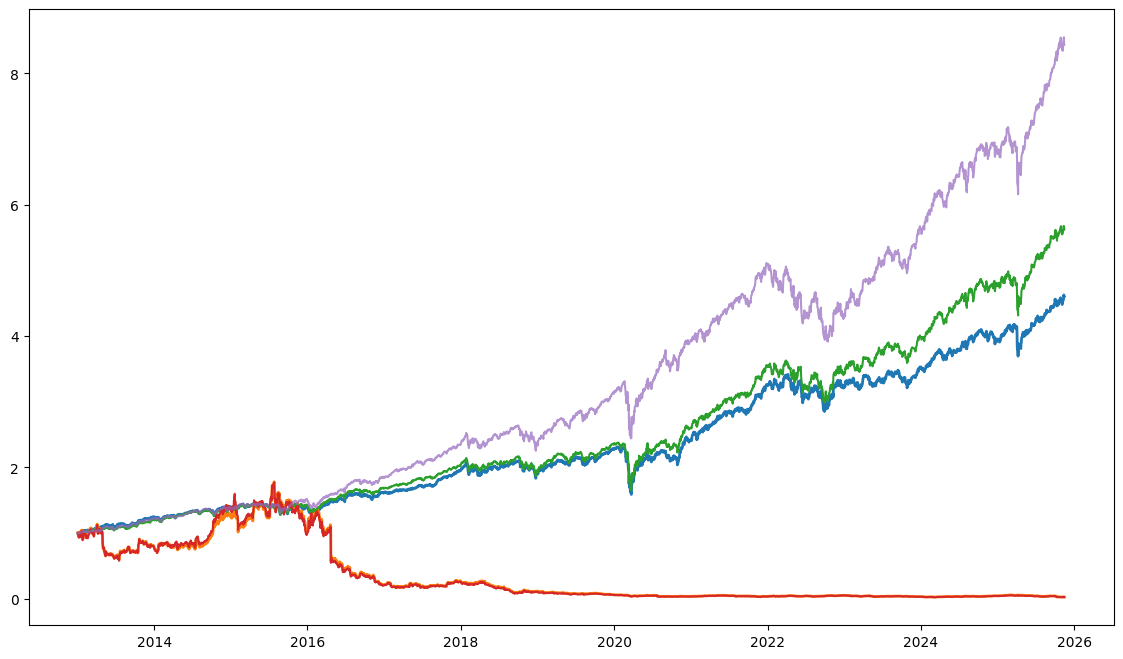

In [347]:
import matplotlib.pyplot as plt

# Plot with log scale for better visibility
plt.figure(figsize=(14, 8))
plt.plot(selected_portfolio_historical_cumulative_returns.index, 
         selected_portfolio_historical_cumulative_returns + 1, 
         label='Selected Long Only (Least Volatile)', linewidth=2)
plt.plot(selected_portfolio_historical_cumulative_returns_shorts.index, 
         selected_portfolio_historical_cumulative_returns_shorts + 1, 
         label='Selected Shorts Allowed (Least Volatile)', linewidth=2)
plt.plot(best_sharpe_ratio_historical_cumulative_returns.index, 
         best_sharpe_ratio_historical_cumulative_returns + 1, 
         label='Best Sharpe (Long Only)', linewidth=1.5)
plt.plot(best_sharpe_ratio_historical_cumulative_returns_shorts.index, 
         best_sharpe_ratio_historical_cumulative_returns_shorts + 1, 
         label='Best Sharpe (Shorts Allowed)', linewidth=1.5)
plt.plot(portfolio_cumulative_returns.index, 
         portfolio_cumulative_returns + 1, 
         label='Equal Weighted', alpha=0.7)
plt.plot(cumulative_returns.index, 
         cumulative_returns['SPY'] + 1, 
         label='SPY', alpha=0.8, linestyle='--')

plt.yscale('log')
plt.title('Historical Cumulative Returns: Portfolio Comparisons vs SPY (Log Scale)')
plt.xlabel('Date')
plt.ylabel('Growth of $1 (log scale)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

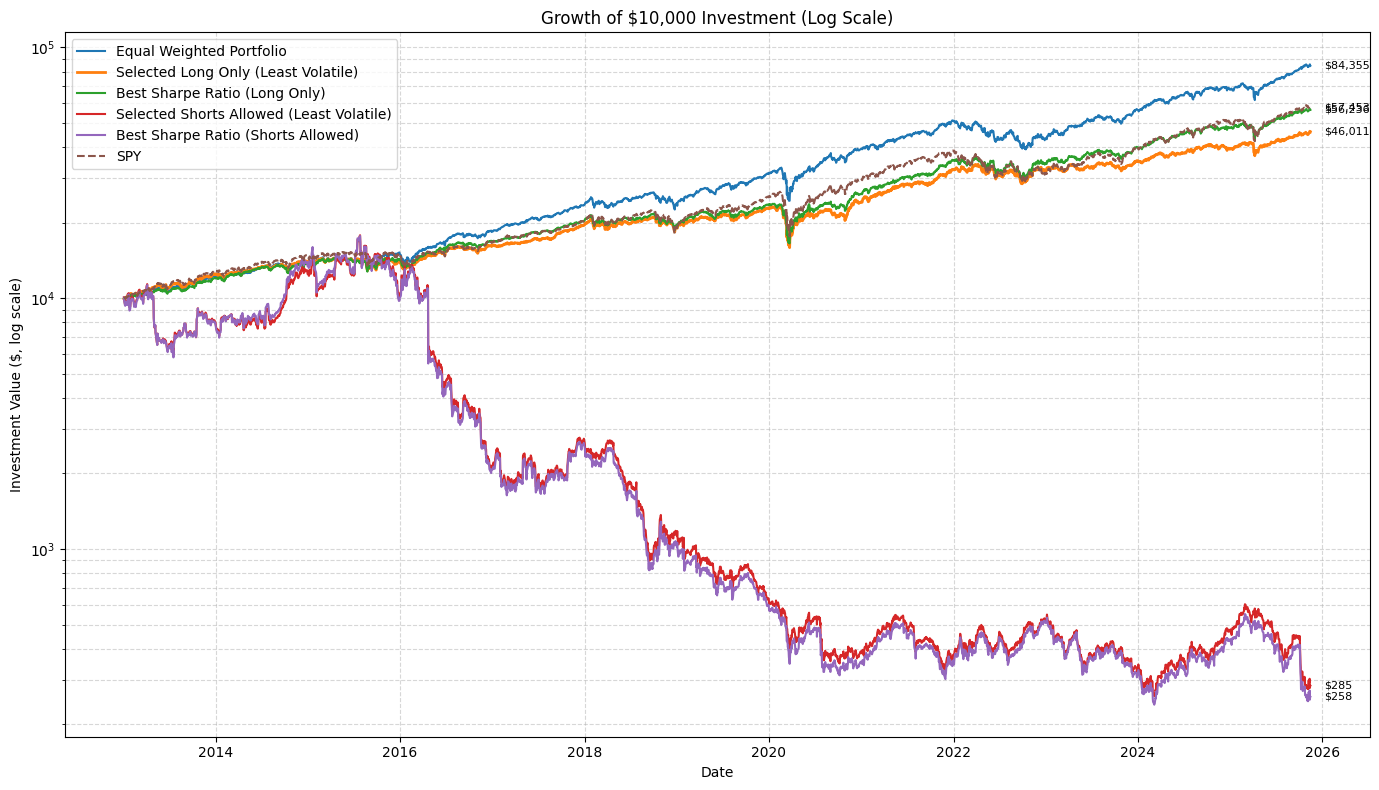

In [268]:
import matplotlib.pyplot as plt

# Define the initial investment amount
initial_investment = 10000

# Calculate the growth of the initial investment for each portfolio and SPY
equal_weighted_investment_growth = initial_investment * (1 + portfolio_cumulative_returns)
selected_long_only_investment_growth = initial_investment * (1 + selected_portfolio_historical_cumulative_returns)
best_sharpe_ratio_long_only_investment_growth = initial_investment * (1 + best_sharpe_ratio_historical_cumulative_returns)
selected_shorts_allowed_investment_growth = initial_investment * (1 + selected_portfolio_historical_cumulative_returns_shorts)
best_sharpe_ratio_shorts_allowed_investment_growth = initial_investment * (1 + best_sharpe_ratio_historical_cumulative_returns_shorts)
spy_investment_growth = initial_investment * (1 + cumulative_returns['SPY'])

# Calculate investment growth (already defined in your notebook)

# Plot with log scale
plt.figure(figsize=(14, 8))
plt.plot(equal_weighted_investment_growth.index, equal_weighted_investment_growth, 
         label='Equal Weighted Portfolio')
plt.plot(selected_long_only_investment_growth.index, selected_long_only_investment_growth, 
         label='Selected Long Only (Least Volatile)', linewidth=2)
plt.plot(best_sharpe_ratio_long_only_investment_growth.index, 
         best_sharpe_ratio_long_only_investment_growth, 
         label='Best Sharpe Ratio (Long Only)')
plt.plot(selected_shorts_allowed_investment_growth.index, 
         selected_shorts_allowed_investment_growth, 
         label='Selected Shorts Allowed (Least Volatile)')
plt.plot(best_sharpe_ratio_shorts_allowed_investment_growth.index, 
         best_sharpe_ratio_shorts_allowed_investment_growth, 
         label='Best Sharpe Ratio (Shorts Allowed)')
plt.plot(spy_investment_growth.index, spy_investment_growth, 
         label='SPY', linestyle='--')

plt.yscale('log')
plt.title('Growth of $10,000 Investment (Log Scale)')
plt.xlabel('Date')
plt.ylabel('Investment Value ($, log scale)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Annotate final values (adjust positions to avoid overlap on log scale)
for name, series in [
    ('Equal', equal_weighted_investment_growth),
    ('Long', selected_long_only_investment_growth),
    ('Best Long', best_sharpe_ratio_long_only_investment_growth),
    ('Shorts', selected_shorts_allowed_investment_growth),
    ('Best Shorts', best_sharpe_ratio_shorts_allowed_investment_growth),
    ('SPY', spy_investment_growth)
]:
    final_val = series.iloc[-1]
    plt.annotate(f'${final_val:,.0f}', 
                xy=(series.index[-1], final_val),
                xytext=(10, 0), textcoords='offset points',
                fontsize=8, verticalalignment='center')

plt.tight_layout()
plt.show()

Selected portfolio MC summary (25 yrs):


mean     median        std       p05        p95
final_wealth_gross  18.318456  14.750609  13.174766  4.685166  41.091946
final_wealth_net    18.277251  14.750609  13.173298  4.685166  41.091946
perf_fee_paid        0.041206   0.000000   0.158134  0.000000   0.262114
final_spy_wealth    32.302586  23.430795  33.612882  5.747528  84.148261
alpha_annual        -0.023114  -0.022479   0.015218 -0.049274   0.001197
beta                 0.697985   0.697962   0.004533  0.690926   0.705280
sharpe               0.875218   0.873423   0.196537  0.530420   1.181158
max_drawdown        -0.283395  -0.275668   0.066605 -0.413911  -0.195825
r2                   0.787385   0.787167   0.004725  0.780437   0.795132

Equal-weight portfolio MC summary (25 yrs):


mean     median        std        p05         p95
final_wealth_gross  62.203450  48.327003  49.532858  14.103550  157.833935
final_wealth_net    56.178583  43.792948  45.522701  12.421051  142.328250
perf_fee_paid        6.024867   4.833279   4.680831   1.470254   14.143220
final_spy_wealth    32.094530  22.183062  31.421755   5.346711   93.241404
alpha_annual         0.026330   0.026659   0.010630   0.008681    0.043133
beta                 0.804168   0.804098   0.003401   0.798361    0.809651
sharpe               1.151546   1.155202   0.208202   0.811719    1.485039
max_drawdown        -0.256725  -0.246285   0.057568  -0.363019   -0.179856
r2                   0.908188   0.908179   0.002275   0.904372    0.911905


Selected portfolio mean alpha, beta, sharpe (from trials):


alpha_annual      beta    sharpe
mean     -0.023114  0.697985  0.875218
std       0.015218  0.004533  0.196537


Equal-weight portfolio mean alpha, beta, sharpe (from trials):


alpha_annual      beta    sharpe
mean       0.02633  0.804168  1.151546
std        0.01063  0.003401  0.208202

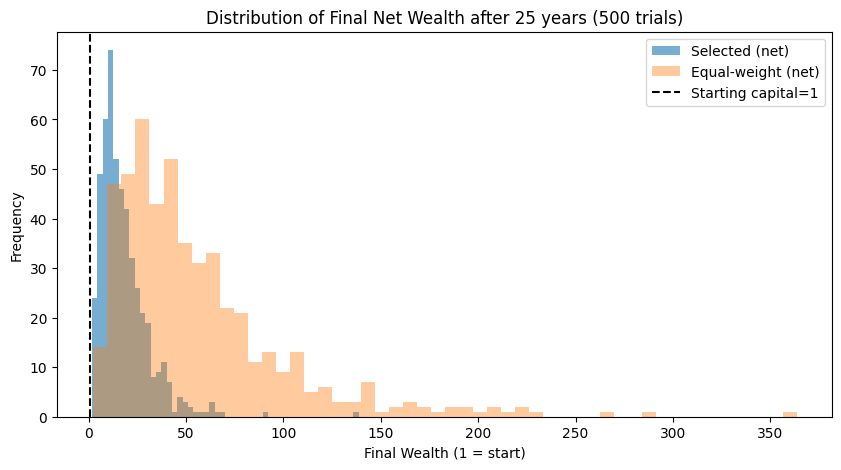

In [269]:
# ...existing code...
import numpy as np
import pandas as pd
from scipy import stats

def run_walkforward_mc(weights,
                        daily_returns_all,   # DataFrame including SPY
                        sim_years=25,
                        trading_days_per_year=252,
                        n_trials=500,
                        management_fee_annual=0.01,
                        performance_fee_rate=0.20,
                        random_state=42):
    """
    Monte Carlo walk-forward backtest:
      - Simulates multivariate daily returns using historical mean & cov.
      - Applies daily management fee (subtracted from returns) and an end performance fee on excess vs benchmark.
      - Returns DataFrame of trial metrics and a summary table.
    Inputs:
      weights: pd.Series aligned to daily_returns_all columns (must include 'SPY' in daily_returns_all)
      daily_returns_all: DataFrame with asset daily returns (decimal, not %). Must include 'SPY'.
    """
    rng = np.random.default_rng(random_state)
    n_days = int(sim_years * trading_days_per_year)
    assets = list(daily_returns_all.columns)
    if 'SPY' not in assets:
        raise ValueError("daily_returns_all must include 'SPY' column for benchmark comparisons.")
    # empirical mean & cov of daily returns
    mu = daily_returns_all.mean().values
    cov = daily_returns_all.cov().values
    # align weights to full asset list (fill missing with 0)
    w = weights.reindex(assets).fillna(0).values
    spy_idx = assets.index('SPY')
    fee_daily = management_fee_annual / trading_days_per_year

    results = []
    for t in range(n_trials):
        sim = rng.multivariate_normal(mean=mu, cov=cov, size=n_days)
        sim_df = pd.DataFrame(sim, columns=assets)

        # portfolio daily returns
        port_daily = sim_df.values.dot(w)
        spy_daily = sim_df.iloc[:, spy_idx].values

        # apply daily management fee
        port_daily_net = port_daily - fee_daily
        spy_daily_net = spy_daily - fee_daily  # change to 0 if benchmark shouldn't be charged

        # wealth paths
        port_wealth = np.cumprod(1 + port_daily_net)
        spy_wealth = np.cumprod(1 + spy_daily_net)

        final_port_wealth = port_wealth[-1]
        final_spy_wealth = spy_wealth[-1]

        # performance fee on excess (simple end-of-period rule)
        excess = final_port_wealth - final_spy_wealth
        perf_fee_paid = 0.0
        if excess > 0 and performance_fee_rate > 0:
            perf_fee_paid = excess * performance_fee_rate
            final_port_wealth_net = final_port_wealth - perf_fee_paid
        else:
            final_port_wealth_net = final_port_wealth

        # alpha (annualized mean excess), beta (slope), sharpe (annualized), max drawdown
        daily_excess = port_daily_net - spy_daily_net
        alpha_annual = daily_excess.mean() * trading_days_per_year
        slope, intercept, r_value, p_value, std_err = stats.linregress(spy_daily_net, port_daily_net)
        beta = slope
        sharpe = (port_daily_net.mean() / port_daily_net.std()) * np.sqrt(trading_days_per_year) if port_daily_net.std() != 0 else np.nan
        cum_max = np.maximum.accumulate(port_wealth)
        drawdown = (port_wealth - cum_max) / cum_max
        max_dd = drawdown.min()

        results.append({
            'final_wealth_gross': final_port_wealth,
            'final_wealth_net': final_port_wealth_net,
            'perf_fee_paid': perf_fee_paid,
            'final_spy_wealth': final_spy_wealth,
            'alpha_annual': alpha_annual,
            'beta': beta,
            'sharpe': sharpe,
            'max_drawdown': max_dd,
            'r2': r_value**2
        })

    df = pd.DataFrame(results)
    stats_summary = df.agg(['mean','median','std', lambda x: x.quantile(0.05), lambda x: x.quantile(0.95)]).T
    stats_summary.columns = ['mean','median','std','p05','p95']
    return df, stats_summary

# Example usage (replace variables with ones in your notebook scope)
mc_trials = 500
sim_years = 25

try:
    df_sel, summary_sel = run_walkforward_mc(selected_portfolio_weights, daily_returns, sim_years=sim_years, n_trials=mc_trials,
                                             management_fee_annual=0.01, performance_fee_rate=0.20, random_state=1)
    df_eq, summary_eq = run_walkforward_mc(equal_weight_portfolio_weights, daily_returns, sim_years=sim_years, n_trials=mc_trials,
                                           management_fee_annual=0.01, performance_fee_rate=0.20, random_state=2)

    print("Selected portfolio MC summary (25 yrs):")
    display(summary_sel.round(6))
    print("Equal-weight portfolio MC summary (25 yrs):")
    display(summary_eq.round(6))

    # quick checks: mean alpha, beta, sharpe from trials
    print("\nSelected portfolio mean alpha, beta, sharpe (from trials):")
    display(df_sel[['alpha_annual','beta','sharpe']].agg(['mean','std']).round(6))

    print("\nEqual-weight portfolio mean alpha, beta, sharpe (from trials):")
    display(df_eq[['alpha_annual','beta','sharpe']].agg(['mean','std']).round(6))

    # visualize final net wealth distributions
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.hist(df_sel['final_wealth_net'], bins=50, alpha=0.6, label='Selected (net)')
    plt.hist(df_eq['final_wealth_net'], bins=50, alpha=0.4, label='Equal-weight (net)')
    plt.axvline(1.0, color='k', linestyle='--', label='Starting capital=1')
    plt.legend()
    plt.title(f'Distribution of Final Net Wealth after {sim_years} years ({mc_trials} trials)')
    plt.xlabel('Final Wealth (1 = start)')
    plt.ylabel('Frequency')
    plt.show()

except Exception as e:
    print("MC backtest failed:", e)
# ...existing code...

In [270]:
# ...existing code...
import numpy as np
from scipy import stats

# set risk-free daily rate (e.g., annual 0.0 -> daily 0)
rf_annual = 0.0
rf_daily = rf_annual / 252

# align series (use your portfolio returns series variable)
port = selected_portfolio_historical_returns.reindex(daily_returns.index).dropna()
market = daily_returns['SPY'].reindex(port.index).dropna()
port = port.loc[market.index]

excess_port = port - rf_daily
excess_market = market - rf_daily

slope, intercept, r_value, p_value, std_err = stats.linregress(excess_market, excess_port)
beta = slope
alpha_daily = intercept
alpha_annual = alpha_daily * 252

print(f"beta = {beta:.4f}")
print(f"alpha (daily) = {alpha_daily:.6f}, alpha (annual) = {alpha_annual:.4f}")
print(f"regression R^2 = {r_value**2:.4f}, p-value (beta) = {p_value:.4e}")
# ...existing code...

beta = 0.6982
alpha (daily) = 0.000090, alpha (annual) = 0.0227
regression R^2 = 0.7873, p-value (beta) = 0.0000e+00


In [271]:
# ...existing code...
import numpy as np

spy_final = cumulative_returns['SPY'].iloc[-1]
port_final = selected_portfolio_historical_cumulative_returns.iloc[-1]

summary = {
    'Selected final cumulative return': float(port_final),
    'SPY final cumulative return': float(spy_final),
    'Selected annualized vol': float(selected_portfolio_historical_volatility),
    'SPY annualized vol': float(spy_annualized_volatility),
    'Selected Sharpe': float(selected_portfolio_historical_sharpe_ratio),
    'SPY Sharpe': float(spy_sharpe_ratio),
    'Selected VaR95': float(selected_portfolio_historical_VaR_95),
    'Selected CVaR95': float(selected_portfolio_historical_CVaR_95),
}

# alpha / beta computed earlier as alpha_annual, beta
summary['alpha_annual'] = float(alpha_annual) if 'alpha_annual' in globals() else np.nan
summary['beta'] = float(beta) if 'beta' in globals() else np.nan

for k,v in summary.items():
    print(f"{k}: {v:.6f}")

# simple interpretation
if summary['Selected Sharpe'] > summary['SPY Sharpe']:
    print("\nInterpretation: Selected portfolio shows higher risk-adjusted return than SPY.")
elif summary['Selected Sharpe'] < summary['SPY Sharpe']:
    print("\nInterpretation: SPY has higher risk-adjusted return than the selected portfolio.")
else:
    print("\nInterpretation: Risk-adjusted returns are similar.")
# ...existing code...

Selected final cumulative return: 3.601054
SPY final cumulative return: 4.745256
Selected annualized vol: 0.133542
SPY annualized vol: 0.169715
Selected Sharpe: 0.956802
SPY Sharpe: 0.887029
Selected VaR95: 0.011780
Selected CVaR95: 0.019684
alpha_annual: 0.022664
beta: 0.698199

Interpretation: Selected portfolio shows higher risk-adjusted return than SPY.


In [164]:
# export the weights to a csv file
selected_portfolio_weights.to_csv('selected_portfolio_weights.csv')
selected_portfolio_historical_cumulative_returns.to_csv('selected_portfolio_historical_cumulative_returns.csv')

### Short interpretive guidance (use after you run the cell)

If portfolio: higher Sharpe, similar/lower volatility, lower VaR/CVaR -> outperforms on risk-adjusted basis and reduces downside risk compared with SPY.
If portfolio: lower Sharpe or higher tail risk -> SPY likely superior on a risk-adjusted or downside basis; portfolio may still suit investors seeking dividends or different exposures.
Alpha > 0 and statistically significant -> the strategy delivered excess return after adjusting for market exposure. Beta shows how correlated/sensitive the portfolio is to SPY (beta >1 -> more market-sensitive; beta <1 -> less).
Why an investor might choose this fund vs SPY (bullets)

Diversification: different asset mix (tech, REIT, gold, FX, treasuries) reduces single-market concentration.
Income target: designed to target a dividend yield (4%) which SPY may not match.
Risk profile: selected portfolio may offer lower volatility or better downside protection (lower VaR/CVaR).
Active objectives: multi-objective optimization (return, yield, risk) and model-driven selection can produce portfolios tailored to investor goals.
Trade-offs: potential lower liquidity, higher tracking error, and model risk vs SPY’s simplicity and low cost.
Prospectus outline (one-paragraph examples per section)

Fund name / ticker: (short line)
Investment objective: "Total return with an emphasis on income targeting ~4% annual dividend yield while seeking capital appreciation."
Strategy: "Quantitative multivariate Bi-LSTM predictions combined with NSGA‑II multi-objective optimization to select portfolios balancing predicted return, dividend yield and volatility. Long-only (or shorts-allowed) allocations across X listed securities; rebalanced periodically."
Benchmark: "S&P 500 (SPY) for performance and risk comparisons."
Risks: "Market risk, model risk, estimation error, liquidity risk, concentration risk, counterparty risk; shorting risk if applicable; principal loss possible."
Fees & expenses: "Management fee X%; performance fee Y% (describe high-water mark and calculation); transaction costs; estimated expense ratio."
Distributions & taxation: "Quarterly (or monthly) dividend distribution policy; reinvestment option; tax considerations."
Historical performance: "Table and charts vs SPY, plus volatility, Sharpe, VaR, CVaR, alpha/beta, and drawdowns (see performance section)."
Portfolio holdings & turnover: "Top holdings, typical allocation ranges, expected turnover and rebalancing cadence."
Fund governance: "Manager, investment team, risk controls, auditor, custody arrangements."

## Prospectus

Fund name: Quant Growth & Income Fund
Ticker: QGIBL (proposed)
Structure: Open‑end ETF or UCITS‑style fund (proposed)

Investment objective

Seek total return with an emphasis on current income targeting an approximate 4% annual cash distribution while pursuing long‑term capital appreciation.
Strategy summary

Systematic, rules‑based portfolio constructed from liquid equities, equity ETFs (e.g., large cap tech, REITs), gold ETF, select fixed‑income ETFs and currency exposures.
Cross‑asset predictions generated from a multivariate Bidirectional LSTM model trained on price, momentum and price‑range features. Candidate portfolio sets are produced by an NSGA‑II multi‑objective optimizer that trades off predicted return, dividend yield and predicted volatility/CVaR.
Typical positioning: long‑only core (shorts‑allowed share class available), target number of holdings 15–40, periodic rebalancing monthly or quarterly. Cash and short‑term Treasuries used for liquidity management.
Benchmark

Primary benchmark: S&P 500 (SPY). Secondary comparisons: equal‑weight composite of universe tickers, 60/40 blended indices for risk context.
Key investment policies and constraints

Long‑only default (shorts‑allowed share class optional).
Maximum position size per issuer: 20% (case‑by‑case exceptions disclosed).
Maximum sector concentration thresholds and liquidity constraints applied.
Leverage limited to X% (disclosed in shareholder materials).
Index‑agnostic; active model and optimizer determine weights subject to constraints.
Principal risks (concise)

Market risk: value may fluctuate with equity and macro markets.
Model & data risk: prediction errors, overfitting, regime shifts, input data quality may reduce effectiveness.
Tracking / active risk: returns will deviate from the benchmark (higher tracking error).
Dividend risk: target yield not guaranteed; dividend cuts or suspensions by issuers reduce income.
Liquidity risk: some holdings or trading dates may incur higher transaction costs or price impact.
Concentration risk: focused exposures may amplify losses in adverse moves.
Short‑selling risk (if applicable): potential unlimited loss, financing and dividend‑payment obligations.
Operational & counterparty risk: model pipeline, execution, custody and counterparty defaults.
Tax risk: distributions may be ordinary income, qualified dividends, or capital gains depending on jurisdiction and portfolio activity.
Fees and expenses (example / proposed)

Management fee: 0.75% per annum (charged daily).
Expense ratio (estimated): 0.95% — includes custody, administration, audit and listing costs.
Performance fee (optional share class): 20% of excess return versus benchmark measured net of fees with a high‑water mark and 1‑year lockup. (Exact fee schedule disclosed in final prospectus.)
Transaction and market costs borne by the fund; trading costs and realized turnover may increase taxable distributions.
Distributions and yield policy

Distributions paid quarterly (cash) with automatic dividend reinvestment option (DRIP) available.
Target cash distribution: ~4% annualized. Target is not guaranteed; yield may fluctuate with realized dividends and portfolio value.
Distribution sources: qualified dividends, interest, capital gains; tax characterization provided annually.
Performance and backtest disclosure

Historical and backtested performance presented in a separate section with full methodology, data‑range, in‑sample vs out‑of‑sample flags, and disclaimers. Backtests are hypothetical, do not reflect trading costs or actual fund operations, and are not guarantees of future results.
Performance tables include cumulative return, annualized return, annualized volatility, Sharpe ratio, Value at Risk (95%), Conditional VaR (95%), maximum drawdown, alpha and beta vs SPY.
Portfolio construction & holdings

Top holdings and weight ranges reported monthly.
Typical allocation bands (illustrative): equities 50–80%, fixed income (treasuries/IG) 10–30%, gold/cash/FX 0–15%, REITs 5–15%.
Expected turnover: moderate (quarterly rebalancing + model‑driven adjustments). Turnover and realized tax impact disclosed annually.
Risk management & governance

Multi‑layer risk controls: exposure limits, sector/issuer caps, liquidity screens, stress testing, CVaR constraints and kill switches for model anomalies.
Independent risk oversight: Chief Risk Officer and an independent risk committee.
Audit, custody and compliance: third‑party auditor, regulated custodian, compliance program consistent with ETF/UCITS rules.
Operational details

Listing exchange, ticker and share classes disclosed on launch.
Creation/redemption mechanism for ETF; authorized participants required.
Minimum investment, NAV calculation, trade timing and orders described in the shareholder agreement.
How the fund differs from SPY (summary)

Active model‑driven strategy seeking income + growth vs SPY’s passive, market‑cap weighted exposure.
Targeted 4% distribution policy vs SPY’s market dividend yield (variable and typically lower).
Potential for lower drawdown or different volatility profile via diversification across non‑SP500 exposures (gold, treasuries, REITs, currency overlays).
Trade‑offs: higher fees, model/active risk and tracking error; SPY offers simplicity, ultra‑low cost and liquidity.
Who this fund may suit

Investors seeking systematic exposure that blends income and growth with an explicit dividend target.
Those willing to accept active‑management risk, modestly higher fees and model‑dependence for potential improved risk‑adjusted outcomes vs passive market exposure.
Taxes

Tax treatment of distributions depends on jurisdiction and nature of income (qualified dividend, ordinary income, capital gains). Shareholders receive annual tax statements. Consult a tax advisor.
Subscriptions, redemptions & liquidity

ETF shares trade intraday on exchange; authorized participant creation/redemption for large institutional flows; secondary market liquidity subject to market conditions.
Reporting & disclosures

Quarterly fact sheets with holdings, performance vs SPY and peer group, turnover, top risk metrics (VaR/CVaR, drawdowns).
Annual report and audited financial statements.
Full prospectus and model / backtest methodology available on fund website. Material changes to strategy require prior disclosure.
Conflicts of interest & compensation

Manager and affiliates may manage other strategies using similar quantitative methods; cross‑trades and allocation policies governed by conflict policies and overseen by compliance.
Legal & regulatory

Not a guarantee of returns. Investments involve risk of loss of principal. This prospectus is draft and for informational purposes only; the final legal prospectus contains full risk, fee and legal disclosures, offering terms and regulatory notices. Investors should read the final prospectus carefully before investing.
Contact & further information

Website, investor relations email and phone (to be provided at launch).
Requests for the full model methodology, backtest details and audited performance available on request.
Note: This is a draft prospectus suitable for investor presentation or regulatory drafting. Final prospectus text must be reviewed by legal, compliance and the fund’s regulator and populated with audited historical results, final fee schedule, precise holdings, disclosure language and jurisdiction‑specific legal language.